<a href="https://colab.research.google.com/github/ahmedengu/feature_importance/blob/master/Stocks/Egypt/COMI/COMI_1D_High.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from IPython.display import clear_output
import pandas as pd

if pd.__version__ != '0.25.0' or False:
  # install
  !apt-get install default-jre build-essential swig
  !pip  install h2o==3.24.0.5 yfinance==0.1.43
  !pip  install git+https://github.com/ahmedengu/findatapy.git pandas==0.25.0
  clear_output(wait=True)

  !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
  !tar -xzvf ta-lib-0.4.0-src.tar.gz
  %cd ta-lib
  !./configure --prefix=/usr
  clear_output(wait=True)
  !make
  clear_output(wait=True)
  !make install
  clear_output(wait=True)
  !pip install Ta-Lib==0.4.17
  clear_output(wait=True)
  print('RESTARTING')
  %cd /content
  
  # force restart
  import os
  os.kill(os.getpid(), 9)

In [0]:
# Experiment Config
import pandas as pd
from IPython.display import display
from IPython.core.debugger import set_trace

data_ticker = "COMI"
data_resample = '1D'
data_label = 'High'
data_label_name = 'y'
start_date = '1 Jan 2009'
finish_date = '1 Jan 2019'
is_duka = False
is_yahoo = False
kaggle_file = 'bitstamp' # default None
kaggle_folder = '1 Day/Stocks'

models_summary = {}
for metric in ['accuracy','F1','auc','logloss','mean_per_class_error','rmse','mse']:
  models_summary.update({metric:pd.DataFrame()})

# feature elimination config
model_selected_features = 50
PCA_k = 50
HCF_threshold = 0.90
LVF_threshold = 0.1
GLRM_k = 20
select_k = 50
select_percentile = 10
select_alpha = 0.1
select_rfe = 50

features_to_include = ['All', 'DLF', 'XGBF', 'RFE', 'Fwe'] # True for all , ['All','Fwe','RFE','Percentile','KBest','LVF','HCF','PCA','XGBF','GLMF','DLF','GLRM'] 
is_EDA = True
max_models_num = 10

# pandas options
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
# random seed
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)
import pandas as pd
import gc
import os

resample_how= {'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last',
                             'Volume': 'sum', 'Date': 'first'}

if is_duka:
  from findatapy.util import DataConstants

  DataConstants.market_thread_no.update({'dukascopy': 64})

  # Download dataset
  from findatapy.market import Market, MarketDataRequest, MarketDataGenerator

  market = Market(market_data_generator=MarketDataGenerator(log_every_day=30))

  md_request = MarketDataRequest(start_date=start_date, finish_date=finish_date,
                                       fields=['temp', 'ask', 'bid', 'askv', 'bidv'], vendor_fields=['temp', 'ask', 'bid', 'askv', 'bidv'],
                                       freq='tick', data_source='dukascopy',
                                       tickers=[data_ticker], vendor_tickers=[data_ticker])

  temp_dataset = market.fetch_market(md_request)
  full_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bid'].resample(data_resample).ohlc())
  full_dataset.columns = ['Open', 'High', 'Low', 'Close']
  temp_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bidv'].resample(data_resample).sum())
  temp_dataset.columns = ['Volume']
  full_dataset['Volume'] = temp_dataset['Volume']

  del temp_dataset, md_request, market, DataConstants, Market, MarketDataRequest, MarketDataGenerator

  gc.collect()

elif is_yahoo:
  import yfinance as yf
  from datetime import datetime

  full_dataset = yf.download(data_ticker, start=str(datetime.strptime(start_date, '%d %b %Y')).split(' ')[0], end=str(datetime.strptime(finish_date, '%d %b %Y')).split(' ')[0])
  full_dataset['Date']=full_dataset.index
  del yf,datetime

elif data_ticker == 'EURUSD':
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2014.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2015.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2016.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2017.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2018.zip
  !unzip -qq -o \*.zip
  full_dataset = pd.read_csv('DAT_ASCII_EURUSD_M1_2014.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';')
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2015.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2016.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2017.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2018.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset['Date'] = pd.to_datetime(full_dataset['Date'])
  full_dataset.index = full_dataset['Date']
  full_dataset = full_dataset.dropna()
  full_dataset = full_dataset.sort_index()
  full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]


    
elif data_ticker == 'APPLUSUSD':
  full_dataset=pd.read_csv('https://github.com/kyleconroy/apple-stock/raw/master/apple_stock_data.csv',index_col =0,parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > '2007-04-01']


elif data_ticker == 'COMI':
  full_dataset=pd.read_csv('https://static.mubasher.info/File.MubasherCharts/File.Historical_Stock_Charts_Dir/44507230b2b03e2da37352abf1a659545b44.csv',index_col =0,names =['Open', 'High', 'Low', 'Close','Volume'],parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Volume'] = full_dataset['Volume'] * full_dataset['Close'] 
  full_dataset = full_dataset.drop_duplicates()
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]
  
elif kaggle_file is not None:
  if not os.path.isfile('kaggle.json'):
    from google.colab import files
    files.upload()
    
    import time
    time.sleep(10)
    !ls
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !ls ~/.kaggle

    !chmod 600 /root/.kaggle/kaggle.json
    del files
    
  !kaggle datasets download $data_ticker
  !unzip -qq -o \*.zip
  !unzip -qq -o \*.zip

  if data_ticker == 'mczielinski/bitcoin-historical-data':
    
    full_dataset = pd.read_csv([file for file in os.listdir() if kaggle_file in file][0])
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Volume_(Currency)','Weighted_Price']
    full_dataset.index=pd.to_datetime(full_dataset['Date'], unit='s')

    resample_how.update({'Volume_(Currency)': 'sum', 'Weighted_Price': 'last'})

    full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()[1:-1]
    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]
  
  elif data_ticker == 'borismarjanovic/daily-and-intraday-stock-price-data':
    
    full_dataset = pd.read_csv(kaggle_folder + '/' + [file for file in os.listdir(kaggle_folder) if kaggle_file in file][0])
    if 'Time' in full_dataset.columns:
      full_dataset['Date'] = pd.to_datetime(full_dataset['Date'] + ' ' + full_dataset['Time'])
      full_dataset = full_dataset.drop('Time',axis=1)
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt']
    full_dataset.index=pd.to_datetime(full_dataset['Date'])

    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]

  
gc.collect()
full_dataset = full_dataset.dropna()

full_dataset = full_dataset.drop('Date',axis=1, errors='ignore')
full_dataset = full_dataset.sort_index()
full_dataset = full_dataset[-100000:]
display(full_dataset)
display(full_dataset.describe())
full_dataset.to_pickle('full_dataset')
del full_dataset, set_random_seed, seed
gc.collect()

Open   High    Low  Close       Volume
2009-01-04   8.06   8.30   8.06   8.12  14236982.76
2009-01-05   8.11   8.32   8.11   8.20  21634207.60
2009-01-06   8.31   8.31   7.79   7.94  34526383.34
2009-01-08   7.76   8.16   7.68   7.92  28332398.16
2009-01-11   7.90   8.21   7.79   7.98  17588159.40
...           ...    ...    ...    ...          ...
2018-12-25  58.58  58.15  57.26  57.66  14868207.60
2018-12-26  57.66  58.41  57.92  58.11  15019459.26
2018-12-27  58.11  59.19  58.41  58.62  44193207.66
2018-12-30  58.62  59.20  58.40  58.73  10250381.82
2018-12-31  58.73  59.99  58.80  59.26  52718881.20

[2410 rows x 5 columns]

Open         High          Low        Close        Volume
count  2410.000000  2410.000000  2410.000000  2410.000000  2.410000e+03
mean     29.382506    29.744739    29.034137    29.396614  5.770845e+07
std      20.101342    20.290421    19.905895    20.104024  6.039583e+07
min       6.490000     6.710000     6.290000     6.590000  6.101658e+05
25%      12.940000    13.100000    12.782500    12.940000  2.322839e+07
50%      21.210000    21.480000    21.065000    21.295000  4.141007e+07
75%      37.100000    37.485000    36.895000    37.205000  7.314775e+07
max      75.990000    77.200000    74.660000    75.990000  9.099566e+08

21

In [4]:
# OHLC EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('full_dataset')))
  del pp

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


In [5]:
# features
from talib._ta_lib import *
import talib
import numpy as np
import uuid
import os


features_dataset = pd.read_pickle('full_dataset').sort_index()


periods = np.resize([2, 3, 3, 2], len(features_dataset['Close'])).astype(float)
timeperiods = [8, 12, 14, 20, 24, 30]
matypes = range(9)
nbdevs = [2, 3, 4, 5]

# date features
features_dataset['day'] = features_dataset.index.day
features_dataset['dayofweek'] = features_dataset.index.dayofweek
features_dataset['dayofyear'] = features_dataset.index.dayofyear
features_dataset['days_in_month'] = features_dataset.index.days_in_month
features_dataset['hour'] = features_dataset.index.hour
features_dataset['is_month_end'] = pd.factorize(features_dataset.index.is_month_end)[0]
features_dataset['is_month_start'] = pd.factorize(features_dataset.index.is_month_start)[0]
features_dataset['is_quarter_end'] = pd.factorize(features_dataset.index.is_quarter_end)[0]
features_dataset['is_quarter_start'] = pd.factorize(features_dataset.index.is_quarter_start)[0]
features_dataset['minute'] = features_dataset.index.minute
features_dataset['month'] = features_dataset.index.month
features_dataset['quarter'] = features_dataset.index.quarter
features_dataset['second'] = features_dataset.index.second
features_dataset['week'] = features_dataset.index.week
features_dataset['weekday'] = features_dataset.index.weekday
features_dataset['weekday_name'] = pd.factorize(features_dataset.index.weekday_name)[0]
features_dataset['weekofyear'] = features_dataset.index.weekofyear

# Overlap Studies
features_dataset['HT_TRENDLINE'] = HT_TRENDLINE(features_dataset['Close'])
features_dataset['mama'], features_dataset['fama'] = MAMA(features_dataset['Close'])
features_dataset['SAREXT'] = SAREXT(features_dataset['High'], features_dataset['Low'], startvalue=-4e37,
                                    offsetonreverse=-4e37, accelerationinitlong=-4e37,
                                    accelerationlong=-4e37, accelerationmaxlong=-4e37, accelerationinitshort=-4e37,
                                    accelerationshort=-4e37, accelerationmaxshort=-4e37)

for timeperiod in timeperiods:
    features_dataset['DEMA_' + str(timeperiod)] = DEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['EMA_' + str(timeperiod)] = EMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['KAMA_' + str(timeperiod)] = KAMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPOINT_' + str(timeperiod)] = MIDPOINT(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPRICE_' + str(timeperiod)] = MIDPRICE(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['SAR_' + str(timeperiod / 100)] = SAR(features_dataset['High'], features_dataset['Low'],
                                                           acceleration=timeperiod / 100,
                                                           maximum=timeperiod / 100)
    features_dataset['SMA_' + str(timeperiod)] = SMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TEMA_' + str(timeperiod)] = TEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIMA_' + str(timeperiod)] = TRIMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WMA_' + str(timeperiod)] = WMA(features_dataset['Close'], timeperiod=timeperiod)

    for matype in matypes:
        features_dataset['MA_' + str(timeperiod) + '_' + str(matype)] = MA(features_dataset['Close'],
                                                                           timeperiod=timeperiod, matype=matype)
        features_dataset['MAVP_' + str(timeperiod) + '_' + str(matype)] = MAVP(features_dataset['Close'], periods,
                                                                               minperiod=2,
                                                                               maxperiod=timeperiod, matype=matype)
        features_dataset['T3_' + str(timeperiod) + '_' + str(matype)] = T3(features_dataset['Close'],
                                                                           timeperiod=timeperiod,
                                                                           vfactor=matype / 10)

        for nbdev in nbdevs:
            features_dataset['BBANDS_upperband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_middleband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_lowerband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)] = BBANDS(
                features_dataset['Close'], timeperiod=timeperiod, nbdevup=nbdev, nbdevdn=nbdev, matype=matype)

            
gc.collect()
# Momentum Indicators
features_dataset['BOP'] = BOP(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                              features_dataset['Close'])

for timeperiod in timeperiods:
    features_dataset['ADX_' + str(timeperiod)] = ADX(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ADXR_' + str(timeperiod)] = ADXR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['aroondown_' + str(timeperiod)], features_dataset['aroonup_' + str(timeperiod)] = AROON(
        features_dataset['High'],
        features_dataset['Low'],
        timeperiod=timeperiod)
    features_dataset['AROONOSC_' + str(timeperiod)] = AROONOSC(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['CCI_' + str(timeperiod)] = CCI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['CMO_' + str(timeperiod)] = CMO(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['DX_' + str(timeperiod)] = DX(features_dataset['High'], features_dataset['Low'],
                                                   features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MACDFIX_' + str(timeperiod)], features_dataset['MACDFIX_signal_' + str(timeperiod)], features_dataset[
        'MACDFIX_hist_' + str(timeperiod)] = MACDFIX(features_dataset['Close'], signalperiod=timeperiod)
    features_dataset['MFI_' + str(timeperiod)] = MFI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], features_dataset['Volume'],
                                                     timeperiod=timeperiod)
    features_dataset['MINUS_DI_' + str(timeperiod)] = MINUS_DI(features_dataset['High'], features_dataset['Low'],
                                                               features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINUS_DM_' + str(timeperiod)] = MINUS_DM(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['MOM_' + str(timeperiod)] = MOM(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DI_' + str(timeperiod)] = PLUS_DI(features_dataset['High'], features_dataset['Low'],
                                                             features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DM_' + str(timeperiod)] = PLUS_DM(features_dataset['High'], features_dataset['Low'],
                                                             timeperiod=timeperiod)
    features_dataset['ROC_' + str(timeperiod)] = ROC(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCP_' + str(timeperiod)] = ROCP(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR_' + str(timeperiod)] = ROCR(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR100_' + str(timeperiod)] = ROCR100(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['RSI_' + str(timeperiod)] = RSI(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIX_' + str(timeperiod)] = TRIX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WILLR_' + str(timeperiod)] = WILLR(features_dataset['High'], features_dataset['Low'],
                                                         features_dataset['Close'], timeperiod=timeperiod)

    
gc.collect()
features_dataset['APO'] = APO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['MACD'], features_dataset['MACD_signal'], features_dataset['MACD_hist'] = MACD(
    features_dataset['Close'], fastperiod=12,
    slowperiod=26,
    signalperiod=9)
features_dataset['MACDEXT'], features_dataset['MACDEXT_signal'], features_dataset['MACDEXT_hist'] = MACDEXT(
    features_dataset['Close'],
    fastperiod=12,
    fastmatype=0,
    slowperiod=26,
    slowmatype=0,
    signalperiod=9,
    signalmatype=0)

features_dataset['PPO'] = PPO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['STOCH_slowk'], features_dataset['STOCH_slowd'] = STOCH(features_dataset['High'],
                                                                         features_dataset['Low'],
                                                                         features_dataset['Close'], fastk_period=5,
                                                                         slowk_period=3, slowk_matype=0,
                                                                         slowd_period=3, slowd_matype=0)
features_dataset['STOCHF_fastk'], features_dataset['STOCHF_fastd'] = STOCHF(features_dataset['High'],
                                                                            features_dataset['Low'],
                                                                            features_dataset['Close'], fastk_period=5,
                                                                            fastd_period=3, fastd_matype=0)
features_dataset['STOCHRSI_fastk'], features_dataset['STOCHRSI_fastd'] = STOCHRSI(features_dataset['Close'],
                                                                                  timeperiod=14,
                                                                                  fastk_period=5, fastd_period=3,
                                                                                  fastd_matype=0)
features_dataset['ULTOSC'] = ULTOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                    timeperiod1=7, timeperiod2=14, timeperiod3=28)

# Volume Indicators
features_dataset['AD'] = AD(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                            features_dataset['Volume'])
features_dataset['ADOSC'] = ADOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                  features_dataset['Volume'], fastperiod=3, slowperiod=10)
features_dataset['OBV'] = OBV(features_dataset['Close'], features_dataset['Volume'])

gc.collect()
# Volatility Indicators
for timeperiod in timeperiods:
    features_dataset['ATR_' + str(timeperiod)] = ATR(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['NATR_' + str(timeperiod)] = NATR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)

features_dataset['TRANGE'] = TRANGE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

# Price Transform
features_dataset['AVGPRICE'] = AVGPRICE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                        features_dataset['Close'])
features_dataset['MEDPRICE'] = MEDPRICE(features_dataset['High'], features_dataset['Low'])
features_dataset['TYPPRICE'] = TYPPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])
features_dataset['WCLPRICE'] = WCLPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

gc.collect()
# Cycle Indicators
features_dataset['HT_DCPERIOD'] = HT_DCPERIOD(features_dataset['Close'])
features_dataset['HT_DCPHASE'] = HT_DCPHASE(features_dataset['Close'])
features_dataset['HT_PHASOR_inphase'], features_dataset['HT_PHASOR_quadrature'] = HT_PHASOR(features_dataset['Close'])
features_dataset['HT_SINE_sine'], features_dataset['HT_SINE_leadsine'] = HT_SINE(features_dataset['Close'])
features_dataset['HT_TRENDMODE'] = HT_TRENDMODE(features_dataset['Close'])

# Pattern Recognition
features_dataset['CDL2CROWS'] = CDL2CROWS(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDL3BLACKCROWS'] = CDL3BLACKCROWS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3INSIDE'] = CDL3INSIDE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDL3LINESTRIKE'] = CDL3LINESTRIKE(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3OUTSIDE'] = CDL3OUTSIDE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3STARSINSOUTH'] = CDL3STARSINSOUTH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3WHITESOLDIERS'] = CDL3WHITESOLDIERS(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLABANDONEDBABY'] = CDLABANDONEDBABY(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'],
                                                        penetration=0)
features_dataset['CDLADVANCEBLOCK'] = CDLADVANCEBLOCK(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBELTHOLD'] = CDLBELTHOLD(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBREAKAWAY'] = CDLBREAKAWAY(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCLOSINGMARUBOZU'] = CDLCLOSINGMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCONCEALBABYSWALL'] = CDLCONCEALBABYSWALL(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCOUNTERATTACK'] = CDLCOUNTERATTACK(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDARKCLOUDCOVER'] = CDLDARKCLOUDCOVER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'],
                                                          penetration=0)
features_dataset['CDLDOJI'] = CDLDOJI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                      features_dataset['Close'])
features_dataset['CDLDOJISTAR'] = CDLDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDRAGONFLYDOJI'] = CDLDRAGONFLYDOJI(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLENGULFING'] = CDLENGULFING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLEVENINGDOJISTAR'] = CDLEVENINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLEVENINGSTAR'] = CDLEVENINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLGAPSIDESIDEWHITE'] = CDLGAPSIDESIDEWHITE(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLGRAVESTONEDOJI'] = CDLGRAVESTONEDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHAMMER'] = CDLHAMMER(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHANGINGMAN'] = CDLHANGINGMAN(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHARAMI'] = CDLHARAMI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHARAMICROSS'] = CDLHARAMICROSS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIGHWAVE'] = CDLHIGHWAVE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIKKAKE'] = CDLHIKKAKE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLHIKKAKEMOD'] = CDLHIKKAKEMOD(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHOMINGPIGEON'] = CDLHOMINGPIGEON(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLIDENTICAL3CROWS'] = CDLIDENTICAL3CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLINNECK'] = CDLINNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLINVERTEDHAMMER'] = CDLINVERTEDHAMMER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLKICKING'] = CDLKICKING(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLKICKINGBYLENGTH'] = CDLKICKINGBYLENGTH(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLADDERBOTTOM'] = CDLLADDERBOTTOM(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLEGGEDDOJI'] = CDLLONGLEGGEDDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLINE'] = CDLLONGLINE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMARUBOZU'] = CDLMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATCHINGLOW'] = CDLMATCHINGLOW(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATHOLD'] = CDLMATHOLD(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'], penetration=0)
features_dataset['CDLMORNINGDOJISTAR'] = CDLMORNINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLMORNINGSTAR'] = CDLMORNINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLONNECK'] = CDLONNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLPIERCING'] = CDLPIERCING(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRICKSHAWMAN'] = CDLRICKSHAWMAN(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRISEFALL3METHODS'] = CDLRISEFALL3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSEPARATINGLINES'] = CDLSEPARATINGLINES(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHOOTINGSTAR'] = CDLSHOOTINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHORTLINE'] = CDLSHORTLINE(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSPINNINGTOP'] = CDLSPINNINGTOP(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTALLEDPATTERN'] = CDLSTALLEDPATTERN(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTICKSANDWICH'] = CDLSTICKSANDWICH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTAKURI'] = CDLTAKURI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLTASUKIGAP'] = CDLTASUKIGAP(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTHRUSTING'] = CDLTHRUSTING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUNIQUE3RIVER'] = CDLUNIQUE3RIVER(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUPSIDEGAP2CROWS'] = CDLUPSIDEGAP2CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLXSIDEGAP3METHODS'] = CDLXSIDEGAP3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
gc.collect()

# Statistic Functions
for timeperiod in timeperiods:
    features_dataset['BETA_' + str(timeperiod)] = BETA(features_dataset['High'], features_dataset['Low'],
                                                       timeperiod=timeperiod)
    features_dataset['CORREL_' + str(timeperiod)] = CORREL(features_dataset['High'], features_dataset['Low'],
                                                           timeperiod=timeperiod)
    features_dataset['LINEARREG_' + str(timeperiod)] = LINEARREG(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['LINEARREG_ANGLE_' + str(timeperiod)] = LINEARREG_ANGLE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['LINEARREG_INTERCEPT_' + str(timeperiod)] = LINEARREG_INTERCEPT(features_dataset['Close'],
                                                                                     timeperiod=timeperiod)
    features_dataset['LINEARREG_SLOPE_' + str(timeperiod)] = LINEARREG_SLOPE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['STDDEV_' + str(timeperiod)] = STDDEV(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)
    features_dataset['TSF_' + str(timeperiod)] = TSF(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['VAR_' + str(timeperiod)] = VAR(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)

    
gc.collect()
# Math Transform
features_dataset['ACOS'] = ACOS(features_dataset['Close'])
features_dataset['ASIN'] = ASIN(features_dataset['Close'])
features_dataset['ATAN'] = ATAN(features_dataset['Close'])
features_dataset['CEIL'] = CEIL(features_dataset['Close'])
features_dataset['COS'] = COS(features_dataset['Close'])
features_dataset['COSH'] = COSH(features_dataset['Close'])
features_dataset['EXP'] = EXP(features_dataset['Close'])
features_dataset['FLOOR'] = FLOOR(features_dataset['Close'])
features_dataset['LN'] = LN(features_dataset['Close'])
features_dataset['LOG10'] = LOG10(features_dataset['Close'])
features_dataset['SIN'] = SIN(features_dataset['Close'])
features_dataset['SINH'] = SINH(features_dataset['Close'])
features_dataset['SQRT'] = SQRT(features_dataset['Close'])
features_dataset['TAN'] = TAN(features_dataset['Close'])
features_dataset['TANH'] = TANH(features_dataset['Close'])

gc.collect()
# Math Operator
features_dataset['ADD'] = ADD(features_dataset['High'], features_dataset['Low'])
features_dataset['DIV'] = DIV(features_dataset['High'], features_dataset['Low'])
features_dataset['MULT'] = MULT(features_dataset['High'], features_dataset['Low'])
features_dataset['SUB'] = SUB(features_dataset['High'], features_dataset['Low'])

for timeperiod in timeperiods:
    features_dataset['MAX_' + str(timeperiod)] = MAX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIN_' + str(timeperiod)] = MIN(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINMAX_min_' + str(timeperiod)], features_dataset['MINMAX_max_' + str(timeperiod)] = MINMAX(
        features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['SUM_' + str(timeperiod)] = SUM(features_dataset['Close'], timeperiod=timeperiod)
    
gc.collect()


features_dataset = features_dataset.drop(features_dataset.std()[(features_dataset.std() == 0)].index, axis=1)
features_dataset = features_dataset[50:].replace([np.inf, -np.inf], np.nan).dropna(axis=1)
features_dataset.to_pickle('features_dataset')
display(features_dataset)
display(features_dataset.describe())

for name in dir():
  if any( n in name for n in talib.get_functions()):
    del globals()[name]

del periods, timeperiods, matypes, nbdevs, features_dataset, talib
gc.collect()

Open   High    Low  Close       Volume  day  dayofweek  dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear       mama       fama     SAREXT     DEMA_8      EMA_8     KAMA_8  MIDPOINT_8  MIDPRICE_8   SAR_0.08     SMA_8     TEMA_8  TRIMA_8      WMA_8    MA_8_0   MAVP_8_0     T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5     MA_8_1   MAVP_8_1     T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
2009-03-17   6.83   6.83   6.67   6.76  15552448.08   17          1         76             31             0               0               0                 0      3        1    12        1             2          12   6.801021   6.950064  -7.615311   6.724468   6.895767   6.924052       6.945       6.970   7.335589   6.91750   6.680127   6.8830   6.824167   6.91750   6.743333   7.194024                7.340200                  6.91750                6.494800                7.551549                  6.91750                6.283451                7.762899                  6.91750                6.072101                7.974249                  6.91750                5.860751   6.895767   6.771437   7.171216                7.318467                 6.895767                6.473068                7.529817                 6.895767                6.261718                7.741167                 6.895767                6.050368                7.952517                 6.895767   
2009-03-18   6.82   6.88   6.68   6.77  20611386.86   18          2         77             31             0               0               0                 0      3        1    12        2             4          12   6.799470   6.946299  -7.594605   6.712849   6.867819   6.894807       6.945       6.940   7.275142   6.86125   6.691062   6.8115   6.791389   6.86125   6.765000   7.155972                7.223388                  6.86125                6.499112                7.404457                  6.86125                6.318043                7.585526                  6.86125                6.136974                7.766594                  6.86125                5.955906   6.867819   6.767722   7.129036                7.229957                 6.867819                6.505681                7.411026                 6.867819                6.324612                7.592095                 6.867819                6.143544                7.773163                 6.867819   
2009-03-19   6.80   6.82   6.66   6.74  20324456.52   19          3         78             31             0               0               0                 0      3        1    12        3             3          12   6.796497   6.942554  -7.574313   6.696790   6.839415   6.864176       6.860       6.880   7.219531   6.80125   6.689447   6.7705   6.764444   6.80125   6.755000   7.117320                7.045675                  6.80125                6.556825                7.167888                  6.80125                6.434612                7.290101                  6.80125                6.312399                7.412313                  6.80125                6.190187   6.839415   6.749241   7.087096                7.083840                 6.839415                6.594989                7.206053                 6.839415                6.472777                7.328266                 6.839415                6.350564                7.450478                 6.839415   
2009-03-22   6.70   6.71   6.64   6.67  15840169.46   22          6      

Open         High          Low        Close        Volume          day    dayofweek    dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start        month      quarter         week      weekday  weekday_name   weekofyear         mama         fama       SAREXT       DEMA_8        EMA_8       KAMA_8   MIDPOINT_8   MIDPRICE_8     SAR_0.08        SMA_8       TEMA_8      TRIMA_8        WMA_8       MA_8_0     MAVP_8_0       T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5       MA_8_1     MAVP_8_1       T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  \
count  2360.000000  2360.000000  2360.000000  2360.000000  2.360000e+03  2360.000000  2360.000000  2360.000000    2360.000000   2360.000000     2360.000000     2360.000000       2360.000000  2360.000000  2360.000000  2360.000000  2360.000000   2360.000000  2360.000000  2360.000000  2360.000000  2360.000000  2360.000000  2360.000000  2360.000000  2360.000000  2360.000000  2360.000000  2360.000000  2360.000000  2360.000000  2360.000000  2360.000000  2360.000000  2360.000000             2360.000000              2360.000000             2360.000000             2360.000000              2360.000000             2360.000000             2360.000000              2360.000000             2360.000000             2360.000000              2360.000000             2360.000000  2360.000000  2360.000000  2360.000000             2360.000000              2360.000000             2360.000000             2360.000000              2360.000000             2360.000000             2360.000000   
mean     29.847030    30.213386    29.494966    29.861924  5.844054e+07    15.882203     2.375424   188.467373      30.476271      0.033051        0.025847        0.011017          0.005932     6.695339     2.558051    27.335169     2.375424      2.024576    27.335169    29.787619    29.593024     0.728800    29.861552    29.785010    29.872141    29.862004    29.841790    29.854045    29.785073    29.861773    29.785000    29.810569    29.785073    29.836473    29.632148               30.941280                29.785073               28.628865               31.519384                29.785073               28.050761               32.097488                29.785073               27.472657               32.675592                29.785073               26.894554    29.785010    29.842792    29.655038               30.941218                29.785010               28.628803               31.519322                29.785010               28.050699               32.097426   
std      20.054891    20.243791    19.859004    20.056827  6.078636e+07     8.751316     2.038769   104.159779       0.767800      0.178807        0.158714        0.104404          0.076808     3.409332     1.104933    14.894740     2.038769      1.412200    14.894740    20.012612    19.932549    36.114596    20.054205    20.016830    20.001383    20.017075    19.988163    19.971443    20.023436    20.053901    20.026495    20.029500    20.023436    20.042734    19.975072               20.530203                20.023436               19.616644               20.818852                20.023436               19.452760               21.129753                20.023436               19.316146               21.461940                20.023436               19.207384    20.016830    20.041301    19.982190               20.523183                20.016830               19.610505               20.811645                20.016830               19.446873               21.122372   
min       6.610000     6.710000     6.540000     6.590000  6.101658e+05     1.000000     0

36

In [6]:
# features EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('features_dataset')))
  del pp

Output hidden; open in https://colab.research.google.com to view.

In [7]:
# label and scale
import numpy as np
from sklearn.preprocessing import minmax_scale
import os
import pandas as pd

features_dataset = pd.read_pickle('features_dataset')
label_df = features_dataset[[data_label]][:-1]
label_df[data_label_name] = pd.DataFrame(features_dataset[data_label][1:].values / features_dataset[data_label][:-1].values,
                             index=label_df.index).clip(0,1).astype(int)

scaled_df = features_dataset
scaled_df = pd.DataFrame(minmax_scale(scaled_df, axis=0, feature_range=(0, 1)), columns=scaled_df.columns,
                         index=scaled_df.index)
categorical_columns = features_dataset.select_dtypes(exclude=['float64', 'float32', 'float16', 'float_']).columns

scaled_df[categorical_columns] = features_dataset[categorical_columns]
scaled_df = scaled_df[:-1]
scaled_df[data_label_name] = label_df[data_label_name]

display(scaled_df)
scaled_df.to_pickle('scaled_df') 

label_df[-50:].to_pickle('predict_df')
del features_dataset, categorical_columns, scaled_df, label_df, minmax_scale
gc.collect()

Open      High       Low     Close    Volume  day  dayofweek  dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
2009-03-17  0.003171  0.001702  0.001908  0.002450  0.016432   17          1         76             31             0               0               0                 0      3        1    12        1             2          12  0.000536  0.001226  0.469164  0.001605  0.002492  0.001749    0.003923    0.003521  0.011259  0.002991  0.000790  0.002619  0.001937  0.002991  0.001140  0.005117                0.007394                 0.002991                0.041875                0.009479                 0.002991                0.111260                0.011496                 0.002991                0.198220                0.013414                 0.002991                0.271114  0.002492  0.001996  0.005075                0.006565                 0.002492                0.047650                0.008625                 0.002492                0.132706                0.010647                 0.002492                0.216124                0.012555                 0.002492   
2009-03-18  0.003027  0.002412  0.002055  0.002594  0.021995   18          2         77             31             0               0               0                 0      3        1    12        2             4          12  0.000513  0.001168  0.469304  0.001437  0.002078  0.001318    0.003923    0.003071  0.010404  0.002160  0.000948  0.001570  0.001455  0.002160  0.001455  0.004540                0.005737                 0.002160                0.041938                0.007440                 0.002160                0.111737                0.009092                 0.002160                0.199041                0.010665                 0.002160                0.272223  0.002078  0.001942  0.004437                0.005312                 0.002078                0.048129                0.006981                 0.002078                0.133560                0.008633                 0.002078                0.217286                0.010193                 0.002078   
2009-03-19  0.002739  0.001561  0.001762  0.002161  0.021680   19          3         78             31             0               0               0                 0      3        1    12        3             3          12  0.000469  0.001111  0.469440  0.001204  0.001657  0.000867    0.002665    0.002172  0.009617  0.001274  0.000925  0.000968  0.001060  0.001274  0.001309  0.003954                0.003216                 0.001274                0.042783                0.004160                 0.001274                0.113346                0.005088                 0.001274                0.201260                0.005974                 0.001274                0.274952  0.001657  0.001674  0.003803                0.003244                 0.001657                0.049440                0.004145                 0.001657                0.135573                0.005070                 0.001657                0.219870                0.005942                 0.001657   
2009-03-22  0.001297  0.000000  0.001468  0.001153  0.016748   22          6         81     

139406

In [8]:
# load data into h2o
import h2o
import pandas as pd
from h2o.automl import H2OAutoML
import uuid
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import gc
import numpy as np

def load_h2o():
  global train_hf, index_splits
  try:
    h2o.cluster().shutdown()
    time.sleep(5)
  except:
    pass

  h2o.init(min_mem_size="9g",nthreads=-1)
  h2o.remove_all()
  train_hf = h2o.H2OFrame(pd.read_pickle('scaled_df'))
  
  gc.collect()
  train_hf[data_label_name] = train_hf[data_label_name].ascharacter().asfactor()
  index_splits = [int(len(train_hf)*0.7),int(len(train_hf)*0.9)]
  gc.collect()


try:
  load_h2o()
except:
  pass

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.4" 2019-07-16; OpenJDK Runtime Environment (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3); OpenJDK 64-Bit Server VM (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp6h684kh4
  JVM stdout: /tmp/tmp6h684kh4/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmp6h684kh4/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  ---------------------------------------------------
H2O cluster uptime:         02 secs
H2O cluster timezone:       Etc/UTC
H2O data parsing timezone:  UTC
H2O cluster version:        3.24.0.5
H2O cluster version age:    2 months and 4 days
H2O cluster name:           H2O_from_python_unknownUser_ngwcrb
H2O cluster total nodes:    1
H2O cluster free memory:    9 Gb
H2O cluster total cores:    2
H2O cluster allowed cores:  2
H2O cluster status:         accepting new members, healthy
H2O connection url:         http://127.0.0.1:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.6.8 final
--------------------------  ---------------------------------------------------

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:
# define the model
%matplotlib inline

def model_train(feature_name='All', model_algo = None,features_list=None,training_frame=None, 
                nfolds=0,max_models=None):
  
  global train_hf, models_summary, features_to_include, max_models_num
  if features_to_include is not True and feature_name not in features_to_include:
    return []
  
  gc.collect()
  model_algo = [model_algo] if isinstance(model_algo,str) else model_algo
  for _ in range(3):
    try:
      aml = H2OAutoML(seed=1, nfolds=nfolds, max_models=(max_models or max_models_num),
                      include_algos=model_algo,project_name=str(uuid.uuid4()))
      t_hf = (training_frame or train_hf)

      aml.train(x=(features_list or list(t_hf.columns[:-1])), y=data_label_name, training_frame=t_hf[:index_splits[0],:], validation_frame=t_hf[index_splits[0]:index_splits[1],:], leaderboard_frame=t_hf[index_splits[1]:,:])
      if aml.leader is None:
        return None
      break
    except KeyboardInterrupt:
      return None
    except Exception as e:
      print(e)
      load_h2o()
      
  
  important_features = None
  try:
    display(aml.leaderboard.as_data_frame())
    important_features = aml.leader.varimp(use_pandas=True)
    display(important_features)
    important_features = list(important_features['variable'].values)
    aml.leader.varimp_plot()
    display(aml.leader)
    model_performance = aml.leader.model_performance(test_data=t_hf[index_splits[1]:,:])
    for k in models_summary:
      result = getattr(model_performance, k)()
      result = result[0][1] if isinstance(result,list) else result
      models_summary[k] = models_summary[k].append(pd.DataFrame({(model_algo[0] if model_algo is not None else 'All'):[result]},index=[feature_name]))
      display((k,result))
  except Exception as e:
    print(e)
  
  try:
    start_idx = max(-index_splits[1],-20)
    predicted = aml.leader.predict(t_hf[start_idx:,:])
    predicted = predicted.as_data_frame()[['predict']]
    predict_df = pd.read_pickle('predict_df')[start_idx:]
    predicted.index = predict_df.index
    predicted[data_label] = predict_df[data_label]

    up_mask = predicted['predict'] == 1
    down_mask = predicted['predict'] == 0

    plt.plot(predicted[data_label], color='tab:blue', label='Actual')
    plt.scatter(predicted.index[up_mask], predicted[data_label][up_mask], marker=mpl.markers.CARETUPBASE, color='tab:green', s=100, label='Up')
    plt.scatter(predicted.index[down_mask], predicted[data_label][down_mask],marker=mpl.markers.CARETDOWNBASE, color='tab:red', s=100, label='Down')
    plt.xticks(rotation = '60')
    
    plt.legend(loc='upper right')
    plt.show()
  except Exception as e:
    print(e)
  
  try:
    display(model_performance)
    model_performance.plot()
  except Exception as e:
    print(e)

  try:
    aml.leader.std_coef_plot()
  except Exception as e:
    print(e)
  
  try:
    aml.leader.plot()
  except Exception as e:
    print(e)
  
  import json
  from PIL import Image
  try:
    model_path = aml.leader.download_mojo(get_genmodel_jar=True)
    h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
    gc.collect()

    try:
      !wget -c https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip && unzip -n h2o-3.24.0.5.zip 

      !java -Xmx6g -cp h2o-3.24.0.5/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i $model_path -o model.gv --levels 3 -f 9
      !dot -Tpng model.gv -o model.png

      display(Image.open('model.png'))
    except Exception as e:
      pass

    try:
      !unzip -o -qq $model_path

      with open('experimental/modelDetails.json') as f:
          display(json.load(f)['parameters'])
    except:
      pass
  
  except Exception as e:
    print(e)

  try:
    del aml, predicted, Image, json, model_performance
  except Exception as e:
    print(e)

  h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
  gc.collect()

  return important_features

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id  auc    logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190823_233944_mod...  0.5   0.697400                   0.5  0.502120  0.252125
1  DeepLearning_grid_1_AutoML_20190823_233944_mod...  0.5  15.952231                   0.5  0.679606  0.461864
2  DeepLearning_grid_1_AutoML_20190823_233944_mod...  0.5  15.952231                   0.5  0.679606  0.461864
3  DeepLearning_grid_1_AutoML_20190823_233944_mod...  0.5  15.952231                   0.5  0.679606  0.461864
4  DeepLearning_grid_1_AutoML_20190823_233944_mod...  0.5  15.952231                   0.5  0.679606  0.461864
5  DeepLearning_grid_1_AutoML_20190823_233944_mod...  0.5   0.710088                   0.5  0.508349  0.258418
6  DeepLearning_grid_1_AutoML_20190823_233944_mod...  0.5  18.586545                   0.5  0.733577  0.538136
7              DeepLearning_1_AutoML_20190823_233944  0.5  18.586545                   0.5  0.733577  0.538136
8  DeepLearning_grid_1_AutoML_20190823_233944_mod...  0.5  15.952231                   0.5  0.679606  0.461864
9  DeepLearning_grid_1_AutoML_20190823_233944_mod...  0.5   0.693203                   0.5  0.500028  0.250028

variable  relative_importance  scaled_importance  percentage
0                         BOP             1.000000           1.000000    0.002891
1                         DIV             0.825339           0.825339    0.002386
2                 CDLBELTHOLD             0.747487           0.747487    0.002161
3                         SUB             0.737199           0.737199    0.002132
4              STOCHRSI_fastk             0.656789           0.656789    0.001899
...                       ...                  ...                ...         ...
1031  BBANDS_middleband_8_2_2             0.285246           0.285246    0.000825
1032             CDLTASUKIGAP             0.281634           0.281634    0.000814
1033                CDLHARAMI             0.276702           0.276702    0.000800
1034              CDLMARUBOZU             0.273789           0.273789    0.000792
1035               CDL3INSIDE             0.271499           0.271499    0.000785

[1036 rows x 4 columns]

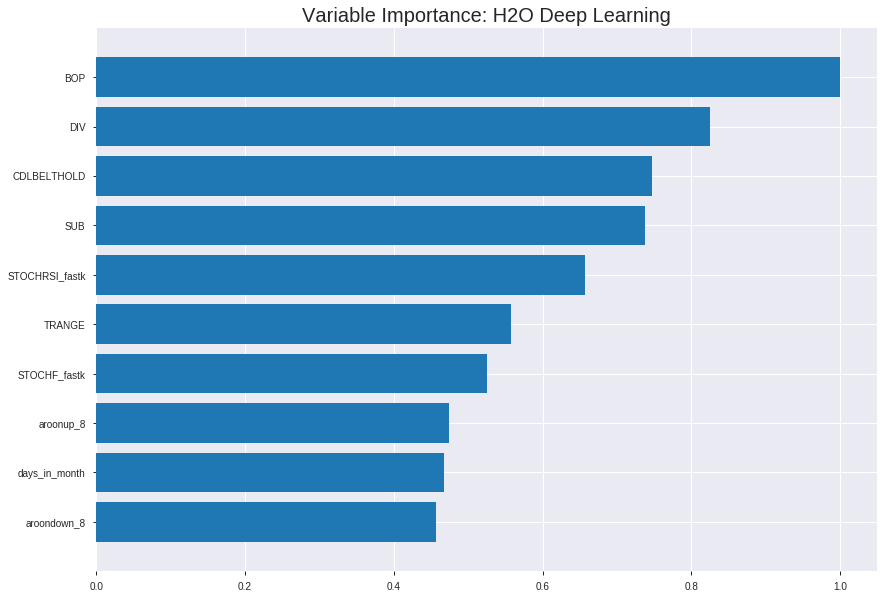

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190823_233944_model_9


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.2448595963758982
RMSE: 0.49483289742689723
LogLoss: 0.6821639921989174
Mean Per-Class Error: 0.4512255334156233
AUC: 0.5585331805090225
pr_auc: 0.6133271775883038
Gini: 0.1170663610180449
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.44191243764215077: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      66   729   0.917    (729.0/795.0)
1      20   836   0.0234   (20.0/856.0)
Total  86   1565  0.4537   (749.0/1651.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.441912     0.690624  313
max f2                       0.32198      0.847038  371
max f0point5                 0.510414     0.593826  193
max accuracy                 0.510414     0.561478  193
max precision                0.561922     1         0
max recall                   0.0685599    1         389
max specificity              0.561922     1         0
max absolute_mcc             0.510414     0.140918  193
max min_per_class_accuracy   0.52169      0.355975  60
max mean_per_class_accuracy  0.51819      0.548774  135

Gains/Lift Table: Avg response rate: 51.85 %, avg score: 50.89 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102968                   0.548989           1.70183   1.70183            0.882353         0.557194  0.882353                    0.557194            0.0175234       0.0175234                  70.1828   70.1828
    2        0.0205936                   0.538614           1.24801   1.47492            0.647059         0.543012  0.764706                    0.550103            0.0128505       0.0303738                  24.8007   47.4918
    3        0.0302847                   0.527914           1.44655   1.46584            0.75             0.532495  0.76                        0.544468            0.0140187       0.0443925                  44.6554   46.5841
    4        0.683828                    0.52169            1.03498   1.05406            0.536608         0.521727  0.546501                    0.522734            0.676402        0.720794                   3.49764   5.40581
    5        0.700182                    0.521285           1.14296   1.05613            0.592593         0.521479  0.547578                    0.522705            0.0186916       0.739486                   14.2956   5.61344
    6        0.800121                    0.518556           1.01697   1.05124            0.527273         0.519963  0.545042                    0.522363            0.101636        0.841121                   1.69711   5.12427
    7        0.900061                    0.500015           0.935146  1.03835            0.484848         0.512398  0.538358                    0.521256            0.0934579       0.934579                   -6.48541  3.83517
    8        1                           0.038032           0.654602  1                  0.339394         0.397218  0.518474                    0.50886             0.0654206       1                          -34.5398  0



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.25092997734215744
RMSE: 0.5009291140891667
LogLoss: 0.695008598784427
Mean Per-Class Error: 0.5
AUC: 0.5
pr_auc: 0.0
Gini: 0.0
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5216898039819772: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    241  1        (241.0/241.0)
1      0    231  0        (0.0/231.0)
Total  0    472  0.5106   (241.0/472.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.52169      0.657183  0
max f2                       0.52169      0.827364  0
max f0point5                 0.52169      0.545068  0
max accuracy                 0.52169      0.489407  0
max precision                0.52169      0.489407  0
max recall                   0.52169      1         0
max specificity              0.52169      0         0
max absolute_mcc             0.52169      0         0
max min_per_class_accuracy   0.52169      0         0
max mean_per_class_accuracy  0.52169      0.5       0

Gains/Lift Table: Avg response rate: 48.94 %, avg score: 52.17 %



group    cumulative_data_fraction    lower_threshold    lift    cumulative_lift    response_rate    score    cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain    cumulative_gain
--  -------  --------------------------  -----------------  ------  -----------------  ---------------  -------  --------------------------  ------------------  --------------  -------------------------  ------  -----------------
    1        1                           0.52169            1       1                  0.489407         0.52169  0.489407                    0.52169             1               1                          0       0


Scoring History: 


timestamp            duration           training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  -----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-24 00:02:50  0.000 sec                            0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-24 00:02:52  6 min 29.053 sec   262 obs/sec       0.366445  1             605        0.661737         1.77606             -0.753979      0.549249        0.58116            1.81528          0.480315                         0.696779           10.8114               -0.942879        0.532297          0.526857             1.22597            0.510593
    2019-08-24 00:03:26  7 min  2.523 sec   402 obs/sec       7.92005   20            13076      0.50021          0.693572            -0.00220699    0.520161        0.538622           1.13455          0.480921                         0.615855           9.99739               -0.517789        0.53368           0.521647             1.22597            0.510593
    2019-08-24 00:03:59  7 min 36.611 sec   439 obs/sec       16.6632   42            27511      0.498822         0.690787            0.00334526     0.521961        0.0629053          1.02269          0.473652                         0.502402           0.697976              -0.0100834       0.5               0                    1                  0.510593
    2019-08-24 00:04:39  8 min 15.433 sec   519 obs/sec       30.8964   78            51010      0.502259         0.697764            -0.0104364     0.515382        0.644664           1.01146          0.471835                         0.507748           0.708944              -0.0316944       0.5               0                    1                  0.510593
    2019-08-24 00:05:11  8 min 47.816 sec   575 obs/sec       44.4022   112           73308      0.498343         0.689768            0.00526015     0.524475        0.602089           1.47492          0.468807                         0.502298           0.697766              -0.00966693      0.5               0                    1                  0.510593
    2019-08-24 00:05:43  9 min 20.128 sec   606 obs/sec       57.5348   145           94990      0.494833         0.682164            0.0192228      0.558533        0.613327           1.70183          0.453664                         0.500929           0.695009              -0.00417065      0.5               0                    1                  0.510593
    2019-08-24 00:06:16  9 min 52.795 sec   610 obs/sec       68.7892   173           113571     0.48936          0.67088             0.0407962      0.622485        0.632533           1.70183          0.437311                         0.500961           0.695072              -0.00429711      0.5               0                    1                  0.510593
    2019-08-24 00:06:48  10 min 25.268 sec  606 obs/sec       79.1187   199           130625     0.480801         0.652459            0.0740584      0.676138        0.677012           1.70183          0.377347                         0.616867           10.074                -0.522783        0.54682           0.536814             0.817316           0.510593
    2019-08-

Variable Importances: 


variable                 relative_importance    scaled_importance    percentage
-----------------------  ---------------------  -------------------  ---------------------
BOP                      1.0                    1.0                  0.0028914063648558157
DIV                      0.8253393769264221     0.8253393769264221   0.0023863915276111903
CDLBELTHOLD              0.7474873065948486     0.7474873065948486   0.002161289555937276
SUB                      0.7371987104415894     0.7371987104415894   0.002131541043534311
STOCHRSI_fastk           0.656789243221283      0.656789243221283    0.001899044598218852
---                      ---                    ---                  ---
BBANDS_middleband_8_2_2  0.2852459251880646     0.2852459251880646   0.0008247618836379558
CDLTASUKIGAP             0.2816338539123535     0.2816338539123535   0.000814317917761052
CDLHARAMI                0.2767021358013153     0.2767021358013153   0.0008000583166251214
CDLMARUBOZU              0.27378934621810913    0.27378934621810913  0.0007916362582847534
CDL3INSIDE               0.27149948477745056    0.27149948477745056  0.0007850153383405953


See the whole table with table.as_data_frame()


('accuracy', 0.461864406779661)

('F1', 0.6318840579710145)

('auc', 0.5)

('logloss', 0.6973996540353721)

('mean_per_class_error', 0.5)

('rmse', 0.5021202591811524)

('mse', 0.25212475468014767)

deeplearning prediction progress: |███████████████████████████████████████| 100%


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


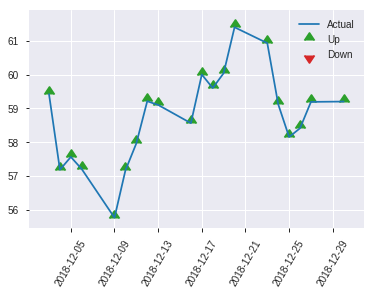


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.25212475468014767
RMSE: 0.5021202591811524
LogLoss: 0.6973996540353721
Mean Per-Class Error: 0.5
AUC: 0.5
pr_auc: 0.0
Gini: 0.0
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5216898039819772: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    127  1        (127.0/127.0)
1      0    109  0        (0.0/109.0)
Total  0    236  0.5381   (127.0/236.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.52169      0.631884  0
max f2                       0.52169      0.811012  0
max f0point5                 0.52169      0.517569  0
max accuracy                 0.52169      0.461864  0
max precision                0.52169      0.461864  0
max recall                   0.52169      1         0
max specificity              0.52169      0         0
max absolute_mcc             0.52169      0         0
max min_per_class_accuracy   0.52169      0         0
max mean_per_class_accuracy  0.52169      0.5       0

Gains/Lift Table: Avg response rate: 46.19 %, avg score: 52.17 %



group    cumulative_data_fraction    lower_threshold    lift    cumulative_lift    response_rate    score    cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain    cumulative_gain
--  -------  --------------------------  -----------------  ------  -----------------  ---------------  -------  --------------------------  ------------------  --------------  -------------------------  ------  -----------------
    1        1                           0.52169            1       1                  0.461864         0.52169  0.461864                    0.52169             1               1                          0       0

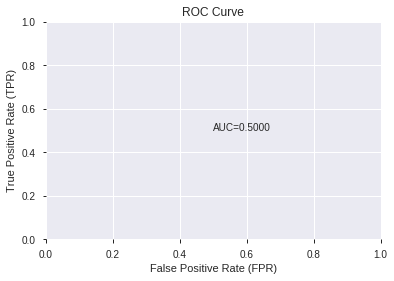

This function is available for GLM models only


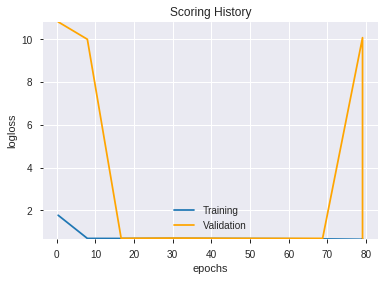

--2019-08-24 00:07:03--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.161.203
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.161.203|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 368257676 (351M) [application/zip]
Saving to: ‘h2o-3.24.0.5.zip’

h2o-3.24.0.5.zip    100%[===================>] 351.20M  19.6MB/s    in 19s     

2019-08-24 00:07:23 (18.6 MB/s) - ‘h2o-3.24.0.5.zip’ saved [368257676/368257676]

Archive:  h2o-3.24.0.5.zip
   creating: h2o-3.24.0.5/
   creating: h2o-3.24.0.5/bindings/
   creating: h2o-3.24.0.5/bindings/java/
 extracting: h2o-3.24.0.5/bindings/java/h2o-bindings-3.24.0.zip  
  inflating: h2o-3.24.0.5/h2o.jar    
   creating: h2o-3.24.0.5/python/
  inflating: h2o-3.24.0.5/python/h2o-3.24.0.5-py2.py3-none-any.whl  
   creating: h2o-3.24.0.5/R/
  inflating: h2o-3.24.0.5/R/h2o_3.24.0.5.tar.gz  
ERROR: U

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190823_233944_model_9',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190823_233944_model_9',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_2_sid_9850',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl

In [10]:
# DeepLearning
features_list = model_train(feature_name='All',model_algo="DeepLearning")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190824_000737_model_8  0.680633  0.648256              0.341797  0.477593  0.228095
1  DeepLearning_grid_1_AutoML_20190824_000737_model_6  0.674204  0.660795              0.369356  0.481868  0.232197
2  DeepLearning_grid_1_AutoML_20190824_000737_model_9  0.666691  0.645719              0.341075  0.476622  0.227169
3  DeepLearning_grid_1_AutoML_20190824_000737_model_3  0.661128  0.809112              0.352308  0.510254  0.260360
4  DeepLearning_grid_1_AutoML_20190824_000737_model_4  0.655205  0.762325              0.420574  0.506224  0.256263
5  DeepLearning_grid_1_AutoML_20190824_000737_model_5  0.652315  0.656553              0.410063  0.481672  0.232008
6  DeepLearning_grid_1_AutoML_20190824_000737_model_2  0.646030  0.799435              0.421874  0.520080  0.270483
7  DeepLearning_grid_1_AutoML_20190824_000737_model_1  0.637868  1.121672              0.423824  0.558733  0.312183
8  DeepLearning_grid_1_AutoML_20190824_000737_model_7  0.630788  0.814289              0.394315  0.523428  0.273977
9               DeepLearning_1_AutoML_20190824_000737  0.626093  0.854441              0.384454  0.530121  0.281029

variable  relative_importance  scaled_importance  percentage
0                 DIV             1.000000           1.000000    0.034142
1                 BOP             0.991689           0.991689    0.033858
2                 SUB             0.951158           0.951158    0.032474
3         CDLBELTHOLD             0.870605           0.870605    0.029724
4           aroonup_8             0.696807           0.696807    0.023790
5              TRANGE             0.684385           0.684385    0.023366
6                 SIN             0.656252           0.656252    0.022406
7      STOCHRSI_fastk             0.650211           0.650211    0.022199
8                  AD             0.606412           0.606412    0.020704
9             BETA_20             0.604225           0.604225    0.020629
10             ADX_14             0.597953           0.597953    0.020415
11       aroondown_30             0.597266           0.597266    0.020392
12             SAREXT             0.586373           0.586373    0.020020
13          dayofweek             0.583737           0.583737    0.019930
14            BETA_14             0.581278           0.581278    0.019846
15             ADX_12             0.579580           0.579580    0.019788
16             ULTOSC             0.574085           0.574085    0.019600
17        STOCH_slowd             0.572969           0.572969    0.019562
18        aroondown_8             0.569332           0.569332    0.019438
19          CORREL_12             0.568535           0.568535    0.019411
20       HT_TRENDMODE             0.568412           0.568412    0.019407
21       aroondown_12             0.562445           0.562445    0.019203
22           CORREL_8             0.561929           0.561929    0.019185
23      days_in_month             0.560538           0.560538    0.019138
24            CDLDOJI             0.556840           0.556840    0.019012
25             CCI_14             0.548207           0.548207    0.018717
26            quarter             0.547887           0.547887    0.018706
27             ROC_12             0.545565           0.545565    0.018627
28          dayofyear             0.544829           0.544829    0.018601
29            weekday             0.544772           0.544772    0.018600
30          CORREL_14             0.544717           0.544717    0.018598
31         MINUS_DI_8             0.538879           0.538879    0.018398
32          STDDEV_30             0.535876           0.535876    0.018296
33           WILLR_24             0.534636           0.534636    0.018253
34  CDLLONGLEGGEDDOJI             0.533087           0.533087    0.018201
35       aroondown_14             0.529516           0.529516    0.018079
36              month             0.521196           0.521196    0.017795
37       STOCHF_fastk             0.517527           0.517527    0.017669
38              CMO_8             0.510739           0.510739    0.017438
39               week             0.510698           0.510698    0.017436
40         ROCR100_12             0.508398           0.508398    0.017358
41             RSI_14             0.499873           0.499873    0.017067
42              CCI_8             0.499656           0.499656    0.017059
43            ROCP_12             0.499109           0.499109    0.017041
44            WILLR_8             0.498109           0.498109    0.017006
45           WILLR_12             0.495794           0.495794    0.016927
46            ROCR_12             0.493298           0.493298    0.016842
47              RSI_8             0.490576           0.490576    0.016749
48         weekofyear             0.482574           0.482574    0.016476
49           WILLR_14             0.481014           0.481014    0.016423

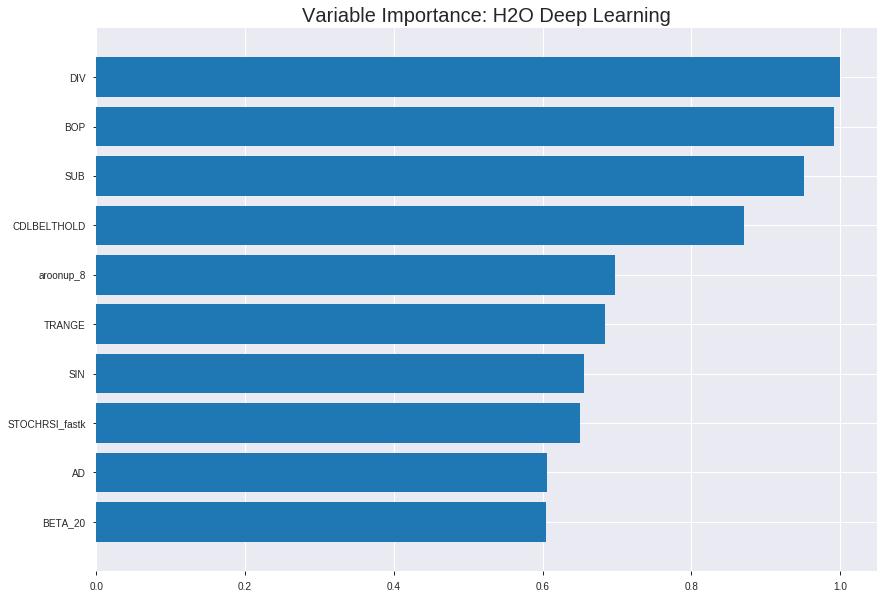

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190824_000737_model_8


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.23124655582472078
RMSE: 0.480881020445516
LogLoss: 0.6539289038882518
Mean Per-Class Error: 0.35850966907658854
AUC: 0.6962352318815024
pr_auc: 0.6834353967762836
Gini: 0.39247046376300476
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5554380150923424: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      254  541   0.6805   (541.0/795.0)
1      50   806   0.0584   (50.0/856.0)
Total  304  1347  0.358    (591.0/1651.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.555438     0.731729  199
max f2                       0.461696     0.853037  274
max f0point5                 0.611286     0.653607  132
max accuracy                 0.611286     0.646881  132
max precision                0.695223     1         0
max recall                   0.255336     1         368
max specificity              0.695223     1         0
max absolute_mcc             0.555438     0.336576  199
max min_per_class_accuracy   0.617963     0.627336  110
max mean_per_class_accuracy  0.611286     0.64149   132

Gains/Lift Table: Avg response rate: 51.85 %, avg score: 58.34 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102968                   0.658521           1.81528   1.81528            0.941176         0.667292  0.941176                    0.667292            0.0186916       0.0186916                  81.5283   81.5283
    2        0.0205936                   0.653127           1.70183   1.75856            0.882353         0.655023  0.911765                    0.661157            0.0175234       0.036215                   70.1828   75.8556
    3        0.0302847                   0.648789           1.32601   1.62014            0.6875           0.65084   0.84                        0.657856            0.0128505       0.0490654                  32.6008   62.014
    4        0.0405815                   0.64667            1.36146   1.55451            0.705882         0.647524  0.80597                     0.655234            0.0140187       0.0630841                  36.1462   55.4506
    5        0.0502726                   0.645121           1.44655   1.5337             0.75             0.645776  0.795181                    0.653411            0.0140187       0.0771028                  44.6554   53.3696
    6        0.100545                    0.6391             1.34779   1.44074            0.698795         0.641872  0.746988                    0.647642            0.067757        0.14486                    34.7793   44.0744
    7        0.150212                    0.635414           1.31719   1.39989            0.682927         0.637282  0.725806                    0.644216            0.0654206       0.21028                    31.7187   39.9891
    8        0.200485                    0.631409           1.34779   1.38683            0.698795         0.633343  0.719033                    0.64149             0.067757        0.278037                   34.7793   38.6827
    9        0.300424                    0.626503           1.23907   1.33767            0.642424         0.628941  0.693548                    0.637315            0.123832        0.401869                   23.9068   33.7673
    10       0.400363                    0.621938           1.18062   1.29847            0.612121         0.624153  0.673222                    0.63403             0.117991        0.51986                    18.0622   29.847
    11       0.500303                    0.61795            1.02866   1.24457            0.533333         0.619877  0.645278                    0.631203            0.102804        0.622664                   2.86604   24.4573
    12       0.600242                    0.613672           1.08711   1.21836            0.563636         0.615707  0.631685                    0.628623            0.108645        0.731308                   8.71071   21.8355
    13       0.700182                    0.608112           1.00528   1.18794            0.521212         0.611265  0.615917                    0.626145            0.100467        0.831776                   0.528179  18.7943
    14       0.800121                    0.570662           0.923457  1.15491            0.478788         0.596576  0.598789                    0.622452            0.0922897       0.924065                   -7.65435  15.4907
    15       0.900061                    0.457982           0.537709  1.08638            0.278788         0.516551  0.563257                    0.610693            0.0537383       0.977804                   -46.2291  8.63755
    16       1                           0.042488           0.222097  1                  0.115152         0.337623  0.518474                    0.583402           



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.24763423631909728
RMSE: 0.49762861284204435
LogLoss: 0.6899111080274144
Mean Per-Class Error: 0.4121176195864993
AUC: 0.5905049307538933
pr_auc: 0.560488941519418
Gini: 0.18100986150778664
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.271678245860766: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      19   222  0.9212   (222.0/241.0)
1      6    225  0.026    (6.0/231.0)
Total  25   447  0.4831   (228.0/472.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.271678     0.663717  374
max f2                       0.0696077    0.827364  399
max f0point5                 0.589493     0.585803  236
max accuracy                 0.589493     0.584746  236
max precision                0.642672     0.857143  20
max recall                   0.0696077    1         399
max specificity              0.680207     0.995851  0
max absolute_mcc             0.561738     0.184319  260
max min_per_class_accuracy   0.611201     0.5671    178
max mean_per_class_accuracy  0.589493     0.587882  236

Gains/Lift Table: Avg response rate: 48.94 %, avg score: 54.74 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105932                   0.656708           1.22597   1.22597            0.6              0.667617  0.6                         0.667617            0.012987        0.012987                   22.5974   22.5974
    2        0.0211864                   0.650428           2.04329   1.63463            1                0.653277  0.8                         0.660447            0.021645        0.034632                   104.329   63.4632
    3        0.0317797                   0.645177           1.63463   1.63463            0.8              0.647297  0.8                         0.656064            0.017316        0.0519481                  63.4632   63.4632
    4        0.0402542                   0.642769           2.04329   1.72067            1                0.643834  0.842105                    0.653489            0.017316        0.0692641                  104.329   72.0665
    5        0.0508475                   0.639699           1.22597   1.6176             0.6              0.641258  0.791667                    0.650941            0.012987        0.0822511                  22.5974   61.7605
    6        0.101695                    0.633472           0.59596   1.10678            0.291667         0.635621  0.541667                    0.643281            0.030303        0.112554                   -40.404   10.6782
    7        0.150424                    0.629368           1.24374   1.15115            0.608696         0.631462  0.56338                     0.639452            0.0606061       0.17316                    24.3742   15.1149
    8        0.201271                    0.625702           1.10678   1.13994            0.541667         0.627522  0.557895                    0.636438            0.0562771       0.229437                   10.6782   13.9941
    9        0.300847                    0.620386           1.08686   1.12237            0.531915         0.622712  0.549296                    0.631895            0.108225        0.337662                   8.68564   12.2371
    10       0.400424                    0.615487           1.13033   1.12435            0.553191         0.617474  0.550265                    0.628309            0.112554        0.450216                   13.0331   12.435
    11       0.5                         0.61108            1.1738    1.1342             0.574468         0.612857  0.555085                    0.625232            0.116883        0.5671                     17.3805   13.4199
    12       0.599576                    0.601832           1.08686   1.12634            0.531915         0.608119  0.551237                    0.62239             0.108225        0.675325                   8.68564   12.6337
    13       0.699153                    0.560158           1.08686   1.12071            0.531915         0.586143  0.548485                    0.617227            0.108225        0.78355                    8.68564   12.0714
    14       0.798729                    0.4645             0.826011  1.08397            0.404255         0.505047  0.530504                    0.603242            0.0822511       0.865801                   -17.3989  8.39735
    15       0.898305                    0.328546           0.695588  1.04092            0.340426         0.406055  0.509434                    0.581384            0.0692641       0.935065                   -30.4412  4.09213
    16       1                           0.0696077          0.638528  1                  0.3125           0.24747   0.489407                    0.547427          


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-24 00:13:46  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-24 00:13:48  1 min 23.558 sec  622 obs/sec       0.712296  1             1176       0.511725         0.721295            -0.0488827     0.602147        0.602474           1.81528          0.436099                         0.525469           0.75365               -0.104967        0.562914          0.535185             1.22597            0.510593
    2019-08-24 00:14:02  1 min 37.513 sec  922 obs/sec       8.12477   11            13414      0.480881         0.653929            0.0737493      0.696235        0.683435           1.81528          0.357965                         0.497629           0.689911              0.00901824       0.590505          0.560489             1.22597            0.483051
    2019-08-24 00:14:16  1 min 51.407 sec  991 obs/sec       16.3095   22            26927      0.463558         0.617509            0.139281       0.708635        0.703236           1.92874          0.348879                         0.496754           0.694372              0.0124974        0.604327          0.560613             0.408658           0.430085
    2019-08-24 00:14:29  2 min  4.760 sec  1091 obs/sec      25.9164   35            42788      0.452707         0.591869            0.179105       0.743415        0.743108           1.92874          0.314961                         0.49899            0.711556              0.00358673       0.616075          0.570352             1.22597            0.408898
    2019-08-24 00:14:42  2 min 17.779 sec  1153 obs/sec      35.5881   48            58756      0.434577         0.552573            0.243539       0.771326        0.77249            1.92874          0.29255                          0.508585           0.751415              -0.035101        0.607408          0.560407             1.22597            0.42161
    2019-08-24 00:14:55  2 min 31.220 sec  1205 obs/sec      46.0594   62            76044      0.42203          0.522218            0.286589       0.789622        0.789466           1.92874          0.276196                         0.519654           0.819269              -0.0806464       0.603869          0.560516             1.22597            0.440678
    2019-08-24 00:14:57  2 min 32.753 sec  1204 obs/sec      46.0594   62            76044      0.480881         0.653929            0.0737493      0.696235        0.683435           1.81528          0.357965                         0.497629           0.689911              0.00901824       0.590505          0.560489             1.22597            0.483051

Variable Importances: 


variable     relative_importance    scaled_importance    percentage
-----------  ---------------------  -------------------  --------------------
DIV          1.0                    1.0                  0.03414187355985794
BOP          0.9916885495185852     0.9916885495185852   0.033858105068422455
SUB          0.9511579275131226     0.9511579275131226   0.03247431369660955
CDLBELTHOLD  0.8706047534942627     0.8706047534942627   0.029724077414412405
aroonup_8    0.6968066692352295     0.6968066692352295   0.023790285196694957
---          ---                    ---                  ---
WILLR_12     0.4957939386367798     0.4957939386367798   0.0169273339646809
ROCR_12      0.49329811334609985    0.49329811334609985  0.016842121813179012
RSI_8        0.4905756115913391     0.4905756115913391   0.01674917050250148
weekofyear   0.4825739562511444     0.4825739562511444   0.01647597899760699
WILLR_14     0.48101386427879333    0.48101386427879333  0.01642271453474523


See the whole table with table.as_data_frame()


('accuracy', 0.6398305084745762)

('F1', 0.6975088967971531)

('auc', 0.6806328108069061)

('logloss', 0.6482556757174951)

('mean_per_class_error', 0.3417972982734956)

('rmse', 0.4775929753229706)

('mse', 0.2280950500778476)

deeplearning prediction progress: |███████████████████████████████████████| 100%


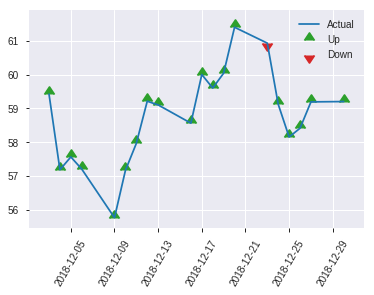


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.2280950500778476
RMSE: 0.4775929753229706
LogLoss: 0.6482556757174951
Mean Per-Class Error: 0.3417972982734956
AUC: 0.6806328108069061
pr_auc: 0.6140845979435376
Gini: 0.36126562161381215
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4680324184048401: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      53   74   0.5827   (74.0/127.0)
1      11   98   0.1009   (11.0/109.0)
Total  64   172  0.3602   (85.0/236.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.468032     0.697509  171
max f2                       0.207333     0.816794  218
max f0point5                 0.468032     0.614806  171
max accuracy                 0.485342     0.639831  167
max precision                0.670865     1         0
max recall                   0.0590604    1         233
max specificity              0.670865     1         0
max absolute_mcc             0.468032     0.354817  171
max min_per_class_accuracy   0.609828     0.622047  115
max mean_per_class_accuracy  0.468032     0.658203  171

Gains/Lift Table: Avg response rate: 46.19 %, avg score: 52.10 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0127119                   0.658454           2.16514   2.16514            1                0.66585   1                           0.66585             0.0275229       0.0275229                  116.514    116.514
    2        0.0211864                   0.652226           1.08257   1.73211            0.5              0.656054  0.8                         0.661931            0.00917431      0.0366972                  8.25688    73.211
    3        0.0338983                   0.650416           1.44343   1.62385            0.666667         0.650916  0.75                        0.657801            0.0183486       0.0550459                  44.3425    62.3853
    4        0.0423729                   0.647506           1.08257   1.5156             0.5              0.648906  0.7                         0.656022            0.00917431      0.0642202                  8.25688    51.5596
    5        0.0508475                   0.644366           1.08257   1.44343            0.5              0.646045  0.666667                    0.654359            0.00917431      0.0733945                  8.25688    44.3425
    6        0.101695                    0.639285           1.263     1.35321            0.583333         0.641981  0.625                       0.64817             0.0642202       0.137615                   26.2997    35.3211
    7        0.152542                    0.63617            1.44343   1.38328            0.666667         0.637724  0.638889                    0.644688            0.0733945       0.211009                   44.3425    38.3282
    8        0.20339                     0.631449           1.80428   1.48853            0.833333         0.633548  0.6875                      0.641903            0.0917431       0.302752                   80.4281    48.8532
    9        0.300847                    0.624507           1.22377   1.40277            0.565217         0.627537  0.647887                    0.637249            0.119266        0.422018                   22.3773    40.2765
    10       0.402542                    0.615205           0.992355  1.29908            0.458333         0.619274  0.6                         0.632708            0.100917        0.522936                   -0.764526  29.9083
    11       0.5                         0.608902           1.12964   1.26606            0.521739         0.612372  0.584746                    0.628744            0.110092        0.633028                   12.9637    26.6055
    12       0.601695                    0.576909           0.811927  1.1893             0.375            0.596308  0.549296                    0.623262            0.0825688       0.715596                   -18.8073   18.9301
    13       0.699153                    0.496875           1.41205   1.22035            0.652174         0.545064  0.563636                    0.612362            0.137615        0.853211                   41.2046    22.035
    14       0.800847                    0.383474           0.541284  1.13412            0.25             0.438973  0.52381                     0.590344            0.0550459       0.908257                   -45.8716   13.412
    15       0.898305                    0.275138           0.470682  1.06214            0.217391         0.330422  0.490566                    0.562145            0.0458716       0.954128                   -52.9318   6.2143
    16       1                           0.017551           0.45107   1                  0.208333         0.157942  0.461864                    0.52

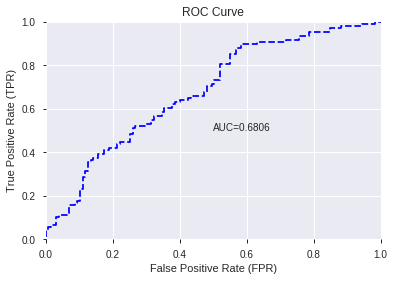

This function is available for GLM models only


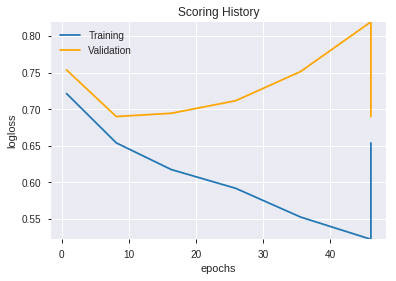

--2019-08-24 00:16:30--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.186.195
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.186.195|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190824_000737_model_8',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190824_000737_model_8',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_10_sid_9850',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['DIV',
 'BOP',
 'SUB',
 'CDLBELTHOLD',
 'aroonup_8',
 'TRANGE',
 'SIN',
 'STOCHRSI_fastk',
 'AD',
 'BETA_20',
 'ADX_14',
 'aroondown_30',
 'SAREXT',
 'dayofweek',
 'BETA_14',
 'ADX_12',
 'ULTOSC',
 'STOCH_slowd',
 'aroondown_8',
 'CORREL_12',
 'HT_TRENDMODE',
 'aroondown_12',
 'CORREL_8',
 'days_in_month',
 'CDLDOJI',
 'CCI_14',
 'quarter',
 'ROC_12',
 'dayofyear',
 'weekday',
 'CORREL_14',
 'MINUS_DI_8',
 'STDDEV_30',
 'WILLR_24',
 'CDLLONGLEGGEDDOJI',
 'aroondown_14',
 'month',
 'STOCHF_fastk',
 'CMO_8',
 'week',
 'ROCR100_12',
 'RSI_14',
 'CCI_8',
 'ROCP_12',
 'WILLR_8',
 'WILLR_12',
 'ROCR_12',
 'RSI_8',
 'weekofyear',
 'WILLR_14']

In [11]:
# DeepLearning with top DeepLearning features
model_train(feature_name='DLF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id      auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190824_001638_model_1  0.64827  0.656926              0.364697  0.482132  0.232451

variable  relative_importance  scaled_importance  percentage
0                 BOP             0.118962           1.000000    0.107909
1                 SUB             0.111213           0.934859    0.100880
2         CDLBELTHOLD             0.105724           0.888719    0.095901
3                 DIV             0.093631           0.787067    0.084932
4           aroonup_8             0.051237           0.430697    0.046476
5         aroondown_8             0.039873           0.335170    0.036168
6                  AD             0.039346           0.330747    0.035691
7      STOCHRSI_fastk             0.039282           0.330203    0.035632
8         STOCH_slowd             0.035050           0.294634    0.031794
9              TRANGE             0.030937           0.260061    0.028063
10       aroondown_12             0.024419           0.205270    0.022150
11       STOCHF_fastk             0.024194           0.203380    0.021947
12      days_in_month             0.023274           0.195643    0.021112
13  CDLLONGLEGGEDDOJI             0.022489           0.189045    0.020400
14          STDDEV_30             0.021933           0.184369    0.019895
15            CDLDOJI             0.021300           0.179048    0.019321
16       HT_TRENDMODE             0.020276           0.170441    0.018392
17             ULTOSC             0.019132           0.160827    0.017355
18            WILLR_8             0.018103           0.152173    0.016421
19          CORREL_12             0.017898           0.150453    0.016235
20          CORREL_14             0.017375           0.146057    0.015761
21              CCI_8             0.016419           0.138018    0.014893
22       aroondown_30             0.012441           0.104581    0.011285
23            BETA_14             0.011763           0.098878    0.010670
24           WILLR_24             0.010966           0.092182    0.009947
25             ROC_12             0.010875           0.091415    0.009864
26            ROCP_12             0.010864           0.091321    0.009854
27            ROCR_12             0.010834           0.091071    0.009827
28         ROCR100_12             0.010811           0.090874    0.009806
29       aroondown_14             0.010794           0.090735    0.009791
30             ADX_14             0.010766           0.090501    0.009766
31           WILLR_12             0.009775           0.082173    0.008867
32           WILLR_14             0.008792           0.073907    0.007975
33            quarter             0.008515           0.071575    0.007724
34             ADX_12             0.008243           0.069292    0.007477
35              month             0.007289           0.061271    0.006612
36          dayofyear             0.006158           0.051766    0.005586
37              RSI_8             0.005530           0.046489    0.005017
38              CMO_8             0.005506           0.046284    0.004995
39                SIN             0.005270           0.044302    0.004781
40             RSI_14             0.004831           0.040610    0.004382
41            weekday             0.003761           0.031613    0.003411
42          dayofweek             0.003753           0.031549    0.003404
43         MINUS_DI_8             0.003652           0.030701    0.003313
44           CORREL_8             0.003382           0.028427    0.003068
45            BETA_20             0.002490           0.020930    0.002259
46             CCI_14             0.002092           0.017587    0.001898
47             SAREXT             0.000434           0.003648    0.000394
48         weekofyear             0.000387           0.003252    0.000351
49               week             0.000386           0.003248    0.000350

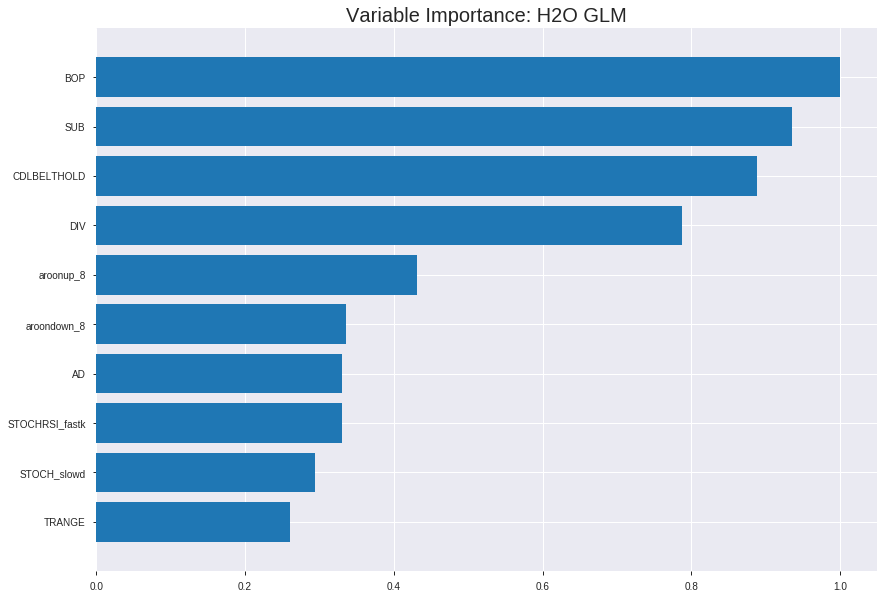

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190824_001638_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.22950047037445742
RMSE: 0.47906207361307307
LogLoss: 0.6510885381437406
Null degrees of freedom: 1650
Residual degrees of freedom: 1600
Null deviance: 2286.517691569208
Residual deviance: 2149.8943529506314
AIC: 2251.8943529506314
AUC: 0.672539381649327
pr_auc: 0.6509944551366478
Gini: 0.34507876329865406
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.44312864435755595: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      241  554   0.6969   (554.0/795.0)
1      69   787   0.0806   (69.0/856.0)
Total  310  1341  0.3773   (623.0/1651.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.443129     0.716431  276
max f2                       0.344875     0.84637   349
max f0point5                 0.517993     0.648345  190
max accuracy                 0.517993     0.637795  190
max precision                0.868461     1         0
max recall                   0.207613     1         395
max specificity              0.868461     1         0
max absolute_mcc             0.446635     0.286313  272
max min_per_class_accuracy   0.533142     0.622664  169
max mean_per_class_accuracy  0.517993     0.63488   190

Gains/Lift Table: Avg response rate: 51.85 %, avg score: 51.85 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102968                   0.672166           1.47492   1.47492            0.764706         0.702368  0.764706                    0.702368            0.0151869       0.0151869                  47.4918   47.4918
    2        0.0205936                   0.6627             1.24801   1.36146            0.647059         0.665996  0.705882                    0.684182            0.0128505       0.0280374                  24.8007   36.1462
    3        0.0302847                   0.654747           1.32601   1.35012            0.6875           0.659751  0.7                         0.676364            0.0128505       0.0408879                  32.6008   35.0117
    4        0.0405815                   0.643622           1.47492   1.38178            0.764706         0.648627  0.716418                    0.669326            0.0151869       0.0560748                  47.4918   38.1783
    5        0.0502726                   0.638318           1.08492   1.32456            0.5625           0.640807  0.686747                    0.663828            0.010514        0.0665888                  8.49153   32.4555
    6        0.100545                    0.619697           1.39427   1.35941            0.722892         0.627156  0.704819                    0.645492            0.0700935       0.136682                   39.4269   35.9412
    7        0.150212                    0.605721           1.29367   1.33767            0.670732         0.611233  0.693548                    0.634164            0.0642523       0.200935                   29.3666   33.7673
    8        0.200485                    0.593146           1.2316    1.31108            0.638554         0.598861  0.679758                    0.625312            0.0619159       0.26285                    23.1604   31.1076
    9        0.300424                    0.574066           1.28583   1.30268            0.666667         0.583868  0.675403                    0.611525            0.128505        0.391355                   28.5826   30.2676
    10       0.400363                    0.554543           1.12218   1.25762            0.581818         0.564237  0.652042                    0.599721            0.11215         0.503505                   12.2175   25.7619
    11       0.500303                    0.533349           1.18062   1.24224            0.612121         0.543844  0.644068                    0.588559            0.117991        0.621495                   18.0622   24.2238
    12       0.600242                    0.514468           1.01697   1.20473            0.527273         0.523029  0.624622                    0.577648            0.101636        0.723131                   1.69711   20.4732
    13       0.700182                    0.485015           0.935146  1.16625            0.484848         0.500256  0.604671                    0.566602            0.0934579       0.816589                   -6.48541  16.6253
    14       0.800121                    0.447333           0.923457  1.13593            0.478788         0.467502  0.588948                    0.554224            0.0922897       0.908879                   -7.65435  13.5926
    15       0.900061                    0.388394           0.607845  1.07729            0.315152         0.421835  0.558546                    0.539524            0.0607477       0.969626                   -39.2155  7.72899
    16       1                           0.130762           0.303922  1                  0.157576         0.328894  0.518474                    0.518474         



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.24151918629529243
RMSE: 0.4914460156469807
LogLoss: 0.6758725424574449
Null degrees of freedom: 471
Residual degrees of freedom: 421
Null deviance: 655.7149900197271
Residual deviance: 638.023680079828
AIC: 740.023680079828
AUC: 0.5959655835174508
pr_auc: 0.5592357540473876
Gini: 0.19193116703490154
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3758377764654808: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      48   193  0.8008   (193.0/241.0)
1      16   215  0.0693   (16.0/231.0)
Total  64   408  0.4428   (209.0/472.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.375838     0.672926  343
max f2                       0.294468     0.830925  388
max f0point5                 0.481352     0.59176   229
max accuracy                 0.481352     0.595339  229
max precision                0.716943     1         0
max recall                   0.185794     1         399
max specificity              0.716943     1         0
max absolute_mcc             0.481352     0.197165  229
max min_per_class_accuracy   0.50324      0.571429  192
max mean_per_class_accuracy  0.481352     0.597178  229

Gains/Lift Table: Avg response rate: 48.94 %, avg score: 48.72 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105932                   0.662139           1.63463   1.63463            0.8              0.6786    0.8                         0.6786              0.017316        0.017316                   63.4632   63.4632
    2        0.0211864                   0.645013           1.22597   1.4303             0.6              0.656462  0.7                         0.667531            0.012987        0.030303                   22.5974   43.0303
    3        0.0317797                   0.634196           1.22597   1.36219            0.6              0.640078  0.666667                    0.65838             0.012987        0.04329                    22.5974   36.2193
    4        0.0402542                   0.619289           1.53247   1.39804            0.75             0.626827  0.684211                    0.651737            0.012987        0.0562771                  53.2468   39.8041
    5        0.0508475                   0.613969           0.817316  1.27706            0.4              0.616562  0.625                       0.644409            0.00865801      0.0649351                  -18.2684  27.7056
    6        0.101695                    0.592955           0.936508  1.10678            0.458333         0.599959  0.541667                    0.622184            0.047619        0.112554                   -6.34921  10.6782
    7        0.150424                    0.577896           1.42142   1.20871            0.695652         0.584465  0.591549                    0.609965            0.0692641       0.181818                   42.1419   20.8707
    8        0.201271                    0.564431           1.10678   1.18296            0.541667         0.572433  0.578947                    0.600483            0.0562771       0.238095                   10.6782   18.2957
    9        0.300847                    0.53987            0.739062  1.03603            0.361702         0.553009  0.507042                    0.58477             0.0735931       0.311688                   -26.0938  3.60344
    10       0.400424                    0.523228           1.43465   1.13516            0.702128         0.530758  0.555556                    0.571338            0.142857        0.454545                   43.465    13.5161
    11       0.5                         0.502184           1.1738    1.14286            0.574468         0.513122  0.559322                    0.559745            0.116883        0.571429                   17.3805   14.2857
    12       0.599576                    0.474484           1.21728   1.15522            0.595745         0.490542  0.565371                    0.548251            0.121212        0.692641                   21.7279   15.5217
    13       0.699153                    0.44749            0.826011  1.10833            0.404255         0.461671  0.542424                    0.53592             0.0822511       0.774892                   -17.3989  10.833
    14       0.798729                    0.40187            0.912959  1.08397            0.446809         0.423282  0.530504                    0.521878            0.0909091       0.865801                   -8.70406  8.39735
    15       0.898305                    0.358757           0.826011  1.05538            0.404255         0.383603  0.516509                    0.50655             0.0822511       0.948052                   -17.3989  5.53786
    16       1                           0.185794           0.510823  1                  0.25             0.315918  0.489407                    0.487164          


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-24 00:16:38  0.000 sec   2            11        51            1.37319           1.38227
    2019-08-24 00:16:38  0.065 sec   4            6.8       51            1.36781           1.37907
    2019-08-24 00:16:39  0.119 sec   6            4.2       51            1.36067           1.37483
    2019-08-24 00:16:39  0.150 sec   8            2.6       51            1.35156           1.36955
    2019-08-24 00:16:39  0.180 sec   10           1.6       51            1.34048           1.36355
    2019-08-24 00:16:39  0.199 sec   12           1         51            1.32787           1.35771
    2019-08-24 00:16:39  0.216 sec   14           0.63      51            1.31471           1.35338
    2019-08-24 00:16:39  0.232 sec   16           0.39      51            1.30218           1.35175
    2019-08-24 00:16:39  0.246 sec   18           0.24      51            1.29134           1.35332
    2019-08-24 00:16:39  0.264 sec   20           0.15      51            1.28278           1.3577
    2019-08-24 00:16:39  0.279 sec   22           0.093     51            1.27655           1.36385
    2019-08-24 00:16:39  0.298 sec   24           0.058     51            1.27231           1.37053
    2019-08-24 00:16:39  0.313 sec   26           0.036     51            1.26955           1.37676

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6271186440677966)

('F1', 0.6615969581749049)

('auc', 0.6482698836957307)

('logloss', 0.656925599929704)

('mean_per_class_error', 0.3646969587517157)

('rmse', 0.48213175861373814)

('mse', 0.23245103266397585)

glm prediction progress: |████████████████████████████████████████████████| 100%


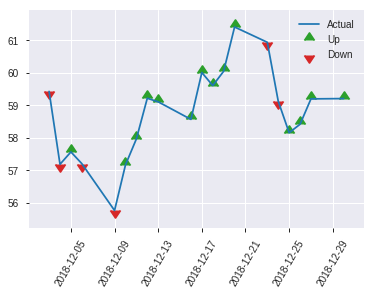


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.23245103266397585
RMSE: 0.48213175861373814
LogLoss: 0.656925599929704
Null degrees of freedom: 235
Residual degrees of freedom: 185
Null deviance: 328.8185624091997
Residual deviance: 310.06888316682034
AIC: 412.06888316682034
AUC: 0.6482698836957307
pr_auc: 0.5651495856834269
Gini: 0.2965397673914614
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.42239516897960466: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      60   67   0.5276   (67.0/127.0)
1      22   87   0.2018   (22.0/109.0)
Total  82   154  0.3771   (89.0/236.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.422395     0.661597  153
max f2                       0.243821     0.81571   225
max f0point5                 0.446377     0.601504  138
max accuracy                 0.446377     0.627119  138
max precision                0.677302     1         0
max recall                   0.108328     1         233
max specificity              0.677302     1         0
max absolute_mcc             0.422395     0.283325  153
max min_per_class_accuracy   0.481198     0.59633   112
max mean_per_class_accuracy  0.422395     0.635303  153

Gains/Lift Table: Avg response rate: 46.19 %, avg score: 45.94 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0127119                   0.625323           1.44343   1.44343            0.666667         0.64694   0.666667                    0.64694             0.0183486       0.0183486                  44.3425    44.3425
    2        0.0211864                   0.622717           1.08257   1.29908            0.5              0.624078  0.6                         0.637795            0.00917431      0.0275229                  8.25688    29.9083
    3        0.0338983                   0.61347            0         0.811927           0                0.618032  0.375                       0.630384            0               0.0275229                  -100       -18.8073
    4        0.0423729                   0.609037           2.16514   1.08257            1                0.612118  0.5                         0.626731            0.0183486       0.0458716                  116.514    8.25688
    5        0.0508475                   0.601769           0         0.902141           0                0.604897  0.416667                    0.623092            0               0.0458716                  -100       -9.78593
    6        0.101695                    0.58298            1.62385   1.263              0.75             0.595491  0.583333                    0.609292            0.0825688       0.12844                    62.3853    26.2997
    7        0.152542                    0.569169           1.44343   1.32314            0.666667         0.575788  0.611111                    0.598124            0.0733945       0.201835                   44.3425    32.314
    8        0.20339                     0.556287           1.62385   1.39832            0.75             0.563873  0.645833                    0.589561            0.0825688       0.284404                   62.3853    39.8318
    9        0.300847                    0.525878           1.12964   1.31128            0.521739         0.543844  0.605634                    0.574751            0.110092        0.394495                   12.9637    31.1281
    10       0.402542                    0.503298           0.992355  1.23071            0.458333         0.514443  0.568421                    0.559515            0.100917        0.495413                   -0.764526  23.071
    11       0.5                         0.473322           1.12964   1.21101            0.521739         0.490024  0.559322                    0.545971            0.110092        0.605505                   12.9637    21.1009
    12       0.601695                    0.442988           1.35321   1.23504            0.625            0.457978  0.570423                    0.531099            0.137615        0.743119                   35.3211    23.5043
    13       0.699153                    0.409697           0.753091  1.16786            0.347826         0.425863  0.539394                    0.516429            0.0733945       0.816514                   -24.6909   16.7862
    14       0.800847                    0.374154           0.541284  1.0883             0.25             0.39486   0.502646                    0.500992            0.0550459       0.87156                    -45.8716   8.82967
    15       0.898305                    0.323055           0.941364  1.07236            0.434783         0.353178  0.495283                    0.484956            0.0917431       0.963303                   -5.86358   7.23559
    16       1                           0.0424585          0.360856  1                  0.166667         0.233334  0.461864                    

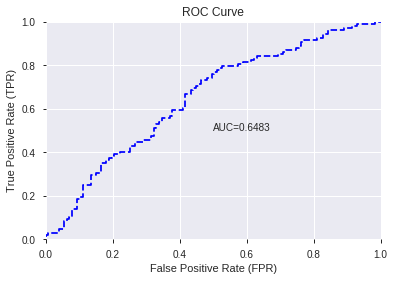

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


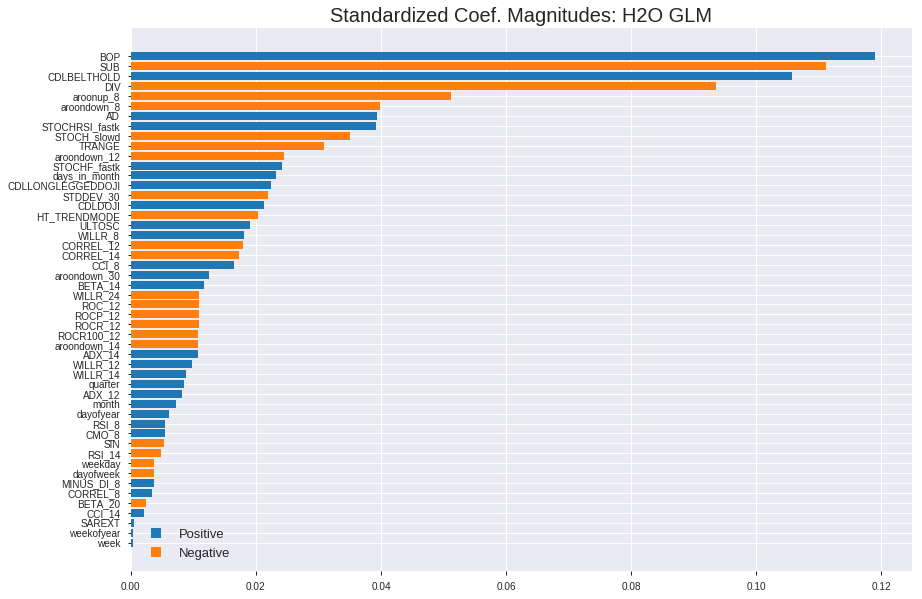

'log_likelihood'
--2019-08-24 00:16:45--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.164.163
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.164.163|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190824_001638_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190824_001638_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_18_sid_9850',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_18_s

['BOP',
 'SUB',
 'CDLBELTHOLD',
 'DIV',
 'aroonup_8',
 'aroondown_8',
 'AD',
 'STOCHRSI_fastk',
 'STOCH_slowd',
 'TRANGE',
 'aroondown_12',
 'STOCHF_fastk',
 'days_in_month',
 'CDLLONGLEGGEDDOJI',
 'STDDEV_30',
 'CDLDOJI',
 'HT_TRENDMODE',
 'ULTOSC',
 'WILLR_8',
 'CORREL_12',
 'CORREL_14',
 'CCI_8',
 'aroondown_30',
 'BETA_14',
 'WILLR_24',
 'ROC_12',
 'ROCP_12',
 'ROCR_12',
 'ROCR100_12',
 'aroondown_14',
 'ADX_14',
 'WILLR_12',
 'WILLR_14',
 'quarter',
 'ADX_12',
 'month',
 'dayofyear',
 'RSI_8',
 'CMO_8',
 'SIN',
 'RSI_14',
 'weekday',
 'dayofweek',
 'MINUS_DI_8',
 'CORREL_8',
 'BETA_20',
 'CCI_14',
 'SAREXT',
 'weekofyear',
 'week']

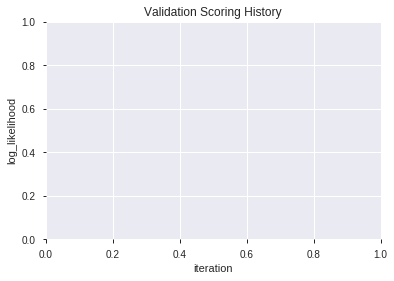

In [12]:
# GLM with top DeepLearning features
model_train(feature_name='DLF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190824_001657_model_4  0.686484  0.638581              0.348299  0.472991  0.223721
1               XGBoost_2_AutoML_20190824_001657  0.682005  0.638287              0.329228  0.473008  0.223737
2               XGBoost_1_AutoML_20190824_001657  0.672614  0.647555              0.343676  0.477069  0.227595
3  XGBoost_grid_1_AutoML_20190824_001657_model_2  0.661345  0.648062              0.386405  0.477871  0.228361
4  XGBoost_grid_1_AutoML_20190824_001657_model_7  0.658961  0.658755              0.370621  0.482759  0.233056
5  XGBoost_grid_1_AutoML_20190824_001657_model_6  0.653038  0.664644              0.379181  0.486321  0.236509
6  XGBoost_grid_1_AutoML_20190824_001657_model_5  0.647475  0.686535              0.371307  0.494286  0.244319
7  XGBoost_grid_1_AutoML_20190824_001657_model_3  0.646681  0.670604              0.377844  0.488091  0.238233
8               XGBoost_3_AutoML_20190824_001657  0.636206  0.664800              0.417973  0.486939  0.237110
9  XGBoost_grid_1_AutoML_20190824_001657_model_1  0.634400  0.683256              0.421224  0.493910  0.243947

variable  relative_importance  scaled_importance  percentage
0              BOP           801.769470           1.000000    0.226330
1              DIV           525.102600           0.654930    0.148230
2              SUB           325.148224           0.405538    0.091785
3           TRANGE           174.377823           0.217491    0.049225
4         WILLR_24           119.852432           0.149485    0.033833
5       MINUS_DI_8            91.591301           0.114236    0.025855
6      CDLBELTHOLD            87.014755           0.108528    0.024563
7         CORREL_8            80.681480           0.100629    0.022775
8           ADX_12            74.927750           0.093453    0.021151
9              SIN            74.480644           0.092895    0.021025
10         BETA_14            72.286644           0.090159    0.020406
11       dayofyear            71.492531           0.089168    0.020181
12          ULTOSC            70.287552           0.087666    0.019841
13         BETA_20            61.768974           0.077041    0.017437
14          RSI_14            59.200798           0.073838    0.016712
15          ROC_12            57.152954           0.071284    0.016134
16     STOCH_slowd            56.872528           0.070934    0.016054
17              AD            56.319221           0.070244    0.015898
18          ADX_14            53.737495           0.067024    0.015169
19          CCI_14            51.615799           0.064377    0.014570
20       CORREL_14            49.433289           0.061655    0.013954
21    STOCHF_fastk            47.893730           0.059735    0.013520
22     aroondown_8            41.478813           0.051734    0.011709
23    aroondown_30            39.248360           0.048952    0.011079
24       STDDEV_30            39.047916           0.048702    0.011023
25  STOCHRSI_fastk            34.273289           0.042747    0.009675
26       CORREL_12            32.255451           0.040230    0.009105
27       aroonup_8            31.862537           0.039740    0.008994
28   days_in_month            30.564545           0.038121    0.008628
29         WILLR_8            29.648569           0.036979    0.008369
30            week            28.824167           0.035951    0.008137
31          SAREXT            28.588711           0.035657    0.008070
32           CMO_8            28.382929           0.035400    0.008012
33       dayofweek            27.672354           0.034514    0.007812
34    aroondown_14            21.996578           0.027435    0.006209
35           CCI_8            18.897205           0.023569    0.005334
36        WILLR_14            17.472715           0.021793    0.004932
37    aroondown_12            17.440735           0.021753    0.004923
38        WILLR_12            11.824068           0.014747    0.003338

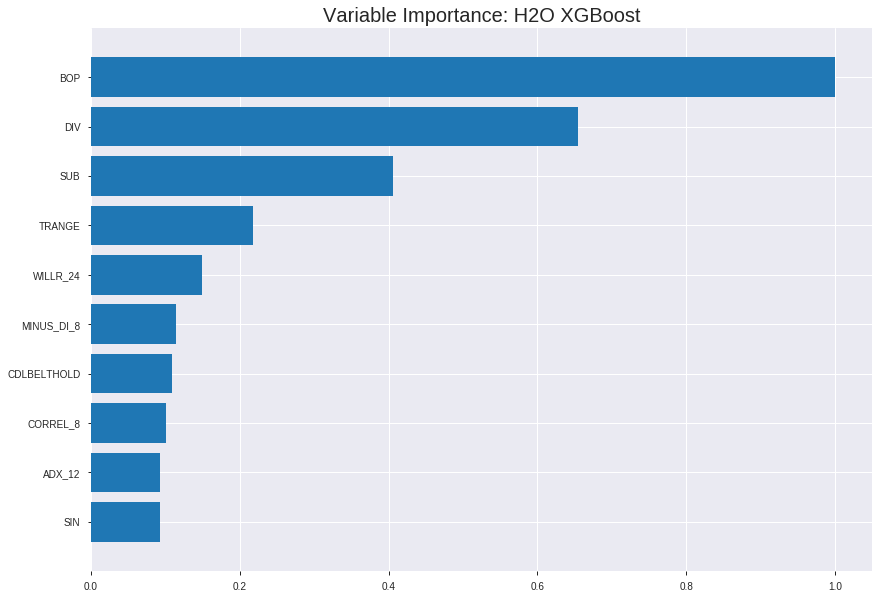

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190824_001657_model_4


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.1982151127424773
RMSE: 0.4452135585788884
LogLoss: 0.5832268132006657
Mean Per-Class Error: 0.2944990595427026
AUC: 0.78273673073532
pr_auc: 0.7885126972457814
Gini: 0.56547346147064
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.39611242711544037: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      339  456   0.5736   (456.0/795.0)
1      72   784   0.0841   (72.0/856.0)
Total  411  1240  0.3198   (528.0/1651.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.396112     0.748092  270
max f2                       0.287129     0.862561  339
max f0point5                 0.579852     0.721522  144
max accuracy                 0.54073      0.706239  177
max precision                0.786531     1         0
max recall                   0.200099     1         385
max specificity              0.786531     1         0
max absolute_mcc             0.54073      0.411347  177
max min_per_class_accuracy   0.547631     0.701887  171
max mean_per_class_accuracy  0.54073      0.705501  177

Gains/Lift Table: Avg response rate: 51.85 %, avg score: 51.69 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102968                   0.766108           1.92874   1.92874            1                0.774117  1                           0.774117            0.0198598       0.0198598                  92.8738   92.8738
    2        0.0205936                   0.749159           1.92874   1.92874            1                0.757538  1                           0.765827            0.0198598       0.0397196                  92.8738   92.8738
    3        0.0302847                   0.739909           1.68765   1.85159            0.875            0.743876  0.96                        0.758803            0.0163551       0.0560748                  68.7646   85.1589
    4        0.0405815                   0.735241           1.81528   1.84238            0.941176         0.737605  0.955224                    0.753424            0.0186916       0.0747664                  81.5283   84.2377
    5        0.0502726                   0.729086           1.5671    1.78931            0.8125           0.731937  0.927711                    0.749282            0.0151869       0.0899533                  56.71     78.9311
    6        0.100545                    0.696687           1.7196    1.75445            0.891566         0.711164  0.909639                    0.730223            0.0864486       0.176402                   71.9598   75.4455
    7        0.150212                    0.673816           1.57592   1.69542            0.817073         0.684256  0.879032                    0.715024            0.078271        0.254673                   57.592    69.5423
    8        0.200485                    0.653381           1.51046   1.64904            0.783133         0.663259  0.854985                    0.702044            0.0759346       0.330607                   51.0458   64.9042
    9        0.300424                    0.62092            1.39103   1.56321            0.721212         0.637328  0.810484                    0.680515            0.139019        0.469626                   39.1029   56.3211
    10       0.400363                    0.586989           1.15724   1.46187            0.6              0.60364   0.757943                    0.661326            0.115654        0.58528                    15.7243   46.1873
    11       0.500303                    0.549631           1.0988    1.38935            0.569697         0.568761  0.720339                    0.642835            0.109813        0.695093                   9.87964   38.9345
    12       0.600242                    0.503928           0.876699  1.30399            0.454545         0.528449  0.676085                    0.62379             0.0876168       0.78271                    -12.3301  30.3991
    13       0.700182                    0.439099           0.888389  1.24467            0.460606         0.474251  0.645329                    0.602446            0.088785        0.871495                   -11.1611  24.467
    14       0.800121                    0.358241           0.736427  1.18119            0.381818         0.397412  0.612415                    0.576836            0.0735981       0.945093                   -26.3573  18.1188
    15       0.900061                    0.282148           0.432505  1.09806            0.224242         0.323364  0.569314                    0.548691            0.0432243       0.988318                   -56.7495  9.80569
    16       1                           0.168206           0.116893  1                  0.0606061        0.230287  0.518474                    0.51687           



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.23309817643497455
RMSE: 0.482802419665617
LogLoss: 0.6583366734781224
Mean Per-Class Error: 0.362145461730524
AUC: 0.6447611862549623
pr_auc: 0.5807125732768917
Gini: 0.2895223725099245
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3188541829586029: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      57   184  0.7635   (184.0/241.0)
1      17   214  0.0736   (17.0/231.0)
Total  74   398  0.4258   (201.0/472.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.318854     0.680445  332
max f2                       0.218165     0.833333  389
max f0point5                 0.476502     0.62732   230
max accuracy                 0.476502     0.635593  230
max precision                0.750124     1         0
max recall                   0.218165     1         389
max specificity              0.750124     1         0
max absolute_mcc             0.47348      0.281788  235
max min_per_class_accuracy   0.511363     0.623377  191
max mean_per_class_accuracy  0.47348      0.637855  235

Gains/Lift Table: Avg response rate: 48.94 %, avg score: 48.26 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105932                   0.706732           0.817316  0.817316           0.4              0.724071  0.4                         0.724071            0.00865801      0.00865801                 -18.2684  -18.2684
    2        0.0211864                   0.689102           2.04329   1.4303             1                0.698928  0.7                         0.7115              0.021645        0.030303                   104.329   43.0303
    3        0.0317797                   0.67855            1.22597   1.36219            0.6              0.683427  0.666667                    0.702142            0.012987        0.04329                    22.5974   36.2193
    4        0.0402542                   0.673772           1.02165   1.2905             0.5              0.675399  0.631579                    0.696512            0.00865801      0.0519481                  2.1645    29.0499
    5        0.0508475                   0.665653           1.22597   1.27706            0.6              0.670994  0.625                       0.691196            0.012987        0.0649351                  22.5974   27.7056
    6        0.101695                    0.636357           0.936508  1.10678            0.458333         0.650545  0.541667                    0.67087             0.047619        0.112554                   -6.34921  10.6782
    7        0.150424                    0.616123           1.24374   1.15115            0.608696         0.625715  0.56338                     0.656242            0.0606061       0.17316                    24.3742   15.1149
    8        0.201271                    0.596972           1.19192   1.16145            0.583333         0.605769  0.568421                    0.643491            0.0606061       0.233766                   19.1919   16.1449
    9        0.300847                    0.570592           1.43465   1.25187            0.702128         0.585278  0.612676                    0.624223            0.142857        0.376623                   43.465    25.1875
    10       0.400424                    0.544238           1.21728   1.24327            0.595745         0.557714  0.608466                    0.607684            0.121212        0.497835                   21.7279   24.3272
    11       0.5                         0.508386           1.30423   1.25541            0.638298         0.527661  0.614407                    0.591747            0.12987         0.627706                   30.4228   25.5411
    12       0.599576                    0.474365           1.08686   1.22742            0.531915         0.490973  0.600707                    0.575011            0.108225        0.735931                   8.68564   22.7418
    13       0.699153                    0.416899           0.826011  1.17025            0.404255         0.450387  0.572727                    0.557261            0.0822511       0.818182                   -17.3989  17.0248
    14       0.798729                    0.344362           0.60864   1.10023            0.297872         0.382869  0.538462                    0.53552             0.0606061       0.878788                   -39.136   10.0233
    15       0.898305                    0.27112            0.695588  1.05538            0.340426         0.310873  0.516509                    0.510618            0.0692641       0.948052                   -30.4412  5.53786
    16       1                           0.171424           0.510823  1                  0.25             0.235461  0.489407                    0.482636        


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-24 00:17:11  2.501 sec   0                  0.5              0.693147            0.5             0                  1                0.481526                         0.5                0.693147              0.5               0                    1                  0.510593
    2019-08-24 00:17:11  2.581 sec   5                  0.486678         0.666758            0.727845        0.719421           1.63943          0.342217                         0.493582           0.680354              0.641654          0.602987             1.22597            0.394068
    2019-08-24 00:17:11  2.644 sec   10                 0.478693         0.65104             0.739133        0.744185           1.81528          0.343428                         0.48902            0.671232              0.6438            0.596965             0.817316           0.444915
    2019-08-24 00:17:11  2.697 sec   15                 0.470577         0.634979            0.748809        0.752193           1.92874          0.339188                         0.486893           0.66693               0.641923          0.579235             1.22597            0.396186
    2019-08-24 00:17:11  2.751 sec   20                 0.4649           0.623587            0.752563        0.752832           1.92874          0.342823                         0.4853             0.663563              0.638636          0.576735             1.22597            0.427966
    2019-08-24 00:17:11  2.807 sec   25                 0.461992         0.617687            0.755707        0.756976           1.92874          0.334343                         0.485576           0.664261              0.635295          0.574929             1.22597            0.398305
    2019-08-24 00:17:11  2.884 sec   30                 0.457612         0.608813            0.762399        0.765585           1.92874          0.336766                         0.483874           0.660709              0.640576          0.575464             1.22597            0.383475
    2019-08-24 00:17:11  2.947 sec   35                 0.453389         0.600073            0.767913        0.771556           1.92874          0.328892                         0.48286            0.658534              0.643674          0.582145             1.22597            0.375
    2019-08-24 00:17:11  3.013 sec   40                 0.450961         0.594903            0.769827        0.774064           1.92874          0.32768                          0.482887           0.658513              0.643127          0.577362             1.22597            0.379237
    2019-08-24 00:17:11  3.068 sec   45                 0.447872         0.588571            0.776422        0.781981           1.92874          0.317989                         0.483154           0.659093              0.642318          0.575362             0.817316           0.425847
    2019-08-24 00:17:11  3.139 sec   50                 0.445214         0.583227            0.782737        0.788513           1.92874          0.319806                         0.482802           0.658337              0.644761          0.580713             0.817316           0.425847

Variable Importances: 


variable      relative_importance    scaled_importance     percentage
------------  ---------------------  --------------------  ---------------------
BOP           801.7694702148438      1.0                   0.22632954874341546
DIV           525.1026000976562      0.65492965198207      0.14822993259178402
SUB           325.1482238769531      0.40553829492887244   0.09178529928942583
TRANGE        174.37782287597656     0.21749122329296217   0.04922469042354954
WILLR_24      119.85243225097656     0.14948490395731914   0.03383285085661284
---           ---                    ---                   ---
aroondown_14  21.996578216552734     0.027435040911022078  0.006209360429148768
CCI_8         18.897205352783203     0.023569375057046597  0.005334446020825668
WILLR_14      17.472715377807617     0.021792692322302562  0.004932330219210833
aroondown_12  17.44073486328125      0.02175280490364368   0.0049233025177452296
WILLR_12      11.824068069458008     0.014747466084346673  0.0033377873439790063


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6610169491525424)

('F1', 0.6743295019157088)

('auc', 0.686484143610489)

('logloss', 0.6385805770589681)

('mean_per_class_error', 0.34616773820703606)

('rmse', 0.4729912237237368)

('mse', 0.22372069771967804)

xgboost prediction progress: |████████████████████████████████████████████| 100%


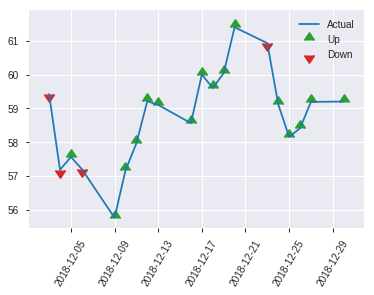


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.22372069771967804
RMSE: 0.4729912237237368
LogLoss: 0.6385805770589681
Mean Per-Class Error: 0.34616773820703606
AUC: 0.686484143610489
pr_auc: 0.6355245908640874
Gini: 0.3729682872209781
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.44608074426651: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      63   64   0.5039   (64.0/127.0)
1      21   88   0.1927   (21.0/109.0)
Total  84   152  0.3602   (85.0/236.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.446081     0.67433   151
max f2                       0.219854     0.814649  232
max f0point5                 0.577548     0.634573  86
max accuracy                 0.577548     0.661017  86
max precision                0.733168     1         0
max recall                   0.219854     1         232
max specificity              0.733168     1         0
max absolute_mcc             0.446081     0.315917  151
max min_per_class_accuracy   0.54058      0.637795  115
max mean_per_class_accuracy  0.564163     0.653832  92

Gains/Lift Table: Avg response rate: 46.19 %, avg score: 49.11 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0127119                   0.717035           2.16514   2.16514            1                0.727052  1                           0.727052            0.0275229       0.0275229                  116.514   116.514
    2        0.0211864                   0.704268           2.16514   2.16514            1                0.710309  1                           0.720355            0.0183486       0.0458716                  116.514   116.514
    3        0.0338983                   0.700078           2.16514   2.16514            1                0.701119  1                           0.713141            0.0275229       0.0733945                  116.514   116.514
    4        0.0423729                   0.693541           2.16514   2.16514            1                0.695584  1                           0.70963             0.0183486       0.0917431                  116.514   116.514
    5        0.0508475                   0.681431           1.08257   1.98471            0.5              0.690168  0.916667                    0.706386            0.00917431      0.100917                   8.25688   98.4709
    6        0.101695                    0.649593           0.721713  1.35321            0.333333         0.670613  0.625                       0.688499            0.0366972       0.137615                   -27.8287  35.3211
    7        0.152542                    0.6233             1.263     1.32314            0.583333         0.630652  0.611111                    0.669217            0.0642202       0.201835                   26.2997   32.314
    8        0.20339                     0.613611           1.44343   1.35321            0.666667         0.617702  0.625                       0.656338            0.0733945       0.275229                   44.3425   35.3211
    9        0.300847                    0.592675           1.60032   1.43326            0.73913          0.602378  0.661972                    0.638858            0.155963        0.431193                   60.0319   43.326
    10       0.402542                    0.56345            1.263     1.39025            0.583333         0.579438  0.642105                    0.623847            0.12844         0.559633                   26.2997   39.0246
    11       0.5                         0.533407           0.941364  1.30275            0.434783         0.549813  0.601695                    0.609417            0.0917431       0.651376                   -5.86358  30.2752
    12       0.601695                    0.473173           1.08257   1.26554            0.5              0.503901  0.584507                    0.591583            0.110092        0.761468                   8.25688   26.5538
    13       0.699153                    0.407847           0.847228  1.20723            0.391304         0.442753  0.557576                    0.570837            0.0825688       0.844037                   -15.2772  20.7228
    14       0.800847                    0.339509           0.631498  1.13412            0.291667         0.368942  0.52381                     0.545199            0.0642202       0.908257                   -36.8502  13.412
    15       0.898305                    0.276003           0.376546  1.05193            0.173913         0.308863  0.485849                    0.519559            0.0366972       0.944954                   -62.3454  5.19301
    16       1                           0.165839           0.541284  1                  0.25             0.239906  0.461864                    0.49112             

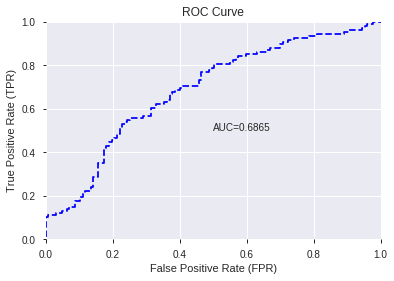

This function is available for GLM models only


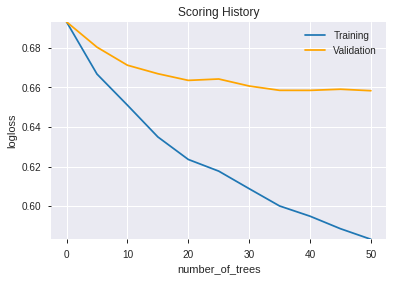

--2019-08-24 00:17:20--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.10.115
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.10.115|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190824_001657_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190824_001657_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_26_sid_9850',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'DIV',
 'SUB',
 'TRANGE',
 'WILLR_24',
 'MINUS_DI_8',
 'CDLBELTHOLD',
 'CORREL_8',
 'ADX_12',
 'SIN',
 'BETA_14',
 'dayofyear',
 'ULTOSC',
 'BETA_20',
 'RSI_14',
 'ROC_12',
 'STOCH_slowd',
 'AD',
 'ADX_14',
 'CCI_14',
 'CORREL_14',
 'STOCHF_fastk',
 'aroondown_8',
 'aroondown_30',
 'STDDEV_30',
 'STOCHRSI_fastk',
 'CORREL_12',
 'aroonup_8',
 'days_in_month',
 'WILLR_8',
 'week',
 'SAREXT',
 'CMO_8',
 'dayofweek',
 'aroondown_14',
 'CCI_8',
 'WILLR_14',
 'aroondown_12',
 'WILLR_12']

In [13]:
# XGBoost with top DeepLearning features
model_train(feature_name='DLF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id  auc    logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190824_001728_model_1  0.5  15.952231                   0.5  0.679606  0.461864

variable  relative_importance  scaled_importance  percentage
0                          BOP             0.009038           1.000000    0.023834
1                  CDLBELTHOLD             0.008351           0.924009    0.022023
2                          DIV             0.007613           0.842290    0.020075
3                          SUB             0.007547           0.834999    0.019901
4               STOCHRSI_fastk             0.005069           0.560813    0.013366
...                        ...                  ...                ...         ...
1031  BBANDS_middleband_30_2_4             0.000000           0.000000    0.000000
1032  BBANDS_middleband_30_2_5             0.000000           0.000000    0.000000
1033              LINEARREG_12             0.000000           0.000000    0.000000
1034              LINEARREG_20             0.000000           0.000000    0.000000
1035                    TSF_20             0.000000           0.000000    0.000000

[1036 rows x 4 columns]

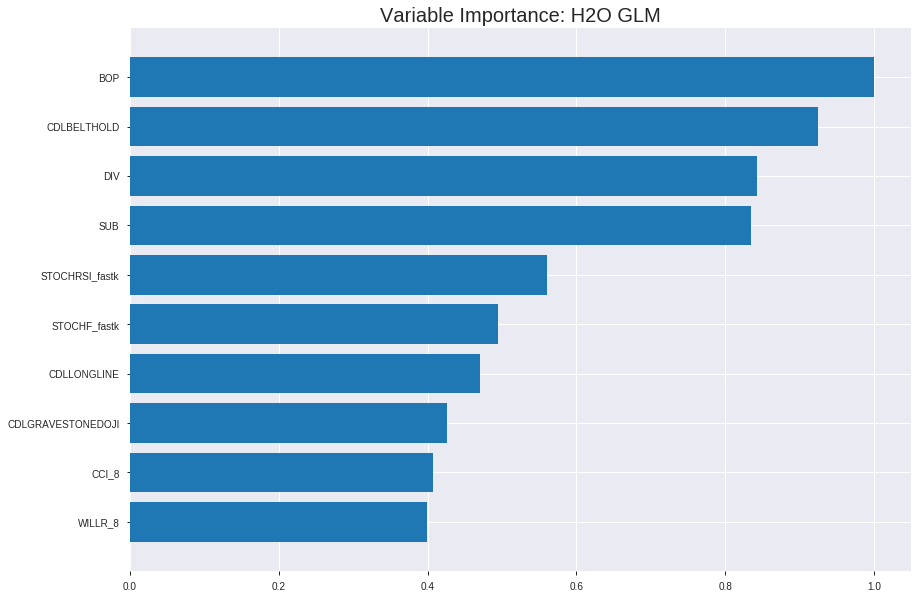

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190824_001728_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.2450628096687315
RMSE: 0.4950381901113605
LogLoss: 0.6832462991804324
Null degrees of freedom: 1650
Residual degrees of freedom: 647
Null deviance: 2286.517691569208
Residual deviance: 2256.0792798937878
AIC: 4264.079279893787
AUC: 0.6149679656733087
pr_auc: 0.6239784021137109
Gini: 0.22993593134661738
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4801236620592523: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      88   707   0.8893   (707.0/795.0)
1      33   823   0.0386   (33.0/856.0)
Total  121  1530  0.4482   (740.0/1651.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.480124     0.689858  338
max f2                       0.445474     0.844848  392
max f0point5                 0.516251     0.607818  201
max accuracy                 0.516251     0.591763  201
max precision                0.571487     1         0
max recall                   0.445474     1         392
max specificity              0.571487     1         0
max absolute_mcc             0.516251     0.180135  201
max min_per_class_accuracy   0.521888     0.579874  176
max mean_per_class_accuracy  0.516251     0.589098  201

Gains/Lift Table: Avg response rate: 51.85 %, avg score: 51.85 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102968                   0.558925           1.81528   1.81528            0.941176         0.562983  0.941176                    0.562983            0.0186916       0.0186916                  81.5283   81.5283
    2        0.0205936                   0.556587           1.58837   1.70183            0.823529         0.557719  0.882353                    0.560351            0.0163551       0.0350467                  58.8373   70.1828
    3        0.0302847                   0.554853           1.5671    1.65871            0.8125           0.555464  0.86                        0.558787            0.0151869       0.0502336                  56.71     65.8715
    4        0.0405815                   0.552794           1.13455   1.52572            0.588235         0.553821  0.791045                    0.557527            0.0116822       0.0619159                  13.4552   52.5718
    5        0.0502726                   0.551867           1.08492   1.44074            0.5625           0.552277  0.746988                    0.556515            0.010514        0.0724299                  8.49153   44.0744
    6        0.100545                    0.547597           1.20837   1.32456            0.626506         0.549633  0.686747                    0.553074            0.0607477       0.133178                   20.8366   32.4555
    7        0.150212                    0.544535           1.05845   1.23657            0.54878          0.546149  0.641129                    0.550784            0.0525701       0.185748                   5.8454    23.657
    8        0.200485                    0.54177            1.37103   1.27029            0.710843         0.543286  0.65861                     0.548904            0.0689252       0.254673                   37.1031   27.0287
    9        0.300424                    0.535421           1.08711   1.20935            0.563636         0.538842  0.627016                    0.545557            0.108645        0.363318                   8.71071   20.935
    10       0.400363                    0.529052           1.05204   1.17008            0.545455         0.532375  0.606657                    0.542266            0.10514         0.468458                   5.20391   17.0082
    11       0.500303                    0.522013           1.08711   1.15351            0.563636         0.52561   0.598063                    0.538939            0.108645        0.577103                   8.71071   15.3507
    12       0.600242                    0.513455           1.02866   1.13272            0.533333         0.517959  0.587286                    0.535446            0.102804        0.679907                   2.86604   13.272
    13       0.700182                    0.505397           0.876699  1.09618            0.454545         0.509669  0.568339                    0.531767            0.0876168       0.767523                   -12.3301  9.61774
    14       0.800121                    0.496057           0.911767  1.07314            0.472727         0.501429  0.556397                    0.527978            0.0911215       0.858645                   -8.82328  7.31436
    15       0.900061                    0.485051           0.841631  1.04744            0.436364         0.490912  0.543069                    0.523862            0.0841121       0.942757                   -15.8369  4.74373
    16       1                           0.431282           0.572777  1                  0.29697          0.469947  0.518474                    0.518474            



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.3813882228899677
RMSE: 0.6175663712427739
LogLoss: 10.0485889907613
Null degrees of freedom: 471
Residual degrees of freedom: -532
Null deviance: 655.7149900197271
Residual deviance: 188732.00081557318
AIC: 190740.00081557318
AUC: 0.5391406656966823
pr_auc: 0.5401431504314123
Gini: 0.07828133139336457
Could not find exact threshold 0.0; using closest threshold found 0.0.
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.0: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    241  1        (241.0/241.0)
1      0    231  0        (0.0/231.0)
Total  0    472  0.5106   (241.0/472.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0            0.657183  184
max f2                       0            0.827364  184
max f0point5                 0            0.545068  184
max accuracy                 0.488027     0.548729  85
max precision                0.528445     1         0
max recall                   0            1         184
max specificity              0.528445     1         0
max absolute_mcc             0.488027     0.108819  85
max min_per_class_accuracy   3.27292e-10  0.424242  183
max mean_per_class_accuracy  0.488027     0.542015  85

Gains/Lift Table: Avg response rate: 48.94 %, avg score: 18.75 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105932                   0.513954           1.63463   1.63463            0.8              0.520275   0.8                         0.520275            0.017316        0.017316                   63.4632   63.4632
    2        0.0211864                   0.51102            1.22597   1.4303             0.6              0.512592   0.7                         0.516433            0.012987        0.030303                   22.5974   43.0303
    3        0.0317797                   0.508713           1.22597   1.36219            0.6              0.509168   0.666667                    0.514011            0.012987        0.04329                    22.5974   36.2193
    4        0.0402542                   0.507223           0.510823  1.18296            0.25             0.507991   0.578947                    0.512744            0.004329        0.047619                   -48.9177  18.2957
    5        0.0508475                   0.50511            0.817316  1.10678            0.4              0.506173   0.541667                    0.511375            0.00865801      0.0562771                  -18.2684  10.6782
    6        0.101695                    0.498616           1.27706   1.19192            0.625            0.502757   0.583333                    0.507066            0.0649351       0.121212                   27.7056   19.1919
    7        0.150424                    0.492691           1.33258   1.23749            0.652174         0.495331   0.605634                    0.503265            0.0649351       0.186147                   33.258    23.7486
    8        0.201271                    0.485533           0.936508  1.16145            0.458333         0.488946   0.568421                    0.499647            0.047619        0.233766                   -6.34921  16.1449
    9        0.300847                    0.46764            0.912959  1.0792             0.446809         0.476635   0.528169                    0.492031            0.0909091       0.324675                   -8.70406  7.92025
    10       1                           0                  0.965919  1                  0.472727         0.0564267  0.489407                    0.187477            0.675325        1                          -3.40811  0


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-24 00:17:31  0.000 sec   2            11        1004          1.36649           399.856
    2019-08-24 00:17:33  1.820 sec   4            8         1037          1.36142           399.884
    2019-08-24 00:17:35  3.766 sec   6            5.8       1037          1.35514           399.919
    2019-08-24 00:17:37  5.581 sec   8            4.2       1037          1.34751           399.958
    2019-08-24 00:17:39  7.389 sec   10           3.1       1037          1.33847           400.002

Could not find exact threshold 0.0; using closest threshold found 0.0.


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.461864406779661)

Could not find exact threshold 0.0; using closest threshold found 0.0.


('F1', 0.6318840579710145)

('auc', 0.5)

('logloss', 15.952231470530771)

Could not find exact threshold 0.0; using closest threshold found 0.0.


('mean_per_class_error', 0.5)

('rmse', 0.6796060673505359)

('mse', 0.461864406779661)

glm prediction progress: |████████████████████████████████████████████████| 100%


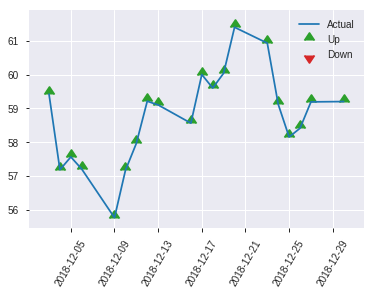


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.461864406779661
RMSE: 0.6796060673505359
LogLoss: 15.952231470530771
Null degrees of freedom: 235
Residual degrees of freedom: -768
Null deviance: 328.8185624091997
Residual deviance: 154430.41924003352
AIC: 156438.41924003352
AUC: 0.5
pr_auc: 0.0
Gini: 0.0
Could not find exact threshold 0.0; using closest threshold found 0.0.
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.0: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    127  1        (127.0/127.0)
1      0    109  0        (0.0/109.0)
Total  0    236  0.5381   (127.0/236.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0            0.631884  0
max f2                       0            0.811012  0
max f0point5                 0            0.517569  0
max accuracy                 0            0.461864  0
max precision                0            0.461864  0
max recall                   0            1         0
max specificity              0            0         0
max absolute_mcc             0            0         0
max min_per_class_accuracy   0            0         0
max mean_per_class_accuracy  0            0.5       0

Gains/Lift Table: Avg response rate: 46.19 %, avg score:  0.00 %



group    cumulative_data_fraction    lower_threshold    lift    cumulative_lift    response_rate    score    cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain    cumulative_gain
--  -------  --------------------------  -----------------  ------  -----------------  ---------------  -------  --------------------------  ------------------  --------------  -------------------------  ------  -----------------
    1        1                           0                  1       1                  0.461864         0        0.461864                    0                   1               1                          0       0

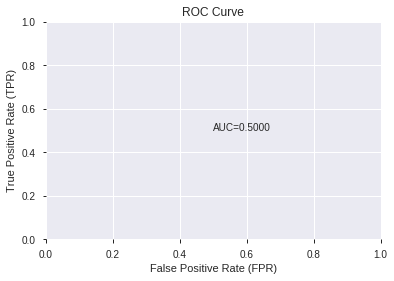

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


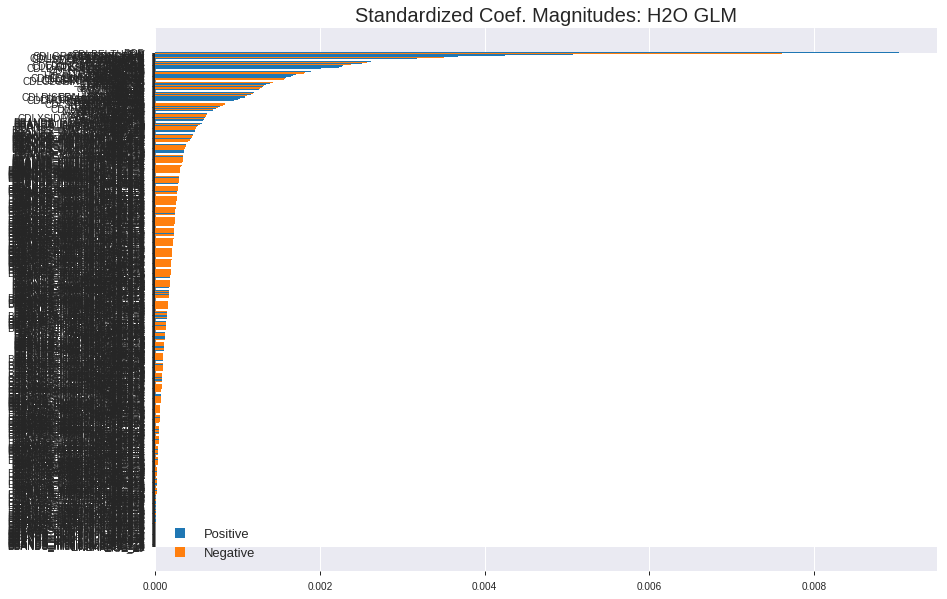

'log_likelihood'
--2019-08-24 00:18:00--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.8.91
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.8.91|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190824_001728_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190824_001728_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_34_sid_9850',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_34_s

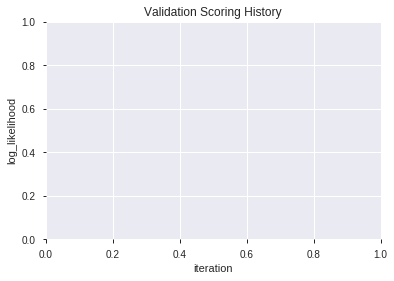

In [14]:
# GLM
glm_features = model_train(feature_name='All',model_algo="GLM")

In [15]:
# DeepLearning with top GLM features
model_train(feature_name='GLMF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

[]

In [16]:
# GLM with top GLM features
model_train(feature_name='GLMF',model_algo="GLM",features_list = features_list[:model_selected_features])

[]

In [17]:
# XGBoost with top GLM features
model_train(feature_name='GLMF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190824_001813_model_4  0.687351  0.639511              0.345012  0.473277  0.223991
1  XGBoost_grid_1_AutoML_20190824_001813_model_7  0.668280  0.656400              0.344362  0.480884  0.231249
2               XGBoost_2_AutoML_20190824_001813  0.651232  0.656169              0.404789  0.481658  0.231995
3               XGBoost_3_AutoML_20190824_001813  0.643430  0.673820              0.417937  0.490494  0.240584
4               XGBoost_1_AutoML_20190824_001813  0.641407  0.668070              0.404103  0.487075  0.237242
5  XGBoost_grid_1_AutoML_20190824_001813_model_3  0.638807  0.668812              0.450769  0.487349  0.237509
6  XGBoost_grid_1_AutoML_20190824_001813_model_2  0.630499  0.662041              0.389692  0.484696  0.234930
7  XGBoost_grid_1_AutoML_20190824_001813_model_1  0.603121  0.717704              0.404789  0.508242  0.258310
8  XGBoost_grid_1_AutoML_20190824_001813_model_6  0.600592  0.688131              0.440909  0.496994  0.247003
9  XGBoost_grid_1_AutoML_20190824_001813_model_5  0.555732  0.736330              0.484902  0.517257  0.267554

variable  relative_importance  scaled_importance  percentage
0                   BOP           751.228943           1.000000    0.183347
1                   DIV           528.458740           0.703459    0.128977
2                   SUB           288.620758           0.384198    0.070442
3                   COS            79.641418           0.106015    0.019437
4              STDDEV_8            79.316895           0.105583    0.019358
..                  ...                  ...                ...         ...
147              MFI_14             5.248613           0.006987    0.001281
148  LINEARREG_ANGLE_20             5.185672           0.006903    0.001266
149         MINUS_DI_24             4.688853           0.006242    0.001144
150         AROONOSC_30             4.617889           0.006147    0.001127
151             quarter             4.089334           0.005444    0.000998

[152 rows x 4 columns]

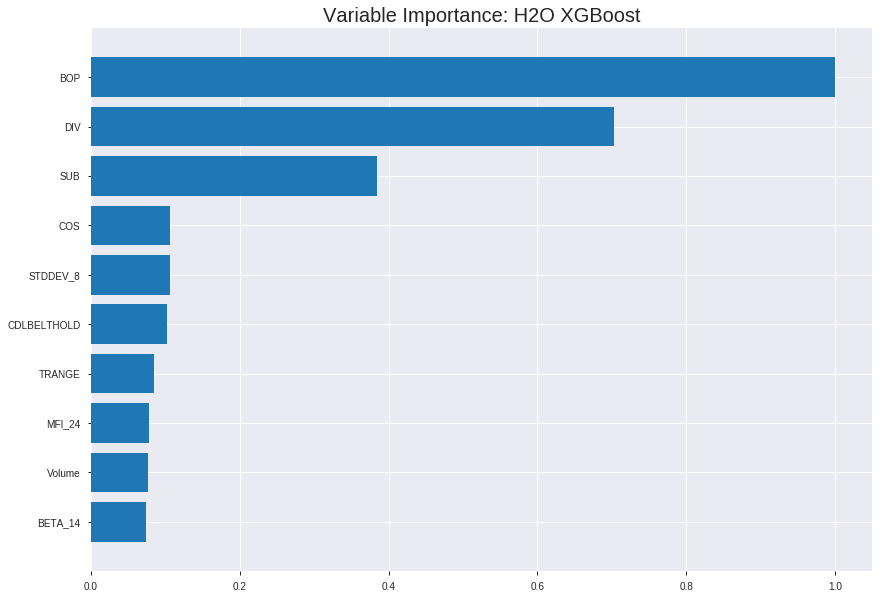

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190824_001813_model_4


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.19058135566568168
RMSE: 0.4365562457068753
LogLoss: 0.5672980569729899
Mean Per-Class Error: 0.2581107094574737
AUC: 0.8158871157350261
pr_auc: 0.820439738427476
Gini: 0.6317742314700523
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4588269889354706: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      431  364   0.4579   (364.0/795.0)
1      109  747   0.1273   (109.0/856.0)
Total  540  1111  0.2865   (473.0/1651.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.458827     0.759532  239
max f2                       0.307339     0.868762  325
max f0point5                 0.594484     0.759474  131
max accuracy                 0.544016     0.741369  174
max precision                0.803348     1         0
max recall                   0.176613     1         394
max specificity              0.803348     1         0
max absolute_mcc             0.544016     0.483474  174
max min_per_class_accuracy   0.536509     0.740881  180
max mean_per_class_accuracy  0.544016     0.741889  174

Gains/Lift Table: Avg response rate: 51.85 %, avg score: 51.63 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102968                   0.767299           1.92874    1.92874            1                0.779602  1                           0.779602            0.0198598       0.0198598                  92.8738   92.8738
    2        0.0205936                   0.748901           1.81528    1.87201            0.941176         0.756132  0.970588                    0.767867            0.0186916       0.0385514                  81.5283   87.2011
    3        0.0302847                   0.74169            1.68765    1.81301            0.875            0.74574   0.94                        0.760786            0.0163551       0.0549065                  68.7646   81.3014
    4        0.0405815                   0.73413            1.92874    1.84238            1                0.737516  0.955224                    0.754882            0.0198598       0.0747664                  92.8738   84.2377
    5        0.0502726                   0.726791           1.68765    1.81255            0.875            0.73032   0.939759                    0.750147            0.0163551       0.0911215                  68.7646   81.2549
    6        0.100545                    0.699197           1.81255    1.81255            0.939759         0.710597  0.939759                    0.730372            0.0911215       0.182243                   81.2549   81.2549
    7        0.150212                    0.671531           1.64648    1.75764            0.853659         0.685836  0.91129                     0.715646            0.0817757       0.264019                   64.6484   75.7641
    8        0.200485                    0.653164           1.64988    1.73062            0.855422         0.6623    0.897281                    0.70227             0.0829439       0.346963                   64.9885   73.062
    9        0.300424                    0.61877            1.4261     1.62932            0.739394         0.635884  0.844758                    0.680186            0.142523        0.489486                   42.6097   62.9317
    10       0.400363                    0.582528           1.3092     1.54941            0.678788         0.599631  0.803328                    0.660077            0.130841        0.620327                   30.9204   54.941
    11       0.500303                    0.541449           1.12218    1.46407            0.581818         0.563945  0.75908                     0.640874            0.11215         0.732477                   12.2175   46.4066
    12       0.600242                    0.498714           0.771495   1.34875            0.4              0.51968   0.699294                    0.620695            0.0771028       0.809579                   -22.8505  34.8754
    13       0.700182                    0.439912           0.794874   1.2697             0.412121         0.471345  0.658304                    0.599378            0.0794393       0.889019                   -20.5126  26.9697
    14       0.800121                    0.373937           0.654602   1.19287            0.339394         0.406372  0.618471                    0.575271            0.0654206       0.954439                   -34.5398  19.2868
    15       0.900061                    0.285532           0.385748   1.10325            0.2              0.328125  0.572005                    0.547829            0.0385514       0.992991                   -61.4252  10.3249
    16       1                           0.146501           0.0701359  1                  0.0363636        0.231988  0.518474                    0



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.23329493291195297
RMSE: 0.48300614169175216
LogLoss: 0.6587625307018664
Mean Per-Class Error: 0.3576278493290941
AUC: 0.6473478112482263
pr_auc: 0.5752585455630516
Gini: 0.29469562249645254
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.29432180523872375: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      51   190  0.7884   (190.0/241.0)
1      15   216  0.0649   (15.0/231.0)
Total  66   406  0.4343   (205.0/472.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.294322     0.678179  339
max f2                       0.207243     0.830338  394
max f0point5                 0.481279     0.633803  203
max accuracy                 0.481279     0.641949  203
max precision                0.71873      1         0
max recall                   0.207243     1         394
max specificity              0.71873      1         0
max absolute_mcc             0.481279     0.284844  203
max min_per_class_accuracy   0.486766     0.634855  194
max mean_per_class_accuracy  0.481279     0.642372  203

Gains/Lift Table: Avg response rate: 48.94 %, avg score: 46.76 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain         cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  -----------  -----------------
    1        0.0105932                   0.683158           0.817316  0.817316           0.4              0.696444  0.4                         0.696444            0.00865801      0.00865801                 -18.2684     -18.2684
    2        0.0211864                   0.66788            1.63463   1.22597            0.8              0.674486  0.6                         0.685465            0.017316        0.025974                   63.4632      22.5974
    3        0.0317797                   0.662618           0.817316  1.08975            0.4              0.665397  0.533333                    0.678776            0.00865801      0.034632                   -18.2684     8.97547
    4        0.0402542                   0.655706           1.53247   1.18296            0.75             0.658282  0.578947                    0.674461            0.012987        0.047619                   53.2468      18.2957
    5        0.0508475                   0.649672           0.817316  1.10678            0.4              0.65218   0.541667                    0.669819            0.00865801      0.0562771                  -18.2684     10.6782
    6        0.101695                    0.622869           0.936508  1.02165            0.458333         0.634388  0.5                         0.652104            0.047619        0.103896                   -6.34921     2.1645
    7        0.150424                    0.604951           1.24374   1.09359            0.608696         0.613404  0.535211                    0.639567            0.0606061       0.164502                   24.3742      9.35919
    8        0.201271                    0.589182           1.36219   1.16145            0.666667         0.597298  0.568421                    0.628889            0.0692641       0.233766                   36.2193      16.1449
    9        0.300847                    0.558205           1.47812   1.26626            0.723404         0.574562  0.619718                    0.610907            0.147186        0.380952                   47.8125      26.6264
    10       0.400424                    0.520459           1.3477    1.28652            0.659574         0.537536  0.62963                     0.592661            0.134199        0.515152                   34.7702      28.6516
    11       0.5                         0.485951           1.26075   1.28139            0.617021         0.505286  0.627119                    0.57526             0.125541        0.640693                   26.0753      28.1385
    12       0.599576                    0.446458           0.782537  1.19854            0.382979         0.467814  0.586572                    0.557416            0.0779221       0.718615                   -21.7463     19.8538
    13       0.699153                    0.400242           0.999908  1.17025            0.489362         0.423774  0.572727                    0.538382            0.0995671       0.818182                   -0.00921065  17.0248
    14       0.798729                    0.343422           0.60864   1.10023            0.297872         0.375912  0.538462                    0.518127            0.0606061       0.878788                   -39.136      10.0233
    15       0.898305                    0.257838           0.739062  1.0602             0.361702         0.304205  0.518868                    0.494414            0.0735931       0.952381                   -26.0938     6.01977
    16       1                           0.171949           0.468254  1                  0.229167         0.23


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-24 00:18:36  9.457 sec   0                  0.5              0.693147            0.5             0                  1                0.481526                         0.5                0.693147              0.5               0                    1                  0.510593
    2019-08-24 00:18:37  10.130 sec  5                  0.486008         0.665446            0.737834        0.734336           1.76102          0.339794                         0.493787           0.680753              0.622443          0.5698               1.22597            0.404661
    2019-08-24 00:18:37  10.439 sec  10                 0.47593          0.645636            0.754103        0.757202           1.70183          0.359176                         0.48855            0.670306              0.651767          0.61253              2.04329            0.375
    2019-08-24 00:18:37  10.721 sec  15                 0.467597         0.629209            0.766822        0.775869           1.92874          0.343428                         0.485799           0.664728              0.649737          0.603589             2.04329            0.364407
    2019-08-24 00:18:38  11.129 sec  20                 0.461445         0.616955            0.773236        0.782486           1.92874          0.339188                         0.484766           0.662441              0.641348          0.584435             1.63463            0.383475
    2019-08-24 00:18:38  11.418 sec  25                 0.456027         0.606161            0.781944        0.792348           1.92874          0.33192                          0.483651           0.660065              0.639372          0.572702             1.63463            0.375
    2019-08-24 00:18:38  11.720 sec  30                 0.451332         0.596894            0.792041        0.801829           1.92874          0.313144                         0.482686           0.657993              0.646881          0.58579              1.63463            0.366525
    2019-08-24 00:18:39  12.017 sec  35                 0.447364         0.588772            0.796276        0.805163           1.92874          0.303452                         0.482079           0.656742              0.64892           0.58336              1.63463            0.368644
    2019-08-24 00:18:39  12.305 sec  40                 0.443722         0.581433            0.801143        0.807788           1.92874          0.317989                         0.482912           0.658388              0.646665          0.571105             0.817316           0.375
    2019-08-24 00:18:39  12.628 sec  45                 0.440043         0.57418             0.808409        0.811574           1.92874          0.291944                         0.482745           0.658142              0.648453          0.578943             1.22597            0.370763
    2019-08-24 00:18:40  12.946 sec  50                 0.436556         0.567298            0.815887        0.82044            1.92874          0.286493                         0.483006           0.658763              0.647348          0.575259             0.817316           0.434322

Variable Importances: 


variable            relative_importance    scaled_importance      percentage
------------------  ---------------------  ---------------------  ---------------------
BOP                 751.2289428710938      1.0                    0.18334694101916693
DIV                 528.458740234375       0.7034589724600844     0.12897705073304286
SUB                 288.6207580566406      0.3841981339983677     0.07044155261387272
COS                 79.64141845703125      0.10601484302861482    0.01943749717192368
STDDEV_8            79.31689453125         0.10558285231678073    0.01935829299636021
---                 ---                    ---                    ---
MFI_14              5.248612880706787      0.006986702163853419   0.0012809904695545188
LINEARREG_ANGLE_20  5.185671806335449      0.006902918019261245   0.001265628902937636
MINUS_DI_24         4.6888532638549805     0.0062415769631223575  0.001144374043324186
AROONOSC_30         4.617889404296875      0.006147113271019533   0.0011270544143397567
quarter             4.089334487915039      0.005443526273476851   0.0009980538905994458


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6652542372881356)

('F1', 0.6744186046511628)

('auc', 0.6873510077295384)

('logloss', 0.6395113371273603)

('mean_per_class_error', 0.33182836090442824)

('rmse', 0.4732773400163027)

('mse', 0.22399144057290704)

xgboost prediction progress: |████████████████████████████████████████████| 100%


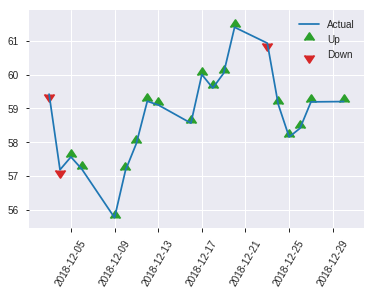


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.22399144057290704
RMSE: 0.4732773400163027
LogLoss: 0.6395113371273603
Mean Per-Class Error: 0.33182836090442824
AUC: 0.6873510077295384
pr_auc: 0.6320978083810348
Gini: 0.3747020154590768
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.456538587808609: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      65   62   0.4882   (62.0/127.0)
1      22   87   0.2018   (22.0/109.0)
Total  87   149  0.3559   (84.0/236.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.456539     0.674419  148
max f2                       0.230326     0.819549  228
max f0point5                 0.498678     0.636364  123
max accuracy                 0.498678     0.665254  123
max precision                0.679002     1         0
max recall                   0.230326     1         228
max specificity              0.679002     1         0
max absolute_mcc             0.498678     0.335798  123
max min_per_class_accuracy   0.513789     0.651376  114
max mean_per_class_accuracy  0.498678     0.668172  123

Gains/Lift Table: Avg response rate: 46.19 %, avg score: 47.29 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0127119                   0.659035           2.16514   2.16514            1                0.666406  1                           0.666406            0.0275229       0.0275229                  116.514    116.514
    2        0.0211864                   0.653027           1.08257   1.73211            0.5              0.657212  0.8                         0.662728            0.00917431      0.0366972                  8.25688    73.211
    3        0.0338983                   0.639254           2.16514   1.8945             1                0.645772  0.875                       0.65637             0.0275229       0.0642202                  116.514    89.4495
    4        0.0423729                   0.636036           1.08257   1.73211            0.5              0.63773   0.8                         0.652642            0.00917431      0.0733945                  8.25688    73.211
    5        0.0508475                   0.634309           1.08257   1.62385            0.5              0.63541   0.75                        0.64977             0.00917431      0.0825688                  8.25688    62.3853
    6        0.101695                    0.614898           1.44343   1.53364            0.666667         0.622641  0.708333                    0.636205            0.0733945       0.155963                   44.3425    53.3639
    7        0.152542                    0.606297           1.62385   1.56371            0.75             0.609548  0.722222                    0.62732             0.0825688       0.238532                   62.3853    56.371
    8        0.20339                     0.596983           1.263     1.48853            0.583333         0.600682  0.6875                      0.62066             0.0642202       0.302752                   26.2997    48.8532
    9        0.300847                    0.5701             1.22377   1.40277            0.565217         0.583394  0.647887                    0.608588            0.119266        0.422018                   22.3773    40.2765
    10       0.402542                    0.543193           1.08257   1.32187            0.5              0.556739  0.610526                    0.595489            0.110092        0.53211                    8.25688    32.1873
    11       0.5                         0.50709            1.31791   1.3211             0.608696         0.528844  0.610169                    0.582499            0.12844         0.66055                    31.791     32.1101
    12       0.601695                    0.468792           0.992355  1.26554            0.458333         0.489367  0.584507                    0.566758            0.100917        0.761468                   -0.764526  26.5538
    13       0.699153                    0.395665           0.753091  1.19411            0.347826         0.434839  0.551515                    0.54837             0.0733945       0.834862                   -24.6909   19.4106
    14       0.800847                    0.333448           0.541284  1.11121            0.25             0.364193  0.513228                    0.524982            0.0550459       0.889908                   -45.8716   11.1208
    15       0.898305                    0.264481           0.470682  1.04172            0.217391         0.293351  0.481132                    0.499852            0.0458716       0.93578                    -52.9318   4.17172
    16       1                           0.19076            0.631498  1                  0.291667         0.23443   0.461864                    0.4

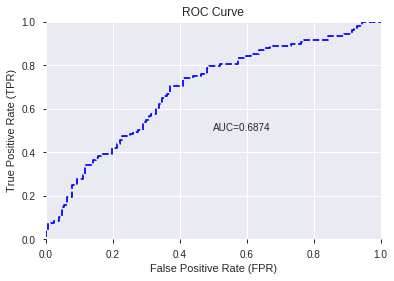

This function is available for GLM models only


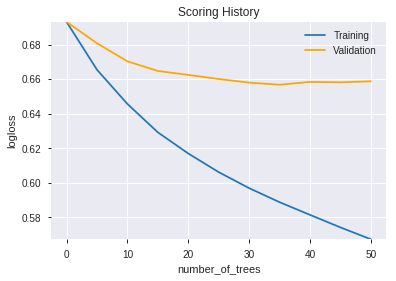

--2019-08-24 00:18:58--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.105.27
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.105.27|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.calculateChildInclusiveNa(SharedTreeNode.java:133)
	at hex.genmodel.algos.tree.SharedTreeNode.setLeftChild(SharedTreeNode.java:207)
	at hex.gen

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190824_001813_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190824_001813_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_42_sid_9850',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

In [18]:
# XGBoost
xgb_features = model_train(feature_name='All',model_algo="XGBoost")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190824_001911_model_6  0.687929  0.654397              0.360832  0.478887  0.229333
1  DeepLearning_grid_1_AutoML_20190824_001911_model_5  0.679116  0.651084              0.362096  0.479181  0.229615
2  DeepLearning_grid_1_AutoML_20190824_001911_model_3  0.673698  0.782060              0.362819  0.504191  0.254208
3  DeepLearning_grid_1_AutoML_20190824_001911_model_8  0.666619  0.646118              0.358195  0.475745  0.226333
4  DeepLearning_grid_1_AutoML_20190824_001911_model_9  0.660406  0.649755              0.347035  0.478864  0.229311
5  DeepLearning_grid_1_AutoML_20190824_001911_model_4  0.652676  0.797632              0.373944  0.512791  0.262954
6  DeepLearning_grid_1_AutoML_20190824_001911_model_2  0.648125  0.862248              0.392292  0.524025  0.274602
7  DeepLearning_grid_1_AutoML_20190824_001911_model_1  0.643141  1.083406              0.369970  0.553132  0.305955
8               DeepLearning_1_AutoML_20190824_001911  0.627682  1.002243              0.411363  0.542367  0.294162
9  DeepLearning_grid_1_AutoML_20190824_001911_model_7  0.609405  1.045793              0.413350  0.549182  0.301601

variable  relative_importance  scaled_importance  percentage
0                 BOP             1.000000           1.000000    0.034175
1                 DIV             0.911557           0.911557    0.031152
2         CDLBELTHOLD             0.846087           0.846087    0.028915
3                 SUB             0.787743           0.787743    0.026921
4              TRANGE             0.756283           0.756283    0.025846
5             CDLDOJI             0.647506           0.647506    0.022128
6      STOCHRSI_fastk             0.632078           0.632078    0.021601
7           aroonup_8             0.616228           0.616228    0.021059
8        HT_TRENDMODE             0.614497           0.614497    0.021000
9            CORREL_8             0.602108           0.602108    0.020577
10          CORREL_12             0.601372           0.601372    0.020552
11            weekday             0.599151           0.599151    0.020476
12        STOCH_slowd             0.597760           0.597760    0.020428
13          dayofweek             0.594597           0.594597    0.020320
14        aroondown_8             0.588135           0.588135    0.020099
15             SAREXT             0.586487           0.586487    0.020043
16          CORREL_14             0.585839           0.585839    0.020021
17      days_in_month             0.585659           0.585659    0.020015
18  CDLLONGLEGGEDDOJI             0.585537           0.585537    0.020011
19                 AD             0.579436           0.579436    0.019802
20       STOCHF_fastk             0.576208           0.576208    0.019692
21             ADX_14             0.566885           0.566885    0.019373
22             ADX_12             0.562459           0.562459    0.019222
23       aroondown_12             0.557903           0.557903    0.019066
24            ROCP_12             0.554703           0.554703    0.018957
25                SIN             0.553742           0.553742    0.018924
26             ULTOSC             0.551717           0.551717    0.018855
27            BETA_14             0.550849           0.550849    0.018825
28             ROC_12             0.548615           0.548615    0.018749
29       aroondown_14             0.546457           0.546457    0.018675
30              CMO_8             0.537847           0.537847    0.018381
31         MINUS_DI_8             0.537198           0.537198    0.018359
32            quarter             0.533494           0.533494    0.018232
33           WILLR_24             0.533033           0.533033    0.018216
34          STDDEV_30             0.532363           0.532363    0.018193
35            WILLR_8             0.531180           0.531180    0.018153
36            BETA_20             0.531055           0.531055    0.018149
37       aroondown_30             0.528293           0.528293    0.018054
38              month             0.526275           0.526275    0.017985
39         weekofyear             0.522942           0.522942    0.017871
40              CCI_8             0.522369           0.522369    0.017852
41             CCI_14             0.520448           0.520448    0.017786
42             RSI_14             0.516819           0.516819    0.017662
43          dayofyear             0.514875           0.514875    0.017596
44         ROCR100_12             0.508843           0.508843    0.017390
45            ROCR_12             0.507760           0.507760    0.017353
46           WILLR_12             0.505180           0.505180    0.017264
47              RSI_8             0.502719           0.502719    0.017180
48               week             0.483924           0.483924    0.016538
49           WILLR_14             0.477180           0.477180    0.016307

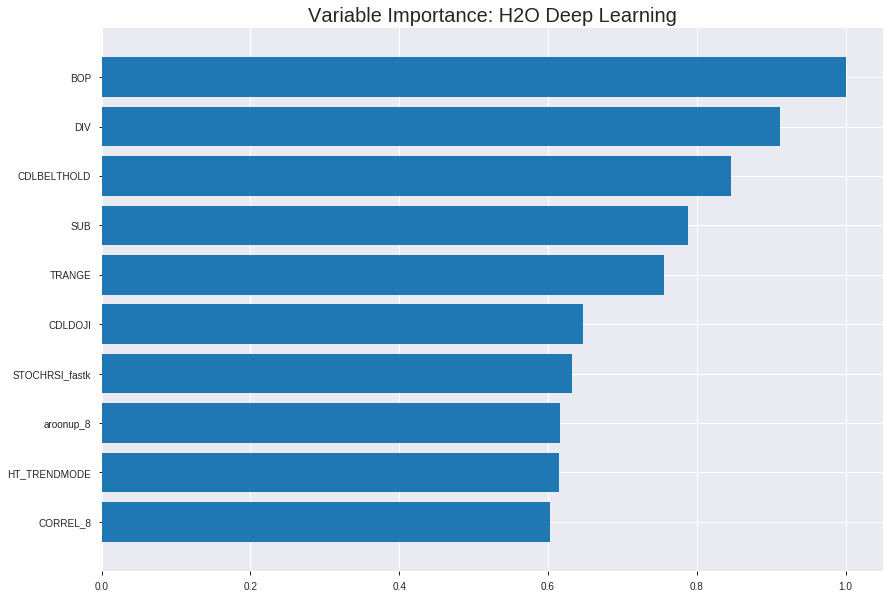

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190824_001911_model_6


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.21719983141660584
RMSE: 0.466047027044059
LogLoss: 0.6217508147753205
Mean Per-Class Error: 0.3463344207370834
AUC: 0.7024922118380063
pr_auc: 0.7005689896709629
Gini: 0.4049844236760125
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.46788365457972825: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      259  536   0.6742   (536.0/795.0)
1      61   795   0.0713   (61.0/856.0)
Total  320  1331  0.3616   (597.0/1651.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.467884     0.727023  253
max f2                       0.307326     0.852674  325
max f0point5                 0.556473     0.663364  198
max accuracy                 0.556473     0.658995  198
max precision                0.980857     1         0
max recall                   0.0950908    1         384
max specificity              0.980857     1         0
max absolute_mcc             0.502875     0.323304  235
max min_per_class_accuracy   0.574844     0.623899  176
max mean_per_class_accuracy  0.556473     0.653666  198

Gains/Lift Table: Avg response rate: 51.85 %, avg score: 55.14 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102968                   0.910719           1.81528   1.81528            0.941176         0.951539  0.941176                    0.951539            0.0186916       0.0186916                  81.5283   81.5283
    2        0.0205936                   0.858206           1.70183   1.75856            0.882353         0.882168  0.911765                    0.916853            0.0175234       0.036215                   70.1828   75.8556
    3        0.0302847                   0.823572           1.68765   1.73586            0.875            0.840122  0.9                         0.892299            0.0163551       0.0525701                  68.7646   73.5864
    4        0.0405815                   0.804743           1.70183   1.72723            0.882353         0.812891  0.895522                    0.872151            0.0175234       0.0700935                  70.1828   72.7228
    5        0.0502726                   0.778586           1.44655   1.67312            0.75             0.791902  0.86747                     0.856681            0.0140187       0.0841121                  44.6554   67.3122
    6        0.100545                    0.688555           1.51046   1.59179            0.783133         0.726241  0.825301                    0.791461            0.0759346       0.160047                   51.0458   59.179
    7        0.150212                    0.658326           1.38775   1.52433            0.719512         0.673068  0.790323                    0.752315            0.0689252       0.228972                   38.7751   52.4325
    8        0.200485                    0.626763           1.18513   1.43927            0.614458         0.641286  0.746224                    0.724474            0.0595794       0.288551                   18.5128   43.927
    9        0.300424                    0.599771           1.0988    1.32601            0.569697         0.612227  0.6875                      0.687134            0.109813        0.398364                   9.87964   32.6008
    10       0.400363                    0.58568            1.07542   1.26345            0.557576         0.592329  0.655068                    0.663469            0.107477        0.505841                   7.54177   26.3455
    11       0.500303                    0.574973           1.16893   1.24457            0.606061         0.579868  0.645278                    0.646769            0.116822        0.622664                   16.8932   24.4573
    12       0.600242                    0.56386            1.16893   1.23198            0.606061         0.569519  0.638749                    0.633907            0.116822        0.739486                   16.8932   23.1979
    13       0.700182                    0.539013           1.00528   1.19962            0.521212         0.553999  0.621972                    0.622501            0.100467        0.839953                   0.528179  19.9622
    14       0.800121                    0.469636           0.818253  1.15199            0.424242         0.51148   0.597275                    0.608634            0.0817757       0.921729                   -18.1747  15.1987
    15       0.900061                    0.346565           0.52602   1.08248            0.272727         0.412842  0.561238                    0.586894            0.0525701       0.974299                   -47.398   8.24817
    16       1                           0.0152612          0.257165  1                  0.133333         0.231433  0.518474                    0.551369           



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.24912574635676282
RMSE: 0.49912498069798394
LogLoss: 0.7042486969669823
Mean Per-Class Error: 0.40310933879398614
AUC: 0.6060516247238239
pr_auc: 0.5486546392316551
Gini: 0.2121032494476478
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.38617198258996877: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      67   174  0.722    (174.0/241.0)
1      24   207  0.1039   (24.0/231.0)
Total  91   381  0.4195   (198.0/472.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.386172     0.676471  312
max f2                       0.0800756    0.829741  395
max f0point5                 0.410539     0.595732  298
max accuracy                 0.570652     0.595339  182
max precision                0.832907     0.666667  11
max recall                   0.0800756    1         395
max specificity              0.980197     0.995851  0
max absolute_mcc             0.410539     0.230602  298
max min_per_class_accuracy   0.567346     0.580913  190
max mean_per_class_accuracy  0.410539     0.596891  298

Gains/Lift Table: Avg response rate: 48.94 %, avg score: 52.40 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain         cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  -----------  -----------------
    1        0.0105932                   0.907949           0.817316  0.817316           0.4              0.950081  0.4                         0.950081            0.00865801      0.00865801                 -18.2684     -18.2684
    2        0.0211864                   0.839902           1.63463   1.22597            0.8              0.885152  0.6                         0.917617            0.017316        0.025974                   63.4632      22.5974
    3        0.0317797                   0.814052           1.22597   1.22597            0.6              0.8237    0.6                         0.886311            0.012987        0.038961                   22.5974      22.5974
    4        0.0402542                   0.786847           0         0.967874           0                0.802364  0.473684                    0.868638            0               0.038961                   -100         -3.21258
    5        0.0508475                   0.762208           0.817316  0.936508           0.4              0.771748  0.458333                    0.848453            0.00865801      0.047619                   -18.2684     -6.34921
    6        0.101695                    0.698164           1.36219   1.14935            0.666667         0.726262  0.5625                      0.787357            0.0692641       0.116883                   36.2193      14.9351
    7        0.150424                    0.656939           1.1549    1.15115            0.565217         0.678922  0.56338                     0.75223             0.0562771       0.17316                    15.4903      15.1149
    8        0.201271                    0.62744            0.851371  1.07542            0.416667         0.643127  0.526316                    0.724667            0.04329         0.21645                    -14.8629     7.54158
    9        0.300847                    0.596451           1.26075   1.13676            0.617021         0.609634  0.556338                    0.686593            0.125541        0.341991                   26.0753      13.676
    10       0.400424                    0.580969           1.3477    1.18922            0.659574         0.58923   0.582011                    0.662381            0.134199        0.47619                    34.7702      18.9216
    11       0.5                         0.566566           1.08686   1.16883            0.531915         0.573775  0.572034                    0.644735            0.108225        0.584416                   8.68564      16.8831
    12       0.599576                    0.537131           1.08686   1.15522            0.531915         0.55518   0.565371                    0.629862            0.108225        0.692641                   8.68564      15.5217
    13       0.699153                    0.477593           0.912959  1.12071            0.446809         0.512254  0.548485                    0.613111            0.0909091       0.78355                    -8.70406     12.0714
    14       0.798729                    0.389277           0.999908  1.10565            0.489362         0.43247   0.541114                    0.590591            0.0995671       0.883117                   -0.00921065  10.5653
    15       0.898305                    0.287538           0.521691  1.04092            0.255319         0.339939  0.509434                    0.562807            0.0519481       0.935065                   -47.8309     4.09213
    16       1                           0.0398433          0.638528  1                  0.3125           0.


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-24 00:23:22  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-24 00:23:26  2 min 10.861 sec  1152 obs/sec      2.66323   1             4397       0.505164         0.711962            -0.022159      0.614369        0.624026           1.58837          0.450636                         0.532456           0.785581              -0.134546        0.561711          0.546246             1.63463            0.510593
    2019-08-24 00:23:34  2 min 18.461 sec  2059 obs/sec      13.3555   5             22050      0.466047         0.621751            0.130013       0.702492        0.700569           1.81528          0.361599                         0.499125           0.704249              0.00304952       0.606052          0.548655             0.817316           0.419492
    2019-08-24 00:23:42  2 min 26.494 sec  2440 obs/sec      26.6844   10            44056      0.457556         0.602207            0.161425       0.726881        0.733896           1.92874          0.338583                         0.517225           0.771016              -0.070566        0.589822          0.551003             1.22597            0.466102
    2019-08-24 00:23:50  2 min 34.548 sec  2603 obs/sec      40.0781   15            66169      0.441732         0.568425            0.218424       0.772134        0.776533           1.92874          0.299818                         0.520593           0.790206              -0.0845565       0.595849          0.544736             0.408658           0.45339
    2019-08-24 00:23:58  2 min 42.455 sec  2708 obs/sec      53.4761   20            88289      0.432202         0.54868             0.251784       0.801857        0.808648           1.92874          0.282859                         0.516564           0.777829              -0.0678347       0.609168          0.562716             0.817316           0.495763
    2019-08-24 00:24:05  2 min 50.261 sec  2780 obs/sec      66.8674   25            110398     0.416998         0.515167            0.303499       0.826498        0.83504            1.92874          0.274379                         0.522617           0.811162              -0.0930067       0.61224           0.567267             0.817316           0.466102
    2019-08-24 00:24:06  2 min 50.981 sec  2779 obs/sec      66.8674   25            110398     0.466047         0.621751            0.130013       0.702492        0.700569           1.81528          0.361599                         0.499125           0.704249              0.00304952       0.606052          0.548655             0.817316           0.419492

Variable Importances: 


variable     relative_importance    scaled_importance    percentage
-----------  ---------------------  -------------------  --------------------
BOP          1.0                    1.0                  0.03417471590927175
DIV          0.9115569591522217     0.9115569591522217   0.031152200114146808
CDLBELTHOLD  0.8460870981216431     0.8460870981216431   0.028914786212807284
SUB          0.7877432107925415     0.7877432107925415   0.026920900438292678
TRANGE       0.7562834620475769     0.7562834620475769   0.025845772462356444
---          ---                    ---                  ---
ROCR_12      0.5077600479125977     0.5077600479125977   0.017352555387491236
WILLR_12     0.5051802396774292     0.5051802396774292   0.017264391173953956
RSI_8        0.5027192831039429     0.5027192831039429   0.017180288682190004
week         0.48392361402511597    0.48392361402511597  0.016537952031096412
WILLR_14     0.47717955708503723    0.47717955708503723  0.01630747580109327


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.652542372881356)

('F1', 0.6875)

('auc', 0.687928917142238)

('logloss', 0.6543965821307131)

('mean_per_class_error', 0.3520913096872065)

('rmse', 0.4788869271374209)

('mse', 0.22933268898312148)

deeplearning prediction progress: |███████████████████████████████████████| 100%


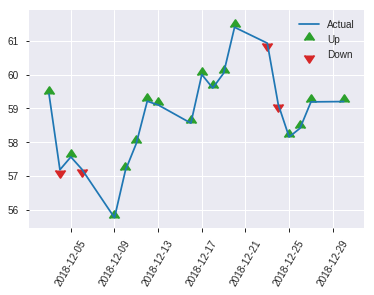


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.22933268898312148
RMSE: 0.4788869271374209
LogLoss: 0.6543965821307131
Mean Per-Class Error: 0.3520913096872065
AUC: 0.687928917142238
pr_auc: 0.5924154233747716
Gini: 0.37585783428447606
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.37604801440133145: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      47   80   0.6299   (80.0/127.0)
1      10   99   0.0917   (10.0/109.0)
Total  57   179  0.3814   (90.0/236.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.376048     0.6875    178
max f2                       0.0839941    0.820783  227
max f0point5                 0.572548     0.623782  100
max accuracy                 0.597811     0.652542  68
max precision                0.923055     1         0
max recall                   0.0839941    1         227
max specificity              0.923055     1         0
max absolute_mcc             0.376048     0.324205  178
max min_per_class_accuracy   0.563432     0.637795  115
max mean_per_class_accuracy  0.572548     0.647909  100

Gains/Lift Table: Avg response rate: 46.19 %, avg score: 48.86 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0127119                   0.888979           1.44343   1.44343            0.666667         0.903313  0.666667                    0.903313            0.0183486       0.0183486                  44.3425   44.3425
    2        0.0211864                   0.845587           0         0.866055           0                0.876963  0.4                         0.892773            0               0.0183486                  -100      -13.3945
    3        0.0338983                   0.801503           1.44343   1.08257            0.666667         0.822413  0.5                         0.866388            0.0183486       0.0366972                  44.3425   8.25688
    4        0.0423729                   0.751623           1.08257   1.08257            0.5              0.768494  0.5                         0.846809            0.00917431      0.0458716                  8.25688   8.25688
    5        0.0508475                   0.72728            1.08257   1.08257            0.5              0.737822  0.5                         0.828645            0.00917431      0.0550459                  8.25688   8.25688
    6        0.101695                    0.667452           1.263     1.17278            0.583333         0.699732  0.541667                    0.764188            0.0642202       0.119266                   26.2997   17.2783
    7        0.152542                    0.641986           1.62385   1.32314            0.75             0.652703  0.611111                    0.727027            0.0825688       0.201835                   62.3853   32.314
    8        0.20339                     0.61477            2.16514   1.53364            1                0.626786  0.708333                    0.701967            0.110092        0.311927                   116.514   53.3639
    9        0.300847                    0.593883           1.31791   1.46376            0.608696         0.605699  0.676056                    0.670781            0.12844         0.440367                   31.791    46.3755
    10       0.402542                    0.575673           1.17278   1.39025            0.541667         0.585244  0.642105                    0.649172            0.119266        0.559633                   17.2783   39.0246
    11       0.5                         0.558704           0.941364  1.30275            0.434783         0.568397  0.601695                    0.633428            0.0917431       0.651376                   -5.86358  30.2752
    12       0.601695                    0.490634           0.811927  1.2198             0.375            0.53056   0.56338                     0.616042            0.0825688       0.733945                   -18.8073  21.9796
    13       0.699153                    0.429344           0.941364  1.18098            0.434783         0.461078  0.545455                    0.594441            0.0917431       0.825688                   -5.86358  18.0984
    14       0.800847                    0.320821           0.902141  1.14558            0.416667         0.375672  0.529101                    0.56666             0.0917431       0.917431                   -9.78593  14.5575
    15       0.898305                    0.187431           0.376546  1.06214            0.173913         0.254744  0.490566                    0.53282             0.0366972       0.954128                   -62.3454  6.2143
    16       1                           0.0125833          0.45107   1                  0.208333         0.098099  0.461864                    0.488611          

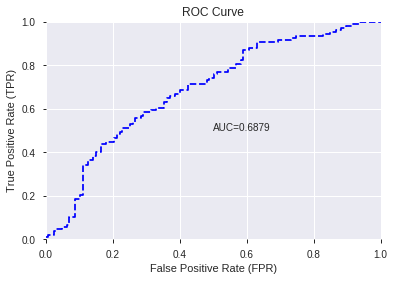

This function is available for GLM models only


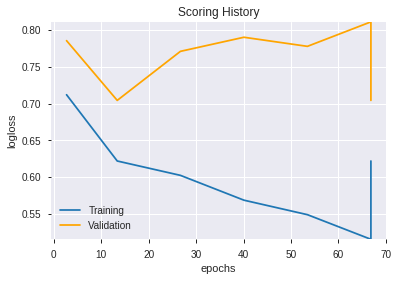

--2019-08-24 00:28:35--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.169.123
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.169.123|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190824_001911_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190824_001911_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_50_sid_9850',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'DIV',
 'CDLBELTHOLD',
 'SUB',
 'TRANGE',
 'CDLDOJI',
 'STOCHRSI_fastk',
 'aroonup_8',
 'HT_TRENDMODE',
 'CORREL_8',
 'CORREL_12',
 'weekday',
 'STOCH_slowd',
 'dayofweek',
 'aroondown_8',
 'SAREXT',
 'CORREL_14',
 'days_in_month',
 'CDLLONGLEGGEDDOJI',
 'AD',
 'STOCHF_fastk',
 'ADX_14',
 'ADX_12',
 'aroondown_12',
 'ROCP_12',
 'SIN',
 'ULTOSC',
 'BETA_14',
 'ROC_12',
 'aroondown_14',
 'CMO_8',
 'MINUS_DI_8',
 'quarter',
 'WILLR_24',
 'STDDEV_30',
 'WILLR_8',
 'BETA_20',
 'aroondown_30',
 'month',
 'weekofyear',
 'CCI_8',
 'CCI_14',
 'RSI_14',
 'dayofyear',
 'ROCR100_12',
 'ROCR_12',
 'WILLR_12',
 'RSI_8',
 'week',
 'WILLR_14']

In [19]:
# DeepLearning with top XGBoost features
model_train(feature_name='XGBF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id      auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190824_002843_model_1  0.64827  0.656926              0.364697  0.482132  0.232451

variable  relative_importance  scaled_importance  percentage
0                 BOP             0.118962           1.000000    0.107909
1                 SUB             0.111213           0.934859    0.100880
2         CDLBELTHOLD             0.105724           0.888719    0.095901
3                 DIV             0.093631           0.787067    0.084932
4           aroonup_8             0.051237           0.430697    0.046476
5         aroondown_8             0.039873           0.335170    0.036168
6                  AD             0.039346           0.330747    0.035691
7      STOCHRSI_fastk             0.039282           0.330203    0.035632
8         STOCH_slowd             0.035050           0.294634    0.031794
9              TRANGE             0.030937           0.260061    0.028063
10       aroondown_12             0.024419           0.205270    0.022150
11       STOCHF_fastk             0.024194           0.203380    0.021947
12      days_in_month             0.023274           0.195643    0.021112
13  CDLLONGLEGGEDDOJI             0.022489           0.189045    0.020400
14          STDDEV_30             0.021933           0.184369    0.019895
15            CDLDOJI             0.021300           0.179048    0.019321
16       HT_TRENDMODE             0.020276           0.170441    0.018392
17             ULTOSC             0.019132           0.160827    0.017355
18            WILLR_8             0.018103           0.152173    0.016421
19          CORREL_12             0.017898           0.150453    0.016235
20          CORREL_14             0.017375           0.146057    0.015761
21              CCI_8             0.016419           0.138018    0.014893
22       aroondown_30             0.012441           0.104581    0.011285
23            BETA_14             0.011763           0.098878    0.010670
24           WILLR_24             0.010966           0.092182    0.009947
25             ROC_12             0.010875           0.091415    0.009864
26            ROCP_12             0.010864           0.091321    0.009854
27            ROCR_12             0.010834           0.091071    0.009827
28         ROCR100_12             0.010811           0.090874    0.009806
29       aroondown_14             0.010794           0.090735    0.009791
30             ADX_14             0.010766           0.090501    0.009766
31           WILLR_12             0.009775           0.082173    0.008867
32           WILLR_14             0.008792           0.073907    0.007975
33            quarter             0.008515           0.071575    0.007724
34             ADX_12             0.008243           0.069292    0.007477
35              month             0.007289           0.061271    0.006612
36          dayofyear             0.006158           0.051766    0.005586
37              RSI_8             0.005530           0.046489    0.005017
38              CMO_8             0.005506           0.046284    0.004995
39                SIN             0.005270           0.044302    0.004781
40             RSI_14             0.004831           0.040610    0.004382
41            weekday             0.003761           0.031613    0.003411
42          dayofweek             0.003753           0.031549    0.003404
43         MINUS_DI_8             0.003652           0.030701    0.003313
44           CORREL_8             0.003382           0.028427    0.003068
45            BETA_20             0.002490           0.020930    0.002259
46             CCI_14             0.002092           0.017587    0.001898
47             SAREXT             0.000434           0.003648    0.000394
48         weekofyear             0.000387           0.003252    0.000351
49               week             0.000386           0.003248    0.000350

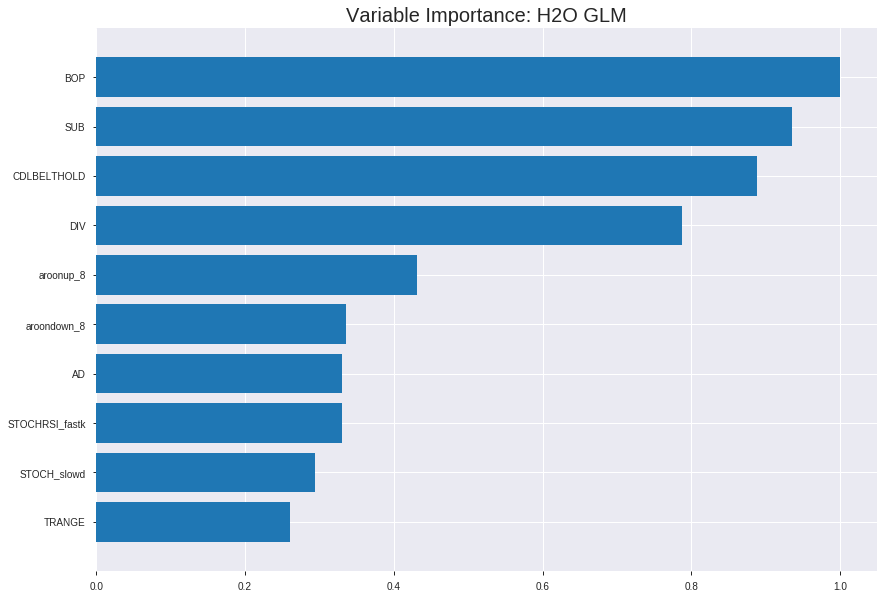

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190824_002843_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.22950047037445742
RMSE: 0.47906207361307307
LogLoss: 0.6510885381437406
Null degrees of freedom: 1650
Residual degrees of freedom: 1600
Null deviance: 2286.517691569208
Residual deviance: 2149.8943529506314
AIC: 2251.8943529506314
AUC: 0.672539381649327
pr_auc: 0.6509944551366478
Gini: 0.34507876329865406
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.44312864435755595: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      241  554   0.6969   (554.0/795.0)
1      69   787   0.0806   (69.0/856.0)
Total  310  1341  0.3773   (623.0/1651.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.443129     0.716431  276
max f2                       0.344875     0.84637   349
max f0point5                 0.517993     0.648345  190
max accuracy                 0.517993     0.637795  190
max precision                0.868461     1         0
max recall                   0.207613     1         395
max specificity              0.868461     1         0
max absolute_mcc             0.446635     0.286313  272
max min_per_class_accuracy   0.533142     0.622664  169
max mean_per_class_accuracy  0.517993     0.63488   190

Gains/Lift Table: Avg response rate: 51.85 %, avg score: 51.85 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102968                   0.672166           1.47492   1.47492            0.764706         0.702368  0.764706                    0.702368            0.0151869       0.0151869                  47.4918   47.4918
    2        0.0205936                   0.6627             1.24801   1.36146            0.647059         0.665996  0.705882                    0.684182            0.0128505       0.0280374                  24.8007   36.1462
    3        0.0302847                   0.654747           1.32601   1.35012            0.6875           0.659751  0.7                         0.676364            0.0128505       0.0408879                  32.6008   35.0117
    4        0.0405815                   0.643622           1.47492   1.38178            0.764706         0.648627  0.716418                    0.669326            0.0151869       0.0560748                  47.4918   38.1783
    5        0.0502726                   0.638318           1.08492   1.32456            0.5625           0.640807  0.686747                    0.663828            0.010514        0.0665888                  8.49153   32.4555
    6        0.100545                    0.619697           1.39427   1.35941            0.722892         0.627156  0.704819                    0.645492            0.0700935       0.136682                   39.4269   35.9412
    7        0.150212                    0.605721           1.29367   1.33767            0.670732         0.611233  0.693548                    0.634164            0.0642523       0.200935                   29.3666   33.7673
    8        0.200485                    0.593146           1.2316    1.31108            0.638554         0.598861  0.679758                    0.625312            0.0619159       0.26285                    23.1604   31.1076
    9        0.300424                    0.574066           1.28583   1.30268            0.666667         0.583868  0.675403                    0.611525            0.128505        0.391355                   28.5826   30.2676
    10       0.400363                    0.554543           1.12218   1.25762            0.581818         0.564237  0.652042                    0.599721            0.11215         0.503505                   12.2175   25.7619
    11       0.500303                    0.533349           1.18062   1.24224            0.612121         0.543844  0.644068                    0.588559            0.117991        0.621495                   18.0622   24.2238
    12       0.600242                    0.514468           1.01697   1.20473            0.527273         0.523029  0.624622                    0.577648            0.101636        0.723131                   1.69711   20.4732
    13       0.700182                    0.485015           0.935146  1.16625            0.484848         0.500256  0.604671                    0.566602            0.0934579       0.816589                   -6.48541  16.6253
    14       0.800121                    0.447333           0.923457  1.13593            0.478788         0.467502  0.588948                    0.554224            0.0922897       0.908879                   -7.65435  13.5926
    15       0.900061                    0.388394           0.607845  1.07729            0.315152         0.421835  0.558546                    0.539524            0.0607477       0.969626                   -39.2155  7.72899
    16       1                           0.130762           0.303922  1                  0.157576         0.328894  0.518474                    0.518474         



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.24151918629529243
RMSE: 0.4914460156469807
LogLoss: 0.6758725424574449
Null degrees of freedom: 471
Residual degrees of freedom: 421
Null deviance: 655.7149900197271
Residual deviance: 638.023680079828
AIC: 740.023680079828
AUC: 0.5959655835174508
pr_auc: 0.5592357540473876
Gini: 0.19193116703490154
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3758377764654808: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      48   193  0.8008   (193.0/241.0)
1      16   215  0.0693   (16.0/231.0)
Total  64   408  0.4428   (209.0/472.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.375838     0.672926  343
max f2                       0.294468     0.830925  388
max f0point5                 0.481352     0.59176   229
max accuracy                 0.481352     0.595339  229
max precision                0.716943     1         0
max recall                   0.185794     1         399
max specificity              0.716943     1         0
max absolute_mcc             0.481352     0.197165  229
max min_per_class_accuracy   0.50324      0.571429  192
max mean_per_class_accuracy  0.481352     0.597178  229

Gains/Lift Table: Avg response rate: 48.94 %, avg score: 48.72 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105932                   0.662139           1.63463   1.63463            0.8              0.6786    0.8                         0.6786              0.017316        0.017316                   63.4632   63.4632
    2        0.0211864                   0.645013           1.22597   1.4303             0.6              0.656462  0.7                         0.667531            0.012987        0.030303                   22.5974   43.0303
    3        0.0317797                   0.634196           1.22597   1.36219            0.6              0.640078  0.666667                    0.65838             0.012987        0.04329                    22.5974   36.2193
    4        0.0402542                   0.619289           1.53247   1.39804            0.75             0.626827  0.684211                    0.651737            0.012987        0.0562771                  53.2468   39.8041
    5        0.0508475                   0.613969           0.817316  1.27706            0.4              0.616562  0.625                       0.644409            0.00865801      0.0649351                  -18.2684  27.7056
    6        0.101695                    0.592955           0.936508  1.10678            0.458333         0.599959  0.541667                    0.622184            0.047619        0.112554                   -6.34921  10.6782
    7        0.150424                    0.577896           1.42142   1.20871            0.695652         0.584465  0.591549                    0.609965            0.0692641       0.181818                   42.1419   20.8707
    8        0.201271                    0.564431           1.10678   1.18296            0.541667         0.572433  0.578947                    0.600483            0.0562771       0.238095                   10.6782   18.2957
    9        0.300847                    0.53987            0.739062  1.03603            0.361702         0.553009  0.507042                    0.58477             0.0735931       0.311688                   -26.0938  3.60344
    10       0.400424                    0.523228           1.43465   1.13516            0.702128         0.530758  0.555556                    0.571338            0.142857        0.454545                   43.465    13.5161
    11       0.5                         0.502184           1.1738    1.14286            0.574468         0.513122  0.559322                    0.559745            0.116883        0.571429                   17.3805   14.2857
    12       0.599576                    0.474484           1.21728   1.15522            0.595745         0.490542  0.565371                    0.548251            0.121212        0.692641                   21.7279   15.5217
    13       0.699153                    0.44749            0.826011  1.10833            0.404255         0.461671  0.542424                    0.53592             0.0822511       0.774892                   -17.3989  10.833
    14       0.798729                    0.40187            0.912959  1.08397            0.446809         0.423282  0.530504                    0.521878            0.0909091       0.865801                   -8.70406  8.39735
    15       0.898305                    0.358757           0.826011  1.05538            0.404255         0.383603  0.516509                    0.50655             0.0822511       0.948052                   -17.3989  5.53786
    16       1                           0.185794           0.510823  1                  0.25             0.315918  0.489407                    0.487164          


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-24 00:28:43  0.000 sec   2            11        51            1.37319           1.38227
    2019-08-24 00:28:43  0.010 sec   4            6.8       51            1.36781           1.37907
    2019-08-24 00:28:43  0.020 sec   6            4.2       51            1.36067           1.37483
    2019-08-24 00:28:43  0.032 sec   8            2.6       51            1.35156           1.36955
    2019-08-24 00:28:43  0.042 sec   10           1.6       51            1.34048           1.36355
    2019-08-24 00:28:43  0.052 sec   12           1         51            1.32787           1.35771
    2019-08-24 00:28:43  0.069 sec   14           0.63      51            1.31471           1.35338
    2019-08-24 00:28:43  0.083 sec   16           0.39      51            1.30218           1.35175
    2019-08-24 00:28:44  0.095 sec   18           0.24      51            1.29134           1.35332
    2019-08-24 00:28:44  0.105 sec   20           0.15      51            1.28278           1.3577
    2019-08-24 00:28:44  0.115 sec   22           0.093     51            1.27655           1.36385
    2019-08-24 00:28:44  0.126 sec   24           0.058     51            1.27231           1.37053
    2019-08-24 00:28:44  0.146 sec   26           0.036     51            1.26955           1.37676

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6271186440677966)

('F1', 0.6615969581749049)

('auc', 0.6482698836957307)

('logloss', 0.656925599929704)

('mean_per_class_error', 0.3646969587517157)

('rmse', 0.48213175861373814)

('mse', 0.23245103266397585)

glm prediction progress: |████████████████████████████████████████████████| 100%


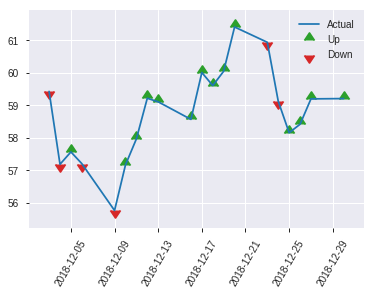


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.23245103266397585
RMSE: 0.48213175861373814
LogLoss: 0.656925599929704
Null degrees of freedom: 235
Residual degrees of freedom: 185
Null deviance: 328.8185624091997
Residual deviance: 310.06888316682034
AIC: 412.06888316682034
AUC: 0.6482698836957307
pr_auc: 0.5651495856834269
Gini: 0.2965397673914614
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.42239516897960466: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      60   67   0.5276   (67.0/127.0)
1      22   87   0.2018   (22.0/109.0)
Total  82   154  0.3771   (89.0/236.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.422395     0.661597  153
max f2                       0.243821     0.81571   225
max f0point5                 0.446377     0.601504  138
max accuracy                 0.446377     0.627119  138
max precision                0.677302     1         0
max recall                   0.108328     1         233
max specificity              0.677302     1         0
max absolute_mcc             0.422395     0.283325  153
max min_per_class_accuracy   0.481198     0.59633   112
max mean_per_class_accuracy  0.422395     0.635303  153

Gains/Lift Table: Avg response rate: 46.19 %, avg score: 45.94 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0127119                   0.625323           1.44343   1.44343            0.666667         0.64694   0.666667                    0.64694             0.0183486       0.0183486                  44.3425    44.3425
    2        0.0211864                   0.622717           1.08257   1.29908            0.5              0.624078  0.6                         0.637795            0.00917431      0.0275229                  8.25688    29.9083
    3        0.0338983                   0.61347            0         0.811927           0                0.618032  0.375                       0.630384            0               0.0275229                  -100       -18.8073
    4        0.0423729                   0.609037           2.16514   1.08257            1                0.612118  0.5                         0.626731            0.0183486       0.0458716                  116.514    8.25688
    5        0.0508475                   0.601769           0         0.902141           0                0.604897  0.416667                    0.623092            0               0.0458716                  -100       -9.78593
    6        0.101695                    0.58298            1.62385   1.263              0.75             0.595491  0.583333                    0.609292            0.0825688       0.12844                    62.3853    26.2997
    7        0.152542                    0.569169           1.44343   1.32314            0.666667         0.575788  0.611111                    0.598124            0.0733945       0.201835                   44.3425    32.314
    8        0.20339                     0.556287           1.62385   1.39832            0.75             0.563873  0.645833                    0.589561            0.0825688       0.284404                   62.3853    39.8318
    9        0.300847                    0.525878           1.12964   1.31128            0.521739         0.543844  0.605634                    0.574751            0.110092        0.394495                   12.9637    31.1281
    10       0.402542                    0.503298           0.992355  1.23071            0.458333         0.514443  0.568421                    0.559515            0.100917        0.495413                   -0.764526  23.071
    11       0.5                         0.473322           1.12964   1.21101            0.521739         0.490024  0.559322                    0.545971            0.110092        0.605505                   12.9637    21.1009
    12       0.601695                    0.442988           1.35321   1.23504            0.625            0.457978  0.570423                    0.531099            0.137615        0.743119                   35.3211    23.5043
    13       0.699153                    0.409697           0.753091  1.16786            0.347826         0.425863  0.539394                    0.516429            0.0733945       0.816514                   -24.6909   16.7862
    14       0.800847                    0.374154           0.541284  1.0883             0.25             0.39486   0.502646                    0.500992            0.0550459       0.87156                    -45.8716   8.82967
    15       0.898305                    0.323055           0.941364  1.07236            0.434783         0.353178  0.495283                    0.484956            0.0917431       0.963303                   -5.86358   7.23559
    16       1                           0.0424585          0.360856  1                  0.166667         0.233334  0.461864                    

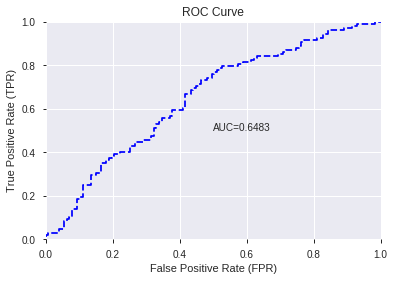

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


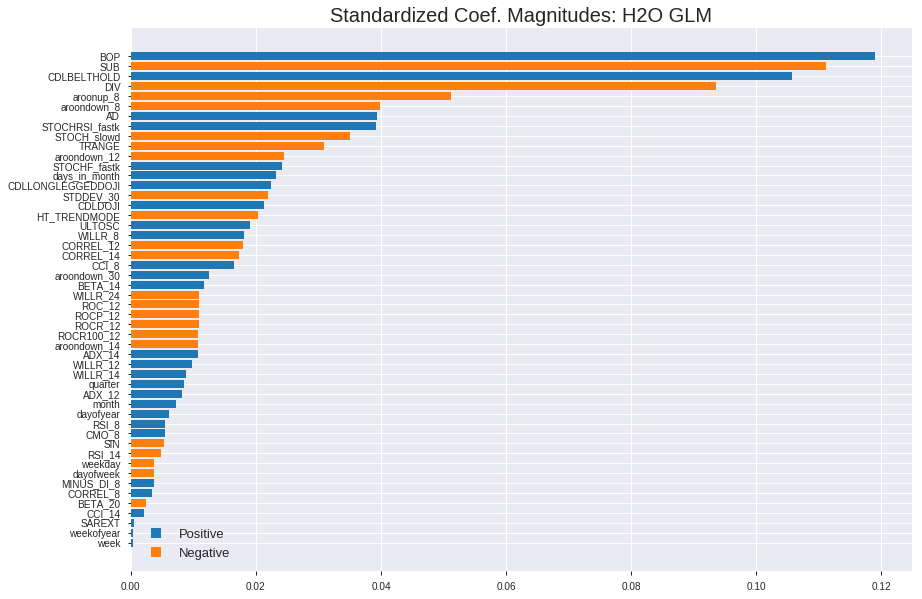

'log_likelihood'
--2019-08-24 00:28:49--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.146.219
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.146.219|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190824_002843_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190824_002843_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_58_sid_9850',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_58_s

['BOP',
 'SUB',
 'CDLBELTHOLD',
 'DIV',
 'aroonup_8',
 'aroondown_8',
 'AD',
 'STOCHRSI_fastk',
 'STOCH_slowd',
 'TRANGE',
 'aroondown_12',
 'STOCHF_fastk',
 'days_in_month',
 'CDLLONGLEGGEDDOJI',
 'STDDEV_30',
 'CDLDOJI',
 'HT_TRENDMODE',
 'ULTOSC',
 'WILLR_8',
 'CORREL_12',
 'CORREL_14',
 'CCI_8',
 'aroondown_30',
 'BETA_14',
 'WILLR_24',
 'ROC_12',
 'ROCP_12',
 'ROCR_12',
 'ROCR100_12',
 'aroondown_14',
 'ADX_14',
 'WILLR_12',
 'WILLR_14',
 'quarter',
 'ADX_12',
 'month',
 'dayofyear',
 'RSI_8',
 'CMO_8',
 'SIN',
 'RSI_14',
 'weekday',
 'dayofweek',
 'MINUS_DI_8',
 'CORREL_8',
 'BETA_20',
 'CCI_14',
 'SAREXT',
 'weekofyear',
 'week']

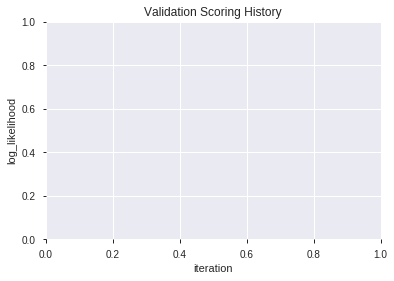

In [20]:
# GLM with top XGBoost features
model_train(feature_name='XGBF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190824_002902_model_4  0.686484  0.638581              0.348299  0.472991  0.223721
1               XGBoost_2_AutoML_20190824_002902  0.682005  0.638287              0.329228  0.473008  0.223737
2               XGBoost_1_AutoML_20190824_002902  0.672614  0.647555              0.343676  0.477069  0.227595
3  XGBoost_grid_1_AutoML_20190824_002902_model_2  0.661345  0.648062              0.386405  0.477871  0.228361
4  XGBoost_grid_1_AutoML_20190824_002902_model_7  0.658961  0.658755              0.370621  0.482759  0.233056
5  XGBoost_grid_1_AutoML_20190824_002902_model_6  0.653038  0.664644              0.379181  0.486321  0.236509
6  XGBoost_grid_1_AutoML_20190824_002902_model_5  0.647475  0.686535              0.371307  0.494286  0.244319
7  XGBoost_grid_1_AutoML_20190824_002902_model_3  0.646681  0.670604              0.377844  0.488091  0.238233
8               XGBoost_3_AutoML_20190824_002902  0.636206  0.664800              0.417973  0.486939  0.237110
9  XGBoost_grid_1_AutoML_20190824_002902_model_1  0.634400  0.683256              0.421224  0.493910  0.243947

variable  relative_importance  scaled_importance  percentage
0              BOP           801.769470           1.000000    0.226330
1              DIV           525.102600           0.654930    0.148230
2              SUB           325.148224           0.405538    0.091785
3           TRANGE           174.377823           0.217491    0.049225
4         WILLR_24           119.852432           0.149485    0.033833
5       MINUS_DI_8            91.591301           0.114236    0.025855
6      CDLBELTHOLD            87.014755           0.108528    0.024563
7         CORREL_8            80.681480           0.100629    0.022775
8           ADX_12            74.927750           0.093453    0.021151
9              SIN            74.480644           0.092895    0.021025
10         BETA_14            72.286644           0.090159    0.020406
11       dayofyear            71.492531           0.089168    0.020181
12          ULTOSC            70.287552           0.087666    0.019841
13         BETA_20            61.768974           0.077041    0.017437
14          RSI_14            59.200798           0.073838    0.016712
15          ROC_12            57.152954           0.071284    0.016134
16     STOCH_slowd            56.872528           0.070934    0.016054
17              AD            56.319221           0.070244    0.015898
18          ADX_14            53.737495           0.067024    0.015169
19          CCI_14            51.615799           0.064377    0.014570
20       CORREL_14            49.433289           0.061655    0.013954
21    STOCHF_fastk            47.893730           0.059735    0.013520
22     aroondown_8            41.478813           0.051734    0.011709
23    aroondown_30            39.248360           0.048952    0.011079
24       STDDEV_30            39.047916           0.048702    0.011023
25  STOCHRSI_fastk            34.273289           0.042747    0.009675
26       CORREL_12            32.255451           0.040230    0.009105
27       aroonup_8            31.862537           0.039740    0.008994
28   days_in_month            30.564545           0.038121    0.008628
29         WILLR_8            29.648569           0.036979    0.008369
30            week            28.824167           0.035951    0.008137
31          SAREXT            28.588711           0.035657    0.008070
32           CMO_8            28.382929           0.035400    0.008012
33       dayofweek            27.672354           0.034514    0.007812
34    aroondown_14            21.996578           0.027435    0.006209
35           CCI_8            18.897205           0.023569    0.005334
36        WILLR_14            17.472715           0.021793    0.004932
37    aroondown_12            17.440735           0.021753    0.004923
38        WILLR_12            11.824068           0.014747    0.003338

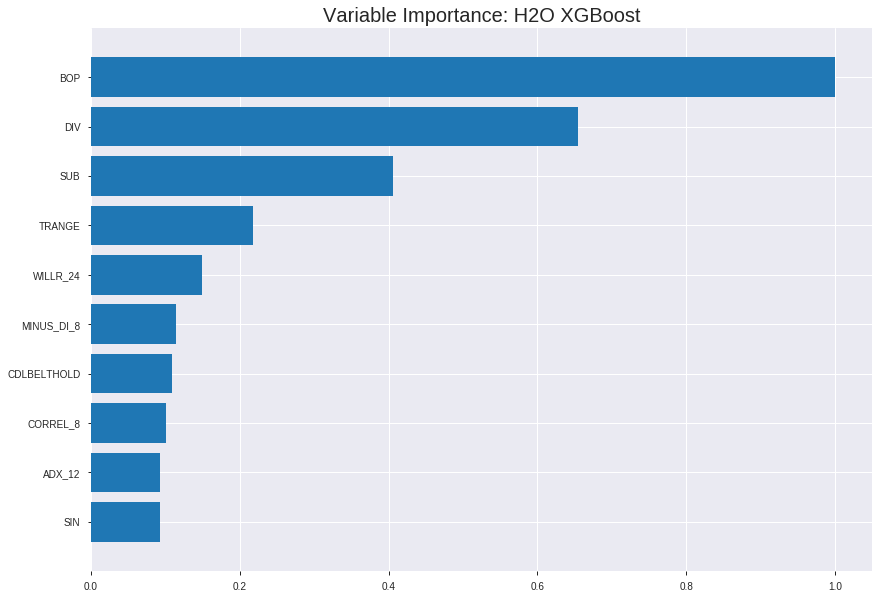

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190824_002902_model_4


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.1982151127424773
RMSE: 0.4452135585788884
LogLoss: 0.5832268132006657
Mean Per-Class Error: 0.2944990595427026
AUC: 0.78273673073532
pr_auc: 0.7885126972457814
Gini: 0.56547346147064
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.39611242711544037: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      339  456   0.5736   (456.0/795.0)
1      72   784   0.0841   (72.0/856.0)
Total  411  1240  0.3198   (528.0/1651.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.396112     0.748092  270
max f2                       0.287129     0.862561  339
max f0point5                 0.579852     0.721522  144
max accuracy                 0.54073      0.706239  177
max precision                0.786531     1         0
max recall                   0.200099     1         385
max specificity              0.786531     1         0
max absolute_mcc             0.54073      0.411347  177
max min_per_class_accuracy   0.547631     0.701887  171
max mean_per_class_accuracy  0.54073      0.705501  177

Gains/Lift Table: Avg response rate: 51.85 %, avg score: 51.69 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102968                   0.766108           1.92874   1.92874            1                0.774117  1                           0.774117            0.0198598       0.0198598                  92.8738   92.8738
    2        0.0205936                   0.749159           1.92874   1.92874            1                0.757538  1                           0.765827            0.0198598       0.0397196                  92.8738   92.8738
    3        0.0302847                   0.739909           1.68765   1.85159            0.875            0.743876  0.96                        0.758803            0.0163551       0.0560748                  68.7646   85.1589
    4        0.0405815                   0.735241           1.81528   1.84238            0.941176         0.737605  0.955224                    0.753424            0.0186916       0.0747664                  81.5283   84.2377
    5        0.0502726                   0.729086           1.5671    1.78931            0.8125           0.731937  0.927711                    0.749282            0.0151869       0.0899533                  56.71     78.9311
    6        0.100545                    0.696687           1.7196    1.75445            0.891566         0.711164  0.909639                    0.730223            0.0864486       0.176402                   71.9598   75.4455
    7        0.150212                    0.673816           1.57592   1.69542            0.817073         0.684256  0.879032                    0.715024            0.078271        0.254673                   57.592    69.5423
    8        0.200485                    0.653381           1.51046   1.64904            0.783133         0.663259  0.854985                    0.702044            0.0759346       0.330607                   51.0458   64.9042
    9        0.300424                    0.62092            1.39103   1.56321            0.721212         0.637328  0.810484                    0.680515            0.139019        0.469626                   39.1029   56.3211
    10       0.400363                    0.586989           1.15724   1.46187            0.6              0.60364   0.757943                    0.661326            0.115654        0.58528                    15.7243   46.1873
    11       0.500303                    0.549631           1.0988    1.38935            0.569697         0.568761  0.720339                    0.642835            0.109813        0.695093                   9.87964   38.9345
    12       0.600242                    0.503928           0.876699  1.30399            0.454545         0.528449  0.676085                    0.62379             0.0876168       0.78271                    -12.3301  30.3991
    13       0.700182                    0.439099           0.888389  1.24467            0.460606         0.474251  0.645329                    0.602446            0.088785        0.871495                   -11.1611  24.467
    14       0.800121                    0.358241           0.736427  1.18119            0.381818         0.397412  0.612415                    0.576836            0.0735981       0.945093                   -26.3573  18.1188
    15       0.900061                    0.282148           0.432505  1.09806            0.224242         0.323364  0.569314                    0.548691            0.0432243       0.988318                   -56.7495  9.80569
    16       1                           0.168206           0.116893  1                  0.0606061        0.230287  0.518474                    0.51687           



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.23309817643497455
RMSE: 0.482802419665617
LogLoss: 0.6583366734781224
Mean Per-Class Error: 0.362145461730524
AUC: 0.6447611862549623
pr_auc: 0.5807125732768917
Gini: 0.2895223725099245
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3188541829586029: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      57   184  0.7635   (184.0/241.0)
1      17   214  0.0736   (17.0/231.0)
Total  74   398  0.4258   (201.0/472.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.318854     0.680445  332
max f2                       0.218165     0.833333  389
max f0point5                 0.476502     0.62732   230
max accuracy                 0.476502     0.635593  230
max precision                0.750124     1         0
max recall                   0.218165     1         389
max specificity              0.750124     1         0
max absolute_mcc             0.47348      0.281788  235
max min_per_class_accuracy   0.511363     0.623377  191
max mean_per_class_accuracy  0.47348      0.637855  235

Gains/Lift Table: Avg response rate: 48.94 %, avg score: 48.26 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105932                   0.706732           0.817316  0.817316           0.4              0.724071  0.4                         0.724071            0.00865801      0.00865801                 -18.2684  -18.2684
    2        0.0211864                   0.689102           2.04329   1.4303             1                0.698928  0.7                         0.7115              0.021645        0.030303                   104.329   43.0303
    3        0.0317797                   0.67855            1.22597   1.36219            0.6              0.683427  0.666667                    0.702142            0.012987        0.04329                    22.5974   36.2193
    4        0.0402542                   0.673772           1.02165   1.2905             0.5              0.675399  0.631579                    0.696512            0.00865801      0.0519481                  2.1645    29.0499
    5        0.0508475                   0.665653           1.22597   1.27706            0.6              0.670994  0.625                       0.691196            0.012987        0.0649351                  22.5974   27.7056
    6        0.101695                    0.636357           0.936508  1.10678            0.458333         0.650545  0.541667                    0.67087             0.047619        0.112554                   -6.34921  10.6782
    7        0.150424                    0.616123           1.24374   1.15115            0.608696         0.625715  0.56338                     0.656242            0.0606061       0.17316                    24.3742   15.1149
    8        0.201271                    0.596972           1.19192   1.16145            0.583333         0.605769  0.568421                    0.643491            0.0606061       0.233766                   19.1919   16.1449
    9        0.300847                    0.570592           1.43465   1.25187            0.702128         0.585278  0.612676                    0.624223            0.142857        0.376623                   43.465    25.1875
    10       0.400424                    0.544238           1.21728   1.24327            0.595745         0.557714  0.608466                    0.607684            0.121212        0.497835                   21.7279   24.3272
    11       0.5                         0.508386           1.30423   1.25541            0.638298         0.527661  0.614407                    0.591747            0.12987         0.627706                   30.4228   25.5411
    12       0.599576                    0.474365           1.08686   1.22742            0.531915         0.490973  0.600707                    0.575011            0.108225        0.735931                   8.68564   22.7418
    13       0.699153                    0.416899           0.826011  1.17025            0.404255         0.450387  0.572727                    0.557261            0.0822511       0.818182                   -17.3989  17.0248
    14       0.798729                    0.344362           0.60864   1.10023            0.297872         0.382869  0.538462                    0.53552             0.0606061       0.878788                   -39.136   10.0233
    15       0.898305                    0.27112            0.695588  1.05538            0.340426         0.310873  0.516509                    0.510618            0.0692641       0.948052                   -30.4412  5.53786
    16       1                           0.171424           0.510823  1                  0.25             0.235461  0.489407                    0.482636        


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-24 00:29:07  1.954 sec   0                  0.5              0.693147            0.5             0                  1                0.481526                         0.5                0.693147              0.5               0                    1                  0.510593
    2019-08-24 00:29:07  2.029 sec   5                  0.486404         0.66622             0.72832         0.720799           1.63943          0.341611                         0.492933           0.67906               0.640333          0.594789             1.36219            0.427966
    2019-08-24 00:29:07  2.089 sec   10                 0.476615         0.646958            0.743945        0.748816           1.92874          0.350091                         0.488609           0.67041               0.64477           0.595604             1.22597            0.440678
    2019-08-24 00:29:07  2.146 sec   15                 0.46959          0.633035            0.750495        0.755895           1.92874          0.341611                         0.486289           0.665687              0.646046          0.58422              1.22597            0.455508
    2019-08-24 00:29:07  2.191 sec   20                 0.464088         0.621968            0.753513        0.755685           1.92874          0.341005                         0.4853             0.663563              0.638636          0.576735             1.22597            0.427966
    2019-08-24 00:29:07  2.238 sec   25                 0.460116         0.613833            0.756303        0.758499           1.92874          0.344034                         0.483943           0.660799              0.641618          0.5805               1.22597            0.383475
    2019-08-24 00:29:07  2.287 sec   30                 0.456369         0.606299            0.764317        0.76728            1.92874          0.333737                         0.483632           0.660105              0.641645          0.577347             1.22597            0.381356
    2019-08-24 00:29:07  2.339 sec   35                 0.453389         0.600073            0.767913        0.771556           1.92874          0.328892                         0.48286            0.658534              0.643674          0.582145             1.22597            0.375
    2019-08-24 00:29:07  2.392 sec   40                 0.450961         0.594903            0.769827        0.774064           1.92874          0.32768                          0.482887           0.658513              0.643127          0.577362             1.22597            0.379237
    2019-08-24 00:29:07  2.441 sec   45                 0.447872         0.588571            0.776422        0.781981           1.92874          0.317989                         0.483154           0.659093              0.642318          0.575362             0.817316           0.425847
    2019-08-24 00:29:07  2.496 sec   50                 0.445214         0.583227            0.782737        0.788513           1.92874          0.319806                         0.482802           0.658337              0.644761          0.580713             0.817316           0.425847

Variable Importances: 


variable      relative_importance    scaled_importance     percentage
------------  ---------------------  --------------------  ---------------------
BOP           801.7694702148438      1.0                   0.22632954874341546
DIV           525.1026000976562      0.65492965198207      0.14822993259178402
SUB           325.1482238769531      0.40553829492887244   0.09178529928942583
TRANGE        174.37782287597656     0.21749122329296217   0.04922469042354954
WILLR_24      119.85243225097656     0.14948490395731914   0.03383285085661284
---           ---                    ---                   ---
aroondown_14  21.996578216552734     0.027435040911022078  0.006209360429148768
CCI_8         18.897205352783203     0.023569375057046597  0.005334446020825668
WILLR_14      17.472715377807617     0.021792692322302562  0.004932330219210833
aroondown_12  17.44073486328125      0.02175280490364368   0.0049233025177452296
WILLR_12      11.824068069458008     0.014747466084346673  0.0033377873439790063


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6610169491525424)

('F1', 0.6743295019157088)

('auc', 0.686484143610489)

('logloss', 0.6385805770589681)

('mean_per_class_error', 0.34616773820703606)

('rmse', 0.4729912237237368)

('mse', 0.22372069771967804)

xgboost prediction progress: |████████████████████████████████████████████| 100%


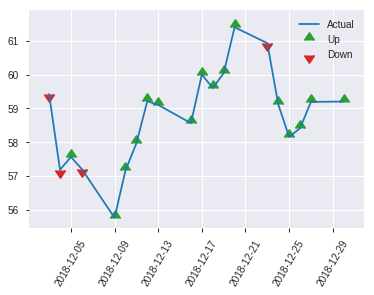


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.22372069771967804
RMSE: 0.4729912237237368
LogLoss: 0.6385805770589681
Mean Per-Class Error: 0.34616773820703606
AUC: 0.686484143610489
pr_auc: 0.6355245908640874
Gini: 0.3729682872209781
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.44608074426651: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      63   64   0.5039   (64.0/127.0)
1      21   88   0.1927   (21.0/109.0)
Total  84   152  0.3602   (85.0/236.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.446081     0.67433   151
max f2                       0.219854     0.814649  232
max f0point5                 0.577548     0.634573  86
max accuracy                 0.577548     0.661017  86
max precision                0.733168     1         0
max recall                   0.219854     1         232
max specificity              0.733168     1         0
max absolute_mcc             0.446081     0.315917  151
max min_per_class_accuracy   0.54058      0.637795  115
max mean_per_class_accuracy  0.564163     0.653832  92

Gains/Lift Table: Avg response rate: 46.19 %, avg score: 49.11 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0127119                   0.717035           2.16514   2.16514            1                0.727052  1                           0.727052            0.0275229       0.0275229                  116.514   116.514
    2        0.0211864                   0.704268           2.16514   2.16514            1                0.710309  1                           0.720355            0.0183486       0.0458716                  116.514   116.514
    3        0.0338983                   0.700078           2.16514   2.16514            1                0.701119  1                           0.713141            0.0275229       0.0733945                  116.514   116.514
    4        0.0423729                   0.693541           2.16514   2.16514            1                0.695584  1                           0.70963             0.0183486       0.0917431                  116.514   116.514
    5        0.0508475                   0.681431           1.08257   1.98471            0.5              0.690168  0.916667                    0.706386            0.00917431      0.100917                   8.25688   98.4709
    6        0.101695                    0.649593           0.721713  1.35321            0.333333         0.670613  0.625                       0.688499            0.0366972       0.137615                   -27.8287  35.3211
    7        0.152542                    0.6233             1.263     1.32314            0.583333         0.630652  0.611111                    0.669217            0.0642202       0.201835                   26.2997   32.314
    8        0.20339                     0.613611           1.44343   1.35321            0.666667         0.617702  0.625                       0.656338            0.0733945       0.275229                   44.3425   35.3211
    9        0.300847                    0.592675           1.60032   1.43326            0.73913          0.602378  0.661972                    0.638858            0.155963        0.431193                   60.0319   43.326
    10       0.402542                    0.56345            1.263     1.39025            0.583333         0.579438  0.642105                    0.623847            0.12844         0.559633                   26.2997   39.0246
    11       0.5                         0.533407           0.941364  1.30275            0.434783         0.549813  0.601695                    0.609417            0.0917431       0.651376                   -5.86358  30.2752
    12       0.601695                    0.473173           1.08257   1.26554            0.5              0.503901  0.584507                    0.591583            0.110092        0.761468                   8.25688   26.5538
    13       0.699153                    0.407847           0.847228  1.20723            0.391304         0.442753  0.557576                    0.570837            0.0825688       0.844037                   -15.2772  20.7228
    14       0.800847                    0.339509           0.631498  1.13412            0.291667         0.368942  0.52381                     0.545199            0.0642202       0.908257                   -36.8502  13.412
    15       0.898305                    0.276003           0.376546  1.05193            0.173913         0.308863  0.485849                    0.519559            0.0366972       0.944954                   -62.3454  5.19301
    16       1                           0.165839           0.541284  1                  0.25             0.239906  0.461864                    0.49112             

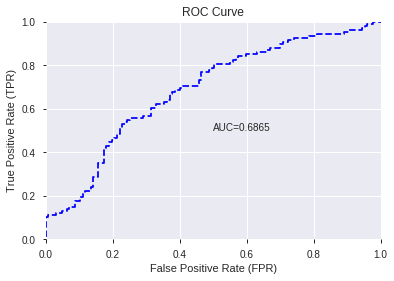

This function is available for GLM models only


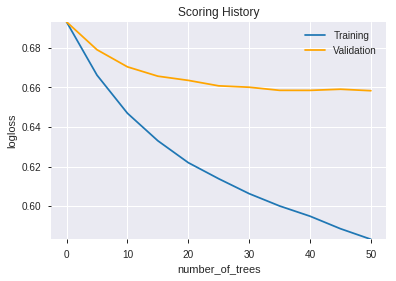

--2019-08-24 00:29:16--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.98.171
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.98.171|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.util.ArrayList$SubList.checkForComodification(ArrayList.java:1443)
	at java.base/java.util.ArrayList$SubList.toArray(ArrayList.java:1262)
	at java.base/java.lang.String.split(String.java:2315)
	at java.base/java.lang.String.split(String.java:2364)
	at

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190824_002902_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190824_002902_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_66_sid_9850',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'DIV',
 'SUB',
 'TRANGE',
 'WILLR_24',
 'MINUS_DI_8',
 'CDLBELTHOLD',
 'CORREL_8',
 'ADX_12',
 'SIN',
 'BETA_14',
 'dayofyear',
 'ULTOSC',
 'BETA_20',
 'RSI_14',
 'ROC_12',
 'STOCH_slowd',
 'AD',
 'ADX_14',
 'CCI_14',
 'CORREL_14',
 'STOCHF_fastk',
 'aroondown_8',
 'aroondown_30',
 'STDDEV_30',
 'STOCHRSI_fastk',
 'CORREL_12',
 'aroonup_8',
 'days_in_month',
 'WILLR_8',
 'week',
 'SAREXT',
 'CMO_8',
 'dayofweek',
 'aroondown_14',
 'CCI_8',
 'WILLR_14',
 'aroondown_12',
 'WILLR_12']

In [21]:
# XGBoost with top XGBoost features
model_train(feature_name='XGBF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

In [0]:
# PCA
try:
  del xgb_features,glm_features,dl_features
except:
  pass
gc.collect()

if features_to_include is True or 'PCA' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.pca import H2OPrincipalComponentAnalysisEstimator
      h2o_model = H2OPrincipalComponentAnalysisEstimator(seed=1, k=PCA_k, pca_method="GramSVD", max_iterations=10000)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OPrincipalComponentAnalysisEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [23]:
# DeepLearning with PCA
model_train(feature_name='PCA',model_algo="DeepLearning",training_frame=training_frame)

[]

In [24]:
# GLM with PCA
model_train(feature_name='PCA',model_algo="GLM",training_frame=training_frame)

[]

In [25]:
# XGBoost with PCA
model_train(feature_name='PCA',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# Generalized Low Rank
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'GLRM' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator

      h2o_model = H2OGeneralizedLowRankEstimator(seed=1, k=GLRM_k)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OGeneralizedLowRankEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [27]:
# DeepLearning with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="DeepLearning",training_frame=training_frame)

[]

In [28]:
# GLM with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="GLM",training_frame=training_frame)

[]

In [29]:
# XGBoost with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# High Correlation Filter 
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'HCF' in features_to_include:
  corr_matrix = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).corr().abs()

  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

  features_list = [column for column in upper.columns if not any(upper[column] > HCF_threshold)]

  del corr_matrix, upper
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [31]:
# DeepLearning with low correlation features
model_train(feature_name='HCF',model_algo="DeepLearning",features_list=features_list)

[]

In [32]:
# GLM with low correlation features
model_train(feature_name='HCF',model_algo="GLM",features_list=features_list)

[]

In [33]:
# XGBoost with low correlation features
model_train(feature_name='HCF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
#	Low Variance Filter  
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'LVF' in features_to_include:
  df_variance = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).var()
  features_list = [column for column in df_variance.index if df_variance[column]  > LVF_threshold]

  del df_variance
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [35]:
# DeepLearning with Low Variance features  
model_train(feature_name='LVF',model_algo="DeepLearning",features_list=features_list)

[]

In [36]:
# GLM with Low Variance features  
model_train(feature_name='LVF',model_algo="GLM",features_list=features_list)

[]

In [37]:
# XGBoost with Low Variance features  
model_train(feature_name='LVF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select k best features
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'KBest' in features_to_include:
  from sklearn.feature_selection import SelectKBest
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectKBest(score_func=f_classif, k=select_k).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectKBest, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [39]:
# DeepLearning with Select k best features 
model_train(feature_name='KBest',model_algo="DeepLearning",features_list=features_list)

[]

In [40]:
# GLM with Select k best features
model_train(feature_name='KBest',model_algo="GLM",features_list=features_list)

[]

In [41]:
# XGBoost with Select k best features
model_train(feature_name='KBest',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select Percentile
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Percentile' in features_to_include:
  from sklearn.feature_selection import SelectPercentile
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectPercentile(score_func=f_classif, percentile=select_percentile).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectPercentile, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [43]:
# DeepLearning with Select Percentile features  
model_train(feature_name='Percentile',model_algo="DeepLearning",features_list=features_list)

[]

In [44]:
# GLM with Select Percentile features  
model_train(feature_name='Percentile',model_algo="GLM",features_list=features_list)

[]

In [45]:
# XGBoost with Select Percentile features  
model_train(feature_name='Percentile',model_algo="XGBoost",features_list=features_list)

[]

In [46]:
# Select Family-wise error
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Fwe' in features_to_include:
  from sklearn.feature_selection import SelectFwe
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectFwe(score_func=f_classif, alpha=select_alpha).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectFwe, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

10

['BOP',
 'aroondown_8',
 'CCI_8',
 'WILLR_8',
 'STOCHF_fastk',
 'STOCHRSI_fastk',
 'CDLBELTHOLD',
 'CDLLONGLINE',
 'DIV',
 'SUB']

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190824_002925_model_5  0.683306  0.638047              0.397602  0.473639  0.224334
1  DeepLearning_grid_1_AutoML_20190824_002925_model_3  0.682511  0.649187              0.394315  0.475273  0.225885
2  DeepLearning_grid_1_AutoML_20190824_002925_model_9  0.681789  0.641062              0.361446  0.474253  0.224916
3  DeepLearning_grid_1_AutoML_20190824_002925_model_6  0.680705  0.637920              0.343061  0.472476  0.223234
4  DeepLearning_grid_1_AutoML_20190824_002925_model_4  0.680127  0.644837              0.382504  0.475506  0.226106
5  DeepLearning_grid_1_AutoML_20190824_002925_model_8  0.679405  0.637653              0.391028  0.472929  0.223662
6  DeepLearning_grid_1_AutoML_20190824_002925_model_1  0.676660  0.694327              0.395615  0.488139  0.238280
7  DeepLearning_grid_1_AutoML_20190824_002925_model_2  0.674204  0.738783              0.377230  0.511644  0.261780
8  DeepLearning_grid_1_AutoML_20190824_002925_model_7  0.649642  0.846366              0.411363  0.521672  0.272142
9               DeepLearning_1_AutoML_20190824_002925  0.622408  0.948066              0.402803  0.547580  0.299844

variable  relative_importance  scaled_importance  percentage
0             BOP             1.000000           1.000000    0.137718
1             DIV             0.961248           0.961248    0.132381
2             SUB             0.884811           0.884811    0.121854
3  STOCHRSI_fastk             0.744449           0.744449    0.102524
4     CDLBELTHOLD             0.690455           0.690455    0.095088
5           CCI_8             0.642894           0.642894    0.088538
6     aroondown_8             0.615874           0.615874    0.084817
7         WILLR_8             0.610292           0.610292    0.084048
8    STOCHF_fastk             0.572587           0.572587    0.078855
9     CDLLONGLINE             0.538620           0.538620    0.074177

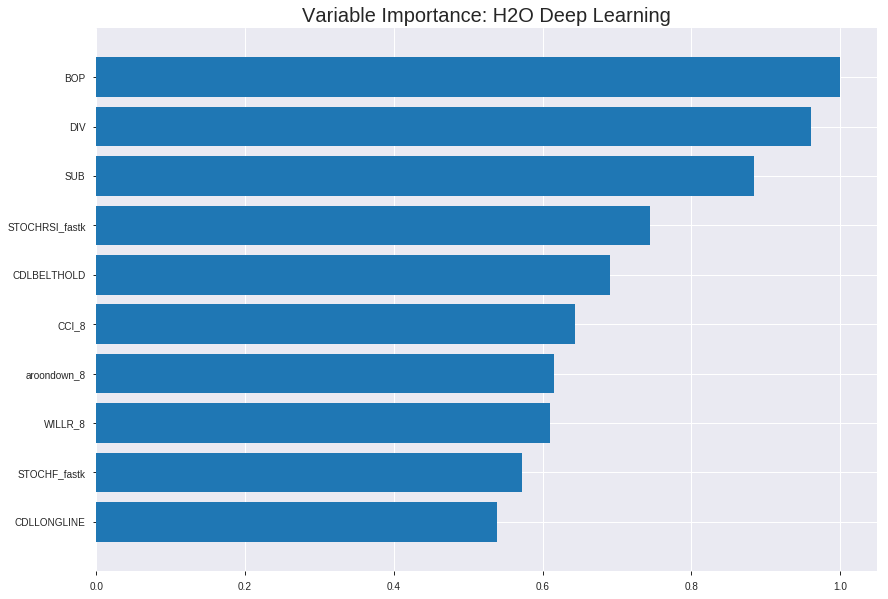

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190824_002925_model_5


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.22145458967154621
RMSE: 0.47058961917104186
LogLoss: 0.6326247846670671
Mean Per-Class Error: 0.3680420854640569
AUC: 0.6862862223005936
pr_auc: 0.6748722541828088
Gini: 0.3725724446011871
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.336413299554505: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      196  599   0.7535   (599.0/795.0)
1      38   818   0.0444   (38.0/856.0)
Total  234  1417  0.3858   (637.0/1651.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.336413     0.719754  312
max f2                       0.274307     0.852227  346
max f0point5                 0.499666     0.646004  218
max accuracy                 0.499666     0.638401  218
max precision                0.876479     1         0
max recall                   0.177817     1         390
max specificity              0.876479     1         0
max absolute_mcc             0.420037     0.29327   268
max min_per_class_accuracy   0.572696     0.626415  158
max mean_per_class_accuracy  0.553943     0.631958  174

Gains/Lift Table: Avg response rate: 51.85 %, avg score: 52.91 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102968                   0.752901           1.58837   1.58837            0.823529         0.781091  0.823529                    0.781091            0.0163551       0.0163551                  58.8373   58.8373
    2        0.0205936                   0.73015            1.36146   1.47492            0.705882         0.741156  0.764706                    0.761123            0.0140187       0.0303738                  36.1462   47.4918
    3        0.0302847                   0.720646           1.44655   1.46584            0.75             0.726212  0.76                        0.749952            0.0140187       0.0443925                  44.6554   46.5841
    4        0.0405815                   0.708577           1.58837   1.49693            0.823529         0.714673  0.776119                    0.741               0.0163551       0.0607477                  58.8373   49.6931
    5        0.0502726                   0.704015           1.5671    1.51046            0.8125           0.705962  0.783133                    0.734246            0.0151869       0.0759346                  56.71     51.0458
    6        0.100545                    0.674848           1.51046   1.51046            0.783133         0.688627  0.783133                    0.711437            0.0759346       0.151869                   51.0458   51.0458
    7        0.150212                    0.655489           1.27014   1.431              0.658537         0.664962  0.741935                    0.69607             0.0630841       0.214953                   27.0145   43.0999
    8        0.200485                    0.64015            1.18513   1.36935            0.614458         0.647669  0.70997                     0.683933            0.0595794       0.274533                   18.5128   36.9346
    9        0.300424                    0.619836           1.21569   1.31823            0.630303         0.629835  0.683468                    0.665937            0.121495        0.396028                   21.569    31.823
    10       0.400363                    0.597985           1.204     1.28972            0.624242         0.608555  0.668684                    0.651613            0.120327        0.516355                   20.4      28.9716
    11       0.500303                    0.574298           1.07542   1.24691            0.557576         0.58629   0.646489                    0.638565            0.107477        0.623832                   7.54177   24.6908
    12       0.600242                    0.539715           1.02866   1.21057            0.533333         0.557578  0.627649                    0.62508             0.102804        0.726636                   2.86604   21.057
    13       0.700182                    0.484575           0.946835  1.17293            0.490909         0.515066  0.608131                    0.609378            0.0946262       0.821262                   -5.31648  17.2927
    14       0.800121                    0.41041            0.876699  1.13593            0.454545         0.448716  0.588948                    0.58931             0.0876168       0.908879                   -12.3301  13.5926
    15       0.900061                    0.291162           0.631223  1.07989            0.327273         0.347975  0.559892                    0.562513            0.0630841       0.971963                   -36.8777  7.98858
    16       1                           0.130941           0.280544  1                  0.145455         0.228462  0.518474                    0.529128           



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.2401971962970566
RMSE: 0.4900991698595873
LogLoss: 0.6747675207579541
Mean Per-Class Error: 0.3827037416249035
AUC: 0.6122756911138654
pr_auc: 0.5615343338137888
Gini: 0.22455138222773074
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.24983625045888716: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      57   184  0.7635   (184.0/241.0)
1      18   213  0.0779   (18.0/231.0)
Total  75   397  0.428    (202.0/472.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.249836     0.678344  332
max f2                       0.0997587    0.829741  395
max f0point5                 0.490746     0.609362  206
max accuracy                 0.490746     0.616525  206
max precision                0.80927      1         0
max recall                   0.0997587    1         395
max specificity              0.80927      1         0
max absolute_mcc             0.490746     0.235081  206
max min_per_class_accuracy   0.505242     0.606061  191
max mean_per_class_accuracy  0.490746     0.617296  206

Gains/Lift Table: Avg response rate: 48.94 %, avg score: 45.95 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105932                   0.745803           1.63463   1.63463            0.8              0.774276  0.8                         0.774276            0.017316        0.017316                   63.4632   63.4632
    2        0.0211864                   0.713537           1.22597   1.4303             0.6              0.729292  0.7                         0.751784            0.012987        0.030303                   22.5974   43.0303
    3        0.0317797                   0.694612           1.63463   1.49841            0.8              0.702476  0.733333                    0.735348            0.017316        0.047619                   63.4632   49.8413
    4        0.0402542                   0.672301           1.53247   1.50558            0.75             0.68763   0.736842                    0.725302            0.012987        0.0606061                  53.2468   50.5582
    5        0.0508475                   0.652344           0         1.19192            0                0.663528  0.583333                    0.712432            0               0.0606061                  -100      19.1919
    6        0.101695                    0.621697           1.02165   1.10678            0.5              0.633668  0.541667                    0.67305             0.0519481       0.112554                   2.1645    10.6782
    7        0.150424                    0.606805           1.06606   1.09359            0.521739         0.614216  0.535211                    0.653991            0.0519481       0.164502                   6.60644   9.35919
    8        0.201271                    0.595115           0.766234  1.01089            0.375            0.60088   0.494737                    0.640573            0.038961        0.203463                   -23.3766  1.08909
    9        0.300847                    0.574701           1.3477    1.12237            0.659574         0.584147  0.549296                    0.621897            0.134199        0.337662                   34.7702   12.2371
    10       0.400424                    0.544463           1.30423   1.16759            0.638298         0.560566  0.571429                    0.606646            0.12987         0.467532                   30.4228   16.7594
    11       0.5                         0.503449           1.43465   1.22078            0.702128         0.526277  0.597458                    0.59064             0.142857        0.61039                    43.465    22.0779
    12       0.599576                    0.455249           0.912959  1.16966            0.446809         0.482552  0.572438                    0.572689            0.0909091       0.701299                   -8.70406  16.9657
    13       0.699153                    0.394258           0.912959  1.1331             0.446809         0.425957  0.554545                    0.551791            0.0909091       0.792208                   -8.70406  13.3097
    14       0.798729                    0.28532            0.912959  1.10565            0.446809         0.342093  0.541114                    0.525648            0.0909091       0.883117                   -8.70406  10.5653
    15       0.898305                    0.196722           0.60864   1.05056            0.297872         0.242274  0.514151                    0.494236            0.0606061       0.943723                   -39.136   5.05595
    16       1                           0.0877312          0.553391  1                  0.270833         0.152631  0.489407                    0.459497         


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-24 00:32:38  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-24 00:32:40  1 min 48.303 sec  1579 obs/sec      2         1             3302       0.479502         0.65096             0.0790551      0.655677        0.649194           1.47492          0.40218                          0.495262           0.6873                0.0184216        0.601848          0.573534             1.22597            0.466102
    2019-08-24 00:32:46  1 min 54.988 sec  2843 obs/sec      14        7             23114      0.47059          0.632625            0.112971       0.686286        0.674872           1.58837          0.385827                         0.490099           0.674768              0.0387798        0.612276          0.561534             1.63463            0.427966
    2019-08-24 00:32:53  2 min  1.839 sec  3223 obs/sec      28        14            46228      0.469889         0.631659            0.11561        0.688519        0.678366           1.70183          0.370079                         0.491502           0.679322              0.0332694        0.610417          0.564033             2.04329            0.425847
    2019-08-24 00:33:00  2 min  8.515 sec  3402 obs/sec      42        21            69342      0.468655         0.628873            0.120248       0.702418        0.691213           1.58837          0.371896                         0.493025           0.684918              0.0272675        0.622209          0.58483              2.04329            0.451271
    2019-08-24 00:33:06  2 min 15.066 sec  3513 obs/sec      56        28            92456      0.466864         0.624962            0.126959       0.705499        0.693909           1.70183          0.365839                         0.498553           0.70185               0.00533312       0.606465          0.578198             2.04329            0.510593
    2019-08-24 00:33:13  2 min 21.545 sec  3595 obs/sec      70        35            115570     0.46076          0.611542            0.149638       0.720434        0.707347           1.70183          0.368262                         0.503905           0.738027              -0.0161377       0.601381          0.577297             1.63463            0.510593
    2019-08-24 00:33:14  2 min 22.223 sec  3592 obs/sec      70        35            115570     0.47059          0.632625            0.112971       0.686286        0.674872           1.58837          0.385827                         0.490099           0.674768              0.0387798        0.612276          0.561534             1.63463            0.427966

Variable Importances: 


variable        relative_importance    scaled_importance    percentage
--------------  ---------------------  -------------------  ------------
BOP             1                      1                    0.137718
DIV             0.961248               0.961248             0.132381
SUB             0.884811               0.884811             0.121854
STOCHRSI_fastk  0.744449               0.744449             0.102524
CDLBELTHOLD     0.690455               0.690455             0.0950879
CCI_8           0.642894               0.642894             0.0885379
aroondown_8     0.615874               0.615874             0.0848168
WILLR_8         0.610292               0.610292             0.084048
STOCHF_fastk    0.572587               0.572587             0.0788554
CDLLONGLINE     0.53862                0.53862              0.0741775

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.652542372881356)

('F1', 0.6732026143790849)

('auc', 0.6833056418406416)

('logloss', 0.638047178633461)

('mean_per_class_error', 0.3416889402586145)

('rmse', 0.47363879801576686)

('mse', 0.2243337109858204)

deeplearning prediction progress: |███████████████████████████████████████| 100%


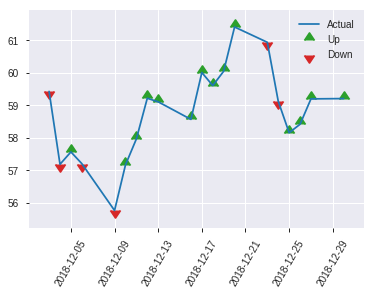


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.2243337109858204
RMSE: 0.47363879801576686
LogLoss: 0.638047178633461
Mean Per-Class Error: 0.3416889402586145
AUC: 0.6833056418406416
pr_auc: 0.6133547553520181
Gini: 0.36661128368128315
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.20084221609554329: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      33   94   0.7402   (94.0/127.0)
1      6    103  0.055    (6.0/109.0)
Total  39   197  0.4237   (100.0/236.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.200842     0.673203  196
max f2                       0.165553     0.832061  218
max f0point5                 0.425427     0.624025  132
max accuracy                 0.427682     0.652542  130
max precision                0.770064     1         0
max recall                   0.165553     1         218
max specificity              0.770064     1         0
max absolute_mcc             0.425427     0.318282  132
max min_per_class_accuracy   0.476784     0.637795  115
max mean_per_class_accuracy  0.425427     0.658311  132

Gains/Lift Table: Avg response rate: 46.19 %, avg score: 41.87 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0127119                   0.722041           2.16514   2.16514            1                0.746313  1                           0.746313            0.0275229       0.0275229                  116.514    116.514
    2        0.0211864                   0.692171           2.16514   2.16514            1                0.704068  1                           0.729415            0.0183486       0.0458716                  116.514    116.514
    3        0.0338983                   0.684848           0.721713  1.62385            0.333333         0.688084  0.75                        0.713916            0.00917431      0.0550459                  -27.8287   62.3853
    4        0.0423729                   0.665602           0         1.29908            0                0.677933  0.6                         0.706719            0               0.0550459                  -100       29.9083
    5        0.0508475                   0.65012            2.16514   1.44343            1                0.654641  0.666667                    0.69804             0.0183486       0.0733945                  116.514    44.3425
    6        0.101695                    0.6156             1.08257   1.263              0.5              0.629034  0.583333                    0.663537            0.0550459       0.12844                    8.25688    26.2997
    7        0.152542                    0.600533           1.80428   1.44343            0.833333         0.607473  0.666667                    0.644849            0.0917431       0.220183                   80.4281    44.3425
    8        0.20339                     0.584268           1.44343   1.44343            0.666667         0.591939  0.666667                    0.631621            0.0733945       0.293578                   44.3425    44.3425
    9        0.300847                    0.54785            1.12964   1.34178            0.521739         0.565873  0.619718                    0.610323            0.110092        0.40367                    12.9637    34.1775
    10       0.402542                    0.518932           1.08257   1.27629            0.5              0.533413  0.589474                    0.590893            0.110092        0.513761                   8.25688    27.6292
    11       0.5                         0.471057           1.41205   1.30275            0.652174         0.491516  0.601695                    0.571523            0.137615        0.651376                   41.2046    30.2752
    12       0.601695                    0.381691           0.992355  1.25029            0.458333         0.428815  0.577465                    0.547403            0.100917        0.752294                   -0.764526  25.0291
    13       0.699153                    0.278244           0.847228  1.19411            0.391304         0.32629   0.551515                    0.516581            0.0825688       0.834862                   -15.2772   19.4106
    14       0.800847                    0.211742           0.631498  1.12266            0.291667         0.240345  0.518519                    0.481504            0.0642202       0.899083                   -36.8502   12.2664
    15       0.898305                    0.173386           0.658955  1.07236            0.304348         0.194071  0.495283                    0.45032             0.0642202       0.963303                   -34.1045   7.23559
    16       1                           0.0682861          0.360856  1                  0.166667         0.139317  0.461864                    

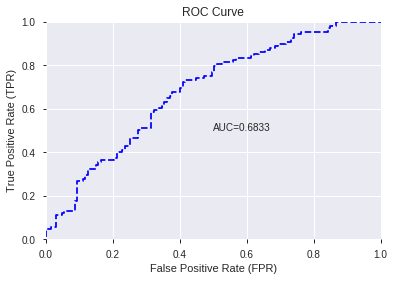

This function is available for GLM models only


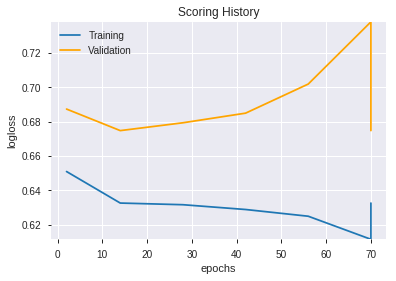

--2019-08-24 00:38:03--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.230.19
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.230.19|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190824_002925_model_5',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190824_002925_model_5',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_74_sid_9850',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'DIV',
 'SUB',
 'STOCHRSI_fastk',
 'CDLBELTHOLD',
 'CCI_8',
 'aroondown_8',
 'WILLR_8',
 'STOCHF_fastk',
 'CDLLONGLINE']

In [47]:
# DeepLearning with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190824_003810_model_1  0.654193  0.657293              0.393629  0.482475  0.232782

variable  relative_importance  scaled_importance  percentage
0             SUB             0.119146           1.000000    0.203139
1             BOP             0.116657           0.979102    0.198893
2     CDLBELTHOLD             0.101662           0.853250    0.173328
3             DIV             0.098447           0.826271    0.167848
4  STOCHRSI_fastk             0.039545           0.331903    0.067422
5     CDLLONGLINE             0.037364           0.313593    0.063703
6     aroondown_8             0.034208           0.287112    0.058324
7    STOCHF_fastk             0.022119           0.185648    0.037712
8         WILLR_8             0.009982           0.083777    0.017018
9           CCI_8             0.007398           0.062089    0.012613

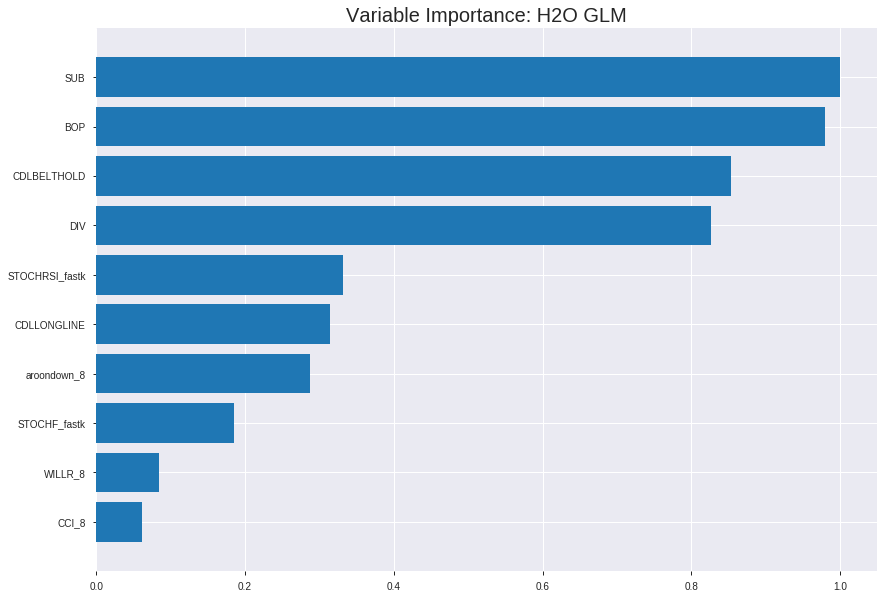

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190824_003810_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.23211954027281262
RMSE: 0.4817878581625035
LogLoss: 0.6565417502458621
Null degrees of freedom: 1650
Residual degrees of freedom: 1640
Null deviance: 2286.517691569208
Residual deviance: 2167.900859311837
AIC: 2189.900859311837
AUC: 0.6618306589078939
pr_auc: 0.6351961668864516
Gini: 0.3236613178157879
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4397181222614977: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      213  582   0.7321   (582.0/795.0)
1      66   790   0.0771   (66.0/856.0)
Total  279  1372  0.3925   (648.0/1651.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.439718     0.709156  281
max f2                       0.33405      0.845786  359
max f0point5                 0.528302     0.646749  179
max accuracy                 0.528302     0.634161  179
max precision                0.880884     1         0
max recall                   0.206229     1         396
max specificity              0.880884     1         0
max absolute_mcc             0.528302     0.266694  179
max min_per_class_accuracy   0.533149     0.620126  173
max mean_per_class_accuracy  0.528302     0.633168  179

Gains/Lift Table: Avg response rate: 51.85 %, avg score: 51.85 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102968                   0.682163           1.24801   1.24801            0.647059         0.711774  0.647059                    0.711774            0.0128505       0.0128505                  24.8007   24.8007
    2        0.0205936                   0.669599           1.47492   1.36146            0.764706         0.675012  0.705882                    0.693393            0.0151869       0.0280374                  47.4918   36.1462
    3        0.0302847                   0.656202           1.5671    1.42727            0.8125           0.66212   0.74                        0.683386            0.0151869       0.0432243                  56.71     42.7266
    4        0.0405815                   0.648805           1.24801   1.38178            0.647059         0.651923  0.716418                    0.675403            0.0128505       0.0560748                  24.8007   38.1783
    5        0.0502726                   0.638857           1.32601   1.37103            0.6875           0.644977  0.710843                    0.669538            0.0128505       0.0689252                  32.6008   37.1031
    6        0.100545                    0.611669           1.16189   1.26646            0.60241          0.623656  0.656627                    0.646597            0.0584112       0.127336                   16.1891   26.6461
    7        0.150212                    0.597243           1.27014   1.26768            0.658537         0.604236  0.657258                    0.63259             0.0630841       0.190421                   27.0145   26.7679
    8        0.200485                    0.584737           1.32456   1.28194            0.686747         0.590076  0.664653                    0.62193             0.0665888       0.257009                   32.4555   28.1941
    9        0.300424                    0.565421           1.27414   1.27934            0.660606         0.574601  0.663306                    0.606185            0.127336        0.384346                   27.4136   27.9345
    10       0.400363                    0.549725           1.14555   1.24595            0.593939         0.557952  0.645991                    0.594145            0.114486        0.498832                   14.5554   24.5947
    11       0.500303                    0.53387            1.18062   1.2329             0.612121         0.541788  0.639225                    0.583686            0.117991        0.616822                   18.0622   23.2898
    12       0.600242                    0.514198           1.05204   1.20279            0.545455         0.524228  0.623613                    0.573787            0.10514         0.721963                   5.20391   20.2785
    13       0.700182                    0.491227           0.946835  1.16625            0.490909         0.502433  0.604671                    0.563602            0.0946262       0.816589                   -5.31648  16.6253
    14       0.800121                    0.453902           0.806563  1.12133            0.418182         0.474294  0.581378                    0.552447            0.0806075       0.897196                   -19.3437  12.1326
    15       0.900061                    0.395226           0.68967   1.0734             0.357576         0.426226  0.556528                    0.538432            0.0689252       0.966121                   -31.033   7.33961
    16       1                           0.129876           0.33899   1                  0.175758         0.338728  0.518474                    0.518474         



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.24155082095462627
RMSE: 0.4914781998772949
LogLoss: 0.675909479568019
Null degrees of freedom: 471
Residual degrees of freedom: 461
Null deviance: 655.7149900197271
Residual deviance: 638.0585487122099
AIC: 660.0585487122099
AUC: 0.5993156221371989
pr_auc: 0.5576326947401485
Gini: 0.19863124427439782
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3796478081961752: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      50   191  0.7925   (191.0/241.0)
1      18   213  0.0779   (18.0/231.0)
Total  68   404  0.4428   (209.0/472.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.379648     0.670866  335
max f2                       0.300784     0.830925  387
max f0point5                 0.454412     0.601504  246
max accuracy                 0.454412     0.603814  246
max precision                0.705272     1         0
max recall                   0.196674     1         399
max specificity              0.705272     1         0
max absolute_mcc             0.454412     0.224859  246
max min_per_class_accuracy   0.485029     0.585062  191
max mean_per_class_accuracy  0.454412     0.607093  246

Gains/Lift Table: Avg response rate: 48.94 %, avg score: 47.52 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105932                   0.670608           2.04329   2.04329            1                0.684704  1                           0.684704            0.021645        0.021645                   104.329   104.329
    2        0.0211864                   0.651786           1.22597   1.63463            0.6              0.663171  0.8                         0.673937            0.012987        0.034632                   22.5974   63.4632
    3        0.0317797                   0.620528           0.408658  1.22597            0.2              0.630353  0.6                         0.659409            0.004329        0.038961                   -59.1342  22.5974
    4        0.0402542                   0.605913           0.510823  1.07542            0.25             0.611715  0.526316                    0.649368            0.004329        0.04329                    -48.9177  7.54158
    5        0.0508475                   0.596581           1.63463   1.19192            0.8              0.603102  0.583333                    0.63973             0.017316        0.0606061                  63.4632   19.1919
    6        0.101695                    0.566138           1.02165   1.10678            0.5              0.579452  0.541667                    0.609591            0.0519481       0.112554                   2.1645    10.6782
    7        0.150424                    0.551546           1.1549    1.12237            0.565217         0.559607  0.549296                    0.593399            0.0562771       0.168831                   15.4903   12.2371
    8        0.201271                    0.539327           0.936508  1.07542            0.458333         0.546335  0.526316                    0.581509            0.047619        0.21645                    -6.34921  7.54158
    9        0.300847                    0.522638           1.13033   1.09359            0.553191         0.531028  0.535211                    0.5648              0.112554        0.329004                   13.0331   9.35919
    10       0.400424                    0.504655           1.30423   1.14597            0.638298         0.51353   0.560847                    0.55205             0.12987         0.458874                   30.4228   14.5972
    11       0.5                         0.484938           1.30423   1.17749            0.638298         0.494423  0.576271                    0.540574            0.12987         0.588745                   30.4228   17.7489
    12       0.599576                    0.465021           1.08686   1.16244            0.531915         0.475214  0.568905                    0.529719            0.108225        0.69697                    8.68564   16.2437
    13       0.699153                    0.442043           0.912959  1.12691            0.446809         0.45457   0.551515                    0.519016            0.0909091       0.787879                   -8.70406  12.6905
    14       0.798729                    0.400013           0.782537  1.08397            0.382979         0.419866  0.530504                    0.506655            0.0779221       0.865801                   -21.7463  8.39735
    15       0.898305                    0.357239           0.782537  1.05056            0.382979         0.380988  0.514151                    0.492725            0.0779221       0.943723                   -21.7463  5.05595
    16       1                           0.196674           0.553391  1                  0.270833         0.320663  0.489407                    0.475227         


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-24 00:38:11  0.000 sec   2            11        11            1.37533           1.38265
    2019-08-24 00:38:11  0.003 sec   4            6.8       11            1.37045           1.37939
    2019-08-24 00:38:11  0.006 sec   6            4.2       11            1.36373           1.375
    2019-08-24 00:38:11  0.009 sec   8            2.6       11            1.35513           1.36962
    2019-08-24 00:38:11  0.014 sec   10           1.6       11            1.34497           1.36369
    2019-08-24 00:38:11  0.017 sec   12           1         11            1.33397           1.35805
    2019-08-24 00:38:11  0.020 sec   14           0.63      11            1.32307           1.35375
    2019-08-24 00:38:11  0.029 sec   16           0.39      11            1.31308           1.35182
    2019-08-24 00:38:11  0.032 sec   18           0.24      11            1.30469           1.35291
    2019-08-24 00:38:11  0.037 sec   20           0.15      11            1.29824           1.35701
    2019-08-24 00:38:11  0.040 sec   22           0.093     11            1.29369           1.36336
    2019-08-24 00:38:11  0.044 sec   24           0.058     11            1.29075           1.37082
    2019-08-24 00:38:11  0.046 sec   26           0.036     11            1.28897           1.37829

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.635593220338983)

('F1', 0.6643835616438356)

('auc', 0.6541934551759012)

('logloss', 0.6572931713918995)

('mean_per_class_error', 0.3567868236653904)

('rmse', 0.48247483242172595)

('mse', 0.23278196392037254)

glm prediction progress: |████████████████████████████████████████████████| 100%


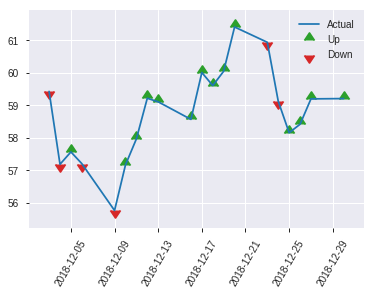


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.23278196392037254
RMSE: 0.48247483242172595
LogLoss: 0.6572931713918995
Null degrees of freedom: 235
Residual degrees of freedom: 225
Null deviance: 328.8185624091997
Residual deviance: 310.24237689697657
AIC: 332.24237689697657
AUC: 0.6541934551759012
pr_auc: 0.5701536668188825
Gini: 0.30838691035180243
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3793644205918727: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      41   86   0.6772   (86.0/127.0)
1      12   97   0.1101   (12.0/109.0)
Total  53   183  0.4153   (98.0/236.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.379364     0.664384  182
max f2                       0.253917     0.819423  222
max f0point5                 0.422198     0.609023  138
max accuracy                 0.426671     0.635593  136
max precision                0.621903     0.75      3
max recall                   0.111326     1         233
max specificity              0.670835     0.992126  0
max absolute_mcc             0.422198     0.290225  138
max min_per_class_accuracy   0.453864     0.614173  115
max mean_per_class_accuracy  0.422198     0.643213  138

Gains/Lift Table: Avg response rate: 46.19 %, avg score: 43.82 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0127119                   0.637935           1.44343   1.44343            0.666667         0.659436  0.666667                    0.659436            0.0183486       0.0183486                  44.3425    44.3425
    2        0.0211864                   0.604505           1.08257   1.29908            0.5              0.613794  0.6                         0.641179            0.00917431      0.0275229                  8.25688    29.9083
    3        0.0338983                   0.596642           0.721713  1.08257            0.333333         0.601057  0.5                         0.626133            0.00917431      0.0366972                  -27.8287   8.25688
    4        0.0423729                   0.589547           1.08257   1.08257            0.5              0.590676  0.5                         0.619042            0.00917431      0.0458716                  8.25688    8.25688
    5        0.0508475                   0.577512           1.08257   1.08257            0.5              0.587821  0.5                         0.613838            0.00917431      0.0550459                  8.25688    8.25688
    6        0.101695                    0.549823           1.263     1.17278            0.583333         0.562742  0.541667                    0.58829             0.0642202       0.119266                   26.2997    17.2783
    7        0.152542                    0.533512           1.80428   1.38328            0.833333         0.543896  0.638889                    0.573492            0.0917431       0.211009                   80.4281    38.3282
    8        0.20339                     0.526405           1.263     1.35321            0.583333         0.53012   0.625                       0.562649            0.0642202       0.275229                   26.2997    35.3211
    9        0.300847                    0.50295            1.12964   1.28079            0.521739         0.513583  0.591549                    0.546754            0.110092        0.385321                   12.9637    28.0786
    10       0.402542                    0.477806           1.263     1.27629            0.583333         0.488648  0.589474                    0.532075            0.12844         0.513761                   26.2997    27.6292
    11       0.5                         0.452678           1.12964   1.24771            0.521739         0.464898  0.576271                    0.518981            0.110092        0.623853                   12.9637    24.7706
    12       0.601695                    0.419856           1.17278   1.23504            0.541667         0.435814  0.570423                    0.504925            0.119266        0.743119                   17.2783    23.5043
    13       0.699153                    0.393261           0.470682  1.1285             0.217391         0.407958  0.521212                    0.491408            0.0458716       0.788991                   -52.9318   12.8496
    14       0.800847                    0.367828           0.992355  1.11121            0.458333         0.382206  0.513228                    0.477541            0.100917        0.889908                   -0.764526  11.1208
    15       0.898305                    0.31049            0.753091  1.07236            0.347826         0.337268  0.495283                    0.462323            0.0733945       0.963303                   -24.6909   7.23559
    16       1                           0.0417434          0.360856  1                  0.166667         0.22523   0.461864                    

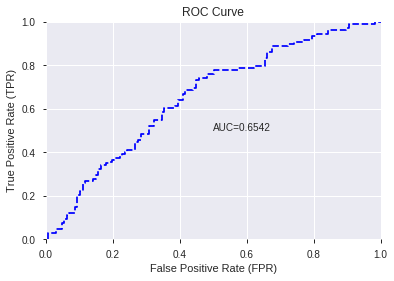

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


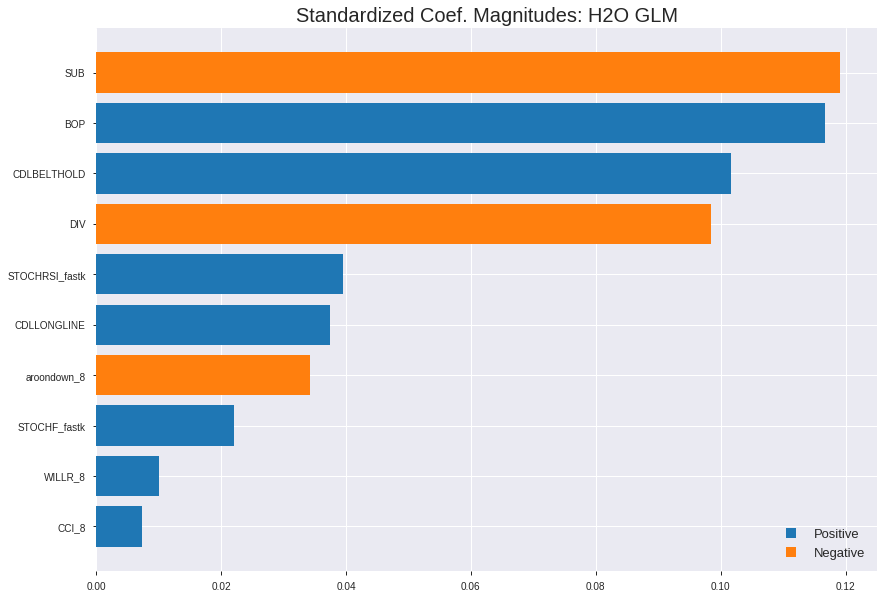

'log_likelihood'
--2019-08-24 00:38:15--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.184.139
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.184.139|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190824_003810_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190824_003810_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_82_sid_9850',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_82_s

['SUB',
 'BOP',
 'CDLBELTHOLD',
 'DIV',
 'STOCHRSI_fastk',
 'CDLLONGLINE',
 'aroondown_8',
 'STOCHF_fastk',
 'WILLR_8',
 'CCI_8']

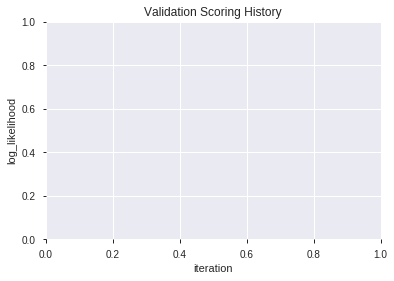

In [48]:
# GLM with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190824_003823_model_4  0.689265  0.635324              0.343676  0.471449  0.222264
1               XGBoost_2_AutoML_20190824_003823  0.686051  0.639359              0.350249  0.473396  0.224104
2               XGBoost_1_AutoML_20190824_003823  0.680308  0.641790              0.350899  0.474282  0.224943
3  XGBoost_grid_1_AutoML_20190824_003823_model_7  0.678755  0.647500              0.404789  0.476503  0.227055
4  XGBoost_grid_1_AutoML_20190824_003823_model_2  0.672976  0.642372              0.400202  0.475011  0.225636
5  XGBoost_grid_1_AutoML_20190824_003823_model_3  0.661634  0.656684              0.419923  0.482155  0.232474
6               XGBoost_3_AutoML_20190824_003823  0.659575  0.661700              0.404139  0.483836  0.234097
7  XGBoost_grid_1_AutoML_20190824_003823_model_6  0.651665  0.665283              0.421874  0.485735  0.235939
8  XGBoost_grid_1_AutoML_20190824_003823_model_1  0.644875  0.674214              0.369320  0.489198  0.239315
9  XGBoost_grid_1_AutoML_20190824_003823_model_5  0.642274  0.692624              0.402153  0.496074  0.246090

variable  relative_importance  scaled_importance  percentage
0             BOP           898.822021           1.000000    0.321824
1             DIV           623.481445           0.693665    0.223238
2             SUB           492.591583           0.548041    0.176373
3    STOCHF_fastk           174.039963           0.193631    0.062315
4         WILLR_8           166.361465           0.185088    0.059566
5           CCI_8           162.814407           0.181142    0.058296
6  STOCHRSI_fastk           110.677795           0.123136    0.039628
7     aroondown_8            91.158974           0.101420    0.032640
8     CDLBELTHOLD            72.949120           0.081161    0.026120

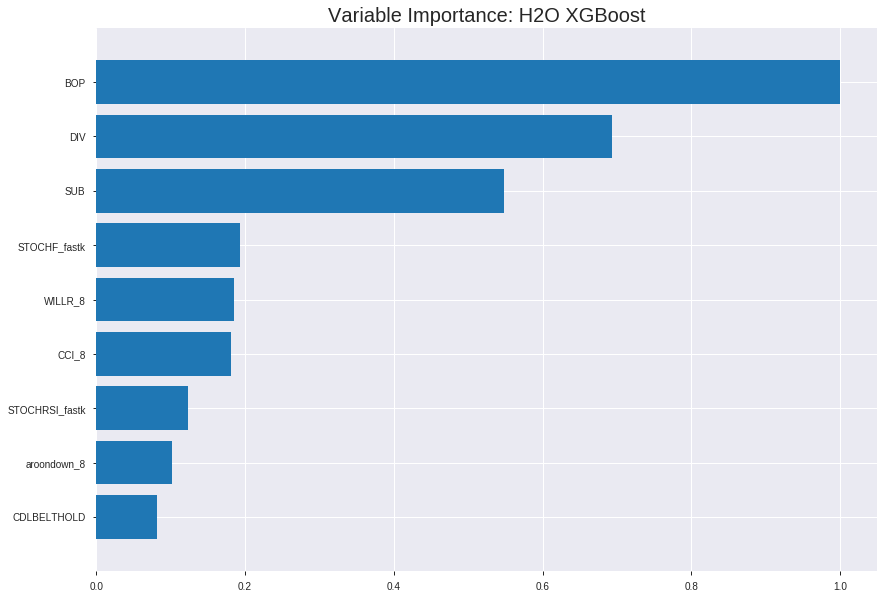

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190824_003823_model_4


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.20723660050885512
RMSE: 0.45523246864525724
LogLoss: 0.6020352128994191
Mean Per-Class Error: 0.32051372479868334
AUC: 0.7449083054135073
pr_auc: 0.7440316565878772
Gini: 0.48981661082701455
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.34848471482594806: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      258  537   0.6755   (537.0/795.0)
1      60   796   0.0701   (60.0/856.0)
Total  318  1333  0.3616   (597.0/1651.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.348485     0.727273  303
max f2                       0.263409     0.859898  352
max f0point5                 0.556454     0.692308  175
max accuracy                 0.552354     0.679588  178
max precision                0.809071     1         0
max recall                   0.167778     1         399
max specificity              0.809071     1         0
max absolute_mcc             0.552354     0.358791  178
max min_per_class_accuracy   0.553481     0.677987  177
max mean_per_class_accuracy  0.552354     0.679486  178

Gains/Lift Table: Avg response rate: 51.85 %, avg score: 51.69 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102968                   0.777236           1.81528   1.81528            0.941176         0.788799  0.941176                    0.788799            0.0186916       0.0186916                  81.5283   81.5283
    2        0.0205936                   0.761529           1.92874   1.87201            1                0.767028  0.970588                    0.777914            0.0198598       0.0385514                  92.8738   87.2011
    3        0.0302847                   0.749647           1.68765   1.81301            0.875            0.755229  0.94                        0.770655            0.0163551       0.0549065                  68.7646   81.3014
    4        0.0405815                   0.7429             1.47492   1.72723            0.764706         0.745802  0.895522                    0.764349            0.0151869       0.0700935                  47.4918   72.7228
    5        0.0502726                   0.733651           1.5671    1.69636            0.8125           0.738277  0.879518                    0.759323            0.0151869       0.0852804                  56.71     69.636
    6        0.100545                    0.700617           1.55693   1.62665            0.807229         0.716842  0.843373                    0.738082            0.078271        0.163551                   55.6933   62.6647
    7        0.150212                    0.673168           1.50536   1.58654            0.780488         0.68452   0.822581                    0.720372            0.0747664       0.238318                   50.5357   58.6543
    8        0.200485                    0.655479           1.34779   1.52668            0.698795         0.662772  0.791541                    0.705929            0.067757        0.306075                   34.7793   52.6675
    9        0.300424                    0.622623           1.39103   1.48155            0.721212         0.638103  0.768145                    0.683366            0.139019        0.445093                   39.1029   48.1551
    10       0.400363                    0.593552           1.18062   1.40643            0.612121         0.607705  0.729198                    0.664479            0.117991        0.563084                   18.0622   40.6432
    11       0.500303                    0.556148           1.0988    1.34498            0.569697         0.575049  0.697337                    0.646615            0.109813        0.672897                   9.87964   34.498
    12       0.600242                    0.506212           0.923457  1.2748             0.478788         0.530906  0.660949                    0.62735             0.0922897       0.765187                   -7.65435  27.4797
    13       0.700182                    0.444377           0.86501   1.21631            0.448485         0.47615   0.630623                    0.605768            0.0864486       0.851636                   -13.499   21.6306
    14       0.800121                    0.355744           0.701359  1.15199            0.363636         0.398437  0.597275                    0.579871            0.0700935       0.921729                   -29.8641  15.1987
    15       0.900061                    0.269231           0.619534  1.09287            0.321212         0.3126    0.566622                    0.550195            0.0619159       0.983645                   -38.0466  9.28652
    16       1                           0.167708           0.163651  1                  0.0848485        0.216791  0.518474                    0.516874           



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.23053284595278128
RMSE: 0.48013836125931586
LogLoss: 0.6530414494803397
Mean Per-Class Error: 0.37054301162184977
AUC: 0.6575955165166784
pr_auc: 0.6052003588178234
Gini: 0.3151910330333567
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.42325159907341003: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      101  140  0.5809   (140.0/241.0)
1      37   194  0.1602   (37.0/231.0)
Total  138  334  0.375    (177.0/472.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.423252     0.686726  270
max f2                       0.204504     0.833935  389
max f0point5                 0.423252     0.619017  270
max accuracy                 0.563934     0.625     144
max precision                0.721343     1         0
max recall                   0.204504     1         389
max specificity              0.721343     1         0
max absolute_mcc             0.423252     0.284549  270
max min_per_class_accuracy   0.524885     0.614719  184
max mean_per_class_accuracy  0.423252     0.629457  270

Gains/Lift Table: Avg response rate: 48.94 %, avg score: 48.62 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain         cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  -----------  -----------------
    1        0.0105932                   0.690658           1.63463   1.63463            0.8              0.709771  0.8                         0.709771            0.017316        0.017316                   63.4632      63.4632
    2        0.0211864                   0.672125           1.22597   1.4303             0.6              0.680844  0.7                         0.695307            0.012987        0.030303                   22.5974      43.0303
    3        0.0317797                   0.664751           0.817316  1.22597            0.4              0.668136  0.6                         0.68625             0.00865801      0.038961                   -18.2684     22.5974
    4        0.0402542                   0.658758           1.53247   1.2905             0.75             0.661477  0.631579                    0.681035            0.012987        0.0519481                  53.2468      29.0499
    5        0.0508475                   0.655007           0.817316  1.19192            0.4              0.657332  0.583333                    0.676097            0.00865801      0.0606061                  -18.2684     19.1919
    6        0.101695                    0.635066           1.27706   1.23449            0.625            0.644326  0.604167                    0.660211            0.0649351       0.125541                   27.7056      23.4488
    7        0.150424                    0.619258           1.42142   1.29504            0.695652         0.62572   0.633803                    0.649038            0.0692641       0.194805                   42.1419      29.5043
    8        0.201271                    0.604424           1.36219   1.31201            0.666667         0.612271  0.642105                    0.63975             0.0692641       0.264069                   36.2193      31.2007
    9        0.300847                    0.582405           1.30423   1.30943            0.638298         0.594177  0.640845                    0.624666            0.12987         0.393939                   30.4228      30.9432
    10       0.400424                    0.560705           1.26075   1.29733            0.617021         0.572127  0.634921                    0.611601            0.125541        0.519481                   26.0753      29.7327
    11       0.5                         0.522941           0.999908  1.2381             0.489362         0.540215  0.605932                    0.597384            0.0995671       0.619048                   -0.00921065  23.8095
    12       0.599576                    0.477638           1.04338   1.20576            0.510638         0.500598  0.590106                    0.58131             0.103896        0.722944                   4.33821      20.5758
    13       0.699153                    0.42497            1.04338   1.18263            0.510638         0.450837  0.578788                    0.562728            0.103896        0.82684                    4.33821      18.2632
    14       0.798729                    0.353833           0.695588  1.12191            0.340426         0.39073   0.549072                    0.541285            0.0692641       0.896104                   -30.4412     12.1913
    15       0.898305                    0.265954           0.434743  1.04574            0.212766         0.310149  0.511792                    0.515664            0.04329         0.939394                   -56.5257     4.57404
    16       1                           0.172521           0.59596   1                  0.291667         0.22


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-24 00:38:27  1.670 sec   0                  0.5              0.693147            0.5             0                  1                0.481526                         0.5                0.693147              0.5               0                    1                  0.510593
    2019-08-24 00:38:28  1.705 sec   5                  0.48717          0.667717            0.712009        0.680238           1.76102          0.364627                         0.492596           0.678393              0.638313          0.599554             1.70274            0.415254
    2019-08-24 00:38:28  1.732 sec   10                 0.478693         0.650972            0.720183        0.703909           1.70183          0.355542                         0.487685           0.668594              0.653904          0.60782              1.22597            0.396186
    2019-08-24 00:38:28  1.766 sec   15                 0.472198         0.637974            0.727143        0.721396           1.92874          0.342217                         0.485156           0.663458              0.656536          0.613916             1.63463            0.389831
    2019-08-24 00:38:28  1.798 sec   20                 0.467322         0.628073            0.731427        0.725314           1.92874          0.365839                         0.483086           0.659204              0.655153          0.609583             1.63463            0.398305
    2019-08-24 00:38:28  1.847 sec   25                 0.464227         0.62159             0.733755        0.730451           1.82159          0.363416                         0.481562           0.656058              0.658287          0.611867             2.04329            0.379237
    2019-08-24 00:38:28  1.891 sec   30                 0.461659         0.616085            0.734565        0.731363           1.81528          0.347668                         0.480434           0.653776              0.662616          0.616192             1.63463            0.387712
    2019-08-24 00:38:28  1.930 sec   35                 0.459546         0.611453            0.736761        0.733136           1.81528          0.352514                         0.479828           0.652495              0.663415          0.618142             1.63463            0.394068
    2019-08-24 00:38:28  1.971 sec   40                 0.458133         0.608312            0.737967        0.733279           1.81528          0.351302                         0.479309           0.651342              0.660793          0.61238              1.63463            0.370763
    2019-08-24 00:38:28  2.020 sec   45                 0.456541         0.604847            0.741339        0.737583           1.81528          0.367656                         0.479536           0.651809              0.6595            0.610281             2.04329            0.389831
    2019-08-24 00:38:28  2.070 sec   50                 0.455232         0.602035            0.744908        0.744032           1.81528          0.361599                         0.480138           0.653041              0.657596          0.6052               1.63463            0.375

Variable Importances: 


variable        relative_importance    scaled_importance    percentage
--------------  ---------------------  -------------------  ------------
BOP             898.822                1                    0.321824
DIV             623.481                0.693665             0.223238
SUB             492.592                0.548041             0.176373
STOCHF_fastk    174.04                 0.193631             0.0623152
WILLR_8         166.361                0.185088             0.0595659
CCI_8           162.814                0.181142             0.0582959
STOCHRSI_fastk  110.678                0.123136             0.0396283
aroondown_8     91.159                 0.10142              0.0326396
CDLBELTHOLD     72.9491                0.0811608            0.0261195

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6567796610169492)

('F1', 0.6666666666666667)

('auc', 0.6892653326591057)

('logloss', 0.635324125639189)

('mean_per_class_error', 0.3410387921693274)

('rmse', 0.4714491238230408)

('mse', 0.22226427635351287)

xgboost prediction progress: |████████████████████████████████████████████| 100%


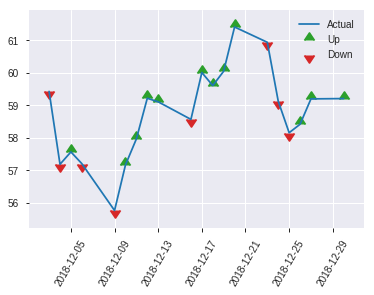


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.22226427635351287
RMSE: 0.4714491238230408
LogLoss: 0.635324125639189
Mean Per-Class Error: 0.3410387921693274
AUC: 0.6892653326591057
pr_auc: 0.6565863511150666
Gini: 0.37853066531821145
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4669298827648163: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      70   57   0.4488   (57.0/127.0)
1      26   83   0.2385   (26.0/109.0)
Total  96   140  0.3517   (83.0/236.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.46693      0.666667  139
max f2                       0.208963     0.818318  228
max f0point5                 0.588644     0.630631  55
max accuracy                 0.588644     0.65678   55
max precision                0.713889     1         0
max recall                   0.208963     1         228
max specificity              0.713889     1         0
max absolute_mcc             0.588644     0.322368  55
max min_per_class_accuracy   0.529555     0.633028  114
max mean_per_class_accuracy  0.4951       0.658961  134

Gains/Lift Table: Avg response rate: 46.19 %, avg score: 47.24 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0127119                   0.684292           2.16514   2.16514            1                0.698783  1                           0.698783            0.0275229       0.0275229                  116.514   116.514
    2        0.0211864                   0.668697           2.16514   2.16514            1                0.674536  1                           0.689085            0.0183486       0.0458716                  116.514   116.514
    3        0.0338983                   0.662754           2.16514   2.16514            1                0.665457  1                           0.680224            0.0275229       0.0733945                  116.514   116.514
    4        0.0423729                   0.660088           1.08257   1.94862            0.5              0.662603  0.9                         0.6767              0.00917431      0.0825688                  8.25688   94.8624
    5        0.0508475                   0.654365           1.08257   1.80428            0.5              0.655397  0.833333                    0.673149            0.00917431      0.0917431                  8.25688   80.4281
    6        0.101695                    0.631183           1.44343   1.62385            0.666667         0.643921  0.75                        0.658535            0.0733945       0.165138                   44.3425   62.3853
    7        0.152542                    0.609967           1.44343   1.56371            0.666667         0.620681  0.722222                    0.645917            0.0733945       0.238532                   44.3425   56.371
    8        0.20339                     0.598224           1.62385   1.57875            0.75             0.604674  0.729167                    0.635606            0.0825688       0.321101                   62.3853   57.8746
    9        0.300847                    0.574857           1.12964   1.43326            0.521739         0.586113  0.661972                    0.619573            0.110092        0.431193                   12.9637   43.326
    10       0.402542                    0.551968           0.902141  1.29908            0.416667         0.563389  0.6                         0.605379            0.0917431       0.522936                   -9.78593  29.9083
    11       0.5                         0.527016           1.22377   1.2844             0.565217         0.539447  0.59322                     0.592528            0.119266        0.642202                   22.3773   28.4404
    12       0.601695                    0.454718           1.17278   1.26554            0.541667         0.498736  0.584507                    0.576676            0.119266        0.761468                   17.2783   26.5538
    13       0.699153                    0.387349           0.470682  1.15474            0.217391         0.412581  0.533333                    0.553802            0.0458716       0.807339                   -52.9318  15.474
    14       0.800847                    0.308589           0.811927  1.11121            0.375            0.349223  0.513228                    0.527824            0.0825688       0.889908                   -18.8073  11.1208
    15       0.898305                    0.252577           0.658955  1.06214            0.304348         0.27738   0.490566                    0.500653            0.0642202       0.954128                   -34.1045  6.2143
    16       1                           0.16832            0.45107   1                  0.208333         0.2229    0.461864                    0.472407            0

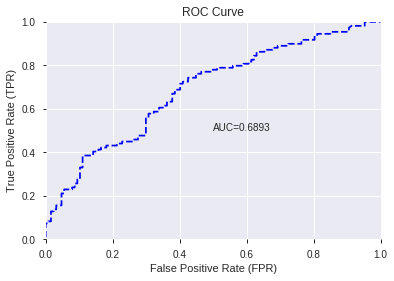

This function is available for GLM models only


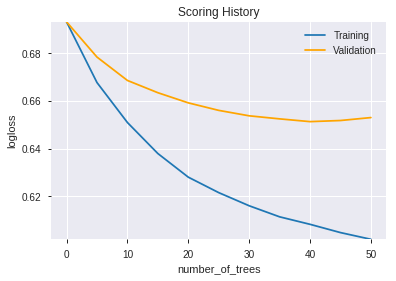

--2019-08-24 00:38:37--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.115.59
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.115.59|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190824_003823_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190824_003823_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_90_sid_9850',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'DIV',
 'SUB',
 'STOCHF_fastk',
 'WILLR_8',
 'CCI_8',
 'STOCHRSI_fastk',
 'aroondown_8',
 'CDLBELTHOLD']

In [49]:
# XGBoost with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="XGBoost",features_list=features_list)

In [50]:
# recursive feature elimination with cross validation
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'RFE' in features_to_include:
  from sklearn.feature_selection import RFECV
  from sklearn.svm import LinearSVC
  from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
  from sklearn.linear_model import LogisticRegression, LinearRegression

  bestfeatures = RFECV(ExtraTreeClassifier(random_state=1,criterion='entropy'), min_features_to_select=select_rfe, step=1,cv=5).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, RFECV, LinearSVC, DecisionTreeClassifier,ExtraTreeClassifier, LogisticRegression, LinearRegression
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list = []

199

['MAVP_14_4',
 'BBANDS_upperband_14_4_2',
 'BBANDS_middleband_14_4_2',
 'BBANDS_lowerband_14_4_2',
 'BBANDS_upperband_14_4_3',
 'BBANDS_middleband_14_4_3',
 'BBANDS_upperband_14_4_4',
 'BBANDS_middleband_14_4_4',
 'BBANDS_lowerband_14_4_4',
 'BBANDS_middleband_14_4_5',
 'MAVP_14_5',
 'BBANDS_upperband_14_5_2',
 'BBANDS_middleband_14_5_2',
 'BBANDS_upperband_14_5_3',
 'BBANDS_lowerband_14_5_4',
 'BBANDS_upperband_14_5_5',
 'BBANDS_lowerband_14_5_5',
 'BBANDS_upperband_14_6_2',
 'BBANDS_middleband_14_6_2',
 'BBANDS_lowerband_14_7_3',
 'BBANDS_upperband_14_7_5',
 'DEMA_20',
 'KAMA_20',
 'BBANDS_lowerband_20_0_2',
 'BBANDS_lowerband_20_0_4',
 'BBANDS_middleband_20_0_5',
 'BBANDS_lowerband_20_1_2',
 'BBANDS_upperband_20_1_4',
 'BBANDS_middleband_20_1_4',
 'BBANDS_lowerband_20_1_4',
 'BBANDS_upperband_20_1_5',
 'BBANDS_lowerband_20_1_5',
 'BBANDS_upperband_20_2_3',
 'BBANDS_lowerband_20_2_3',
 'BBANDS_upperband_20_2_4',
 'BBANDS_upperband_20_2_5',
 'BBANDS_middleband_20_2_5',
 'BBANDS_lowerb

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190824_003954_model_8  0.672614  0.653196              0.363433  0.480943  0.231306
1  DeepLearning_grid_1_AutoML_20190824_003954_model_9  0.661201  0.674071              0.367370  0.490427  0.240519
2  DeepLearning_grid_1_AutoML_20190824_003954_model_6  0.647764  0.654479              0.385104  0.481675  0.232011
3  DeepLearning_grid_1_AutoML_20190824_003954_model_5  0.634545  0.681518              0.362783  0.494264  0.244297
4  DeepLearning_grid_1_AutoML_20190824_003954_model_3  0.594524  0.847453              0.424511  0.535999  0.287295
5  DeepLearning_grid_1_AutoML_20190824_003954_model_2  0.548003  0.955982              0.484252  0.562792  0.316735
6  DeepLearning_grid_1_AutoML_20190824_003954_model_1  0.547063  3.002245              0.480965  0.704569  0.496417
7               DeepLearning_1_AutoML_20190824_003954  0.539695  1.031855              0.484902  0.571799  0.326954
8  DeepLearning_grid_1_AutoML_20190824_003954_model_7  0.535216  0.889294              0.476378  0.565840  0.320175
9  DeepLearning_grid_1_AutoML_20190824_003954_model_4  0.526331  0.906093              0.465867  0.564643  0.318822

variable  relative_importance  scaled_importance  percentage
0                      TRANGE             1.000000           1.000000    0.023989
1                 CDLBELTHOLD             0.577766           0.577766    0.013860
2                         BOP             0.556060           0.556060    0.013340
3                   aroonup_8             0.401286           0.401286    0.009627
4           CDLINVERTEDHAMMER             0.398045           0.398045    0.009549
..                        ...                  ...                ...         ...
194   BBANDS_upperband_14_5_2             0.141133           0.141133    0.003386
195  BBANDS_middleband_14_4_2             0.139688           0.139688    0.003351
196  BBANDS_middleband_14_4_4             0.139071           0.139071    0.003336
197   BBANDS_upperband_20_2_3             0.138660           0.138660    0.003326
198  BBANDS_middleband_30_0_4             0.138478           0.138478    0.003322

[199 rows x 4 columns]

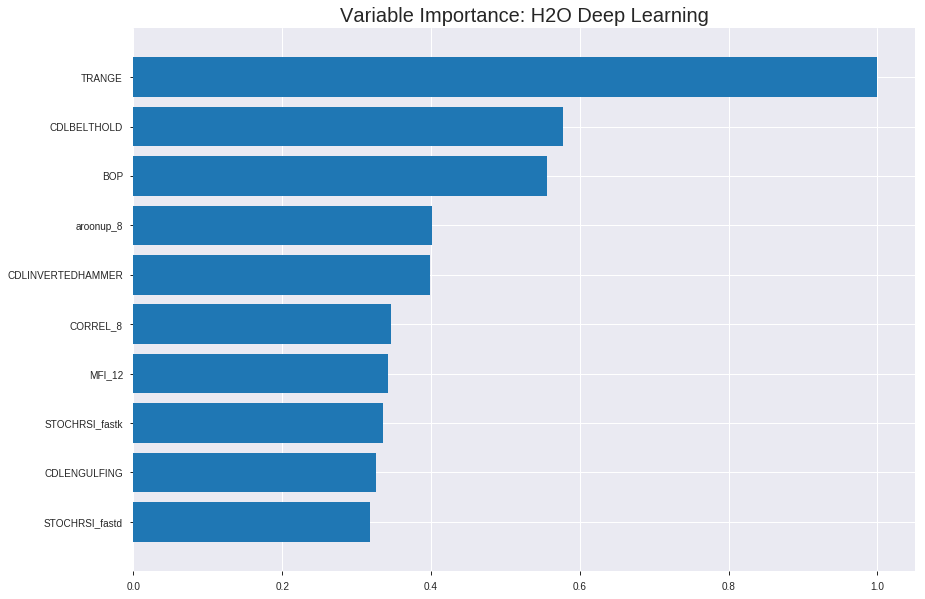

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190824_003954_model_8


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.19489949276412613
RMSE: 0.4414742266136565
LogLoss: 0.5607226591287423
Mean Per-Class Error: 0.31496870040557223
AUC: 0.7607101922059601
pr_auc: 0.773651451388623
Gini: 0.5214203844119203
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.45776295986544524: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      335  460   0.5786   (460.0/795.0)
1      53   803   0.0619   (53.0/856.0)
Total  388  1263  0.3107   (513.0/1651.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.457763     0.757905  225
max f2                       0.367452     0.868849  279
max f0point5                 0.514491     0.686728  179
max accuracy                 0.480926     0.692913  207
max precision                0.999881     1         0
max recall                   0.0867435    1         362
max specificity              0.999881     1         0
max absolute_mcc             0.457763     0.423607  225
max min_per_class_accuracy   0.537075     0.6       158
max mean_per_class_accuracy  0.480926     0.685031  207

Gains/Lift Table: Avg response rate: 51.85 %, avg score: 51.44 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102968                   0.997518           1.92874    1.92874            1                0.999254  1                           0.999254            0.0198598       0.0198598                  92.8738   92.8738
    2        0.0205936                   0.99281            1.92874    1.92874            1                0.994648  1                           0.996951            0.0198598       0.0397196                  92.8738   92.8738
    3        0.0302847                   0.98536            1.92874    1.92874            1                0.988923  1                           0.994382            0.0186916       0.0584112                  92.8738   92.8738
    4        0.0405815                   0.960191           1.92874    1.92874            1                0.975245  1                           0.989526            0.0198598       0.078271                   92.8738   92.8738
    5        0.0502726                   0.932586           1.92874    1.92874            1                0.945824  1                           0.981102            0.0186916       0.0969626                  92.8738   92.8738
    6        0.100545                    0.735332           1.85902    1.89388            0.963855         0.842039  0.981928                    0.911571            0.0934579       0.190421                   85.9025   89.3882
    7        0.150212                    0.593799           1.43479    1.74209            0.743902         0.64327   0.903226                    0.822858            0.0712617       0.261682                   43.4793   74.2086
    8        0.200485                    0.551627           1.27808    1.62573            0.662651         0.568452  0.8429                      0.759065            0.0642523       0.325935                   27.808    62.5734
    9        0.569352                    0.537078           1.10214    1.28651            0.571429         0.538133  0.667021                    0.615929            0.406542        0.732477                   10.2136   28.6509
    10       0.600242                    0.53158            1.28583    1.28647            0.666667         0.534345  0.667003                    0.611731            0.0397196       0.772196                   28.5826   28.6474
    11       0.700182                    0.489841           1.05204    1.25301            0.545455         0.514164  0.649654                    0.597805            0.10514         0.877336                   5.20391   25.3013
    12       0.800121                    0.433465           0.759806   1.19141            0.393939         0.463932  0.617714                    0.581083            0.0759346       0.953271                   -24.0194  19.1408
    13       0.900061                    0.295764           0.397437   1.10325            0.206061         0.38187   0.572005                    0.558963            0.0397196       0.992991                   -60.2563  10.3249
    14       1                           4.08106e-07        0.0701359  1                  0.0363636        0.113503  0.518474                    0.514444            0.00700935      1                          -92.9864  0



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.2422595767153045
RMSE: 0.4921987166940853
LogLoss: 0.677280146629691
Mean Per-Class Error: 0.38116793303515295
AUC: 0.6235562501122668
pr_auc: 0.5877237796497493
Gini: 0.24711250022453357
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.34623213763259786: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      45   196  0.8133   (196.0/241.0)
1      17   214  0.0736   (17.0/231.0)
Total  62   410  0.4513   (213.0/472.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.346232     0.667707  339
max f2                       0.253532     0.828551  397
max f0point5                 0.441372     0.610783  188
max accuracy                 0.441372     0.618644  188
max precision                0.797244     1         0
max recall                   0.253532     1         397
max specificity              0.797244     1         0
max absolute_mcc             0.441372     0.23763   188
max min_per_class_accuracy   0.442703     0.61039   183
max mean_per_class_accuracy  0.441372     0.618832  188

Gains/Lift Table: Avg response rate: 48.94 %, avg score: 43.81 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105932                   0.610945           1.22597   1.22597            0.6              0.680022  0.6                         0.680022            0.012987        0.012987                   22.5974   22.5974
    2        0.0211864                   0.569226           1.22597   1.22597            0.6              0.583349  0.6                         0.631686            0.012987        0.025974                   22.5974   22.5974
    3        0.0317797                   0.550024           1.63463   1.36219            0.8              0.556743  0.666667                    0.606705            0.017316        0.04329                    63.4632   36.2193
    4        0.0402542                   0.542679           1.53247   1.39804            0.75             0.546485  0.684211                    0.594027            0.012987        0.0562771                  53.2468   39.8041
    5        0.0508475                   0.5382             1.63463   1.44733            0.8              0.54073   0.708333                    0.582923            0.017316        0.0735931                  63.4632   44.733
    6        0.105932                    0.537078           1.336     1.38944            0.653846         0.537102  0.68                        0.559096            0.0735931       0.147186                   33.5997   38.9437
    7        0.150424                    0.520866           1.45949   1.41016            0.714286         0.527469  0.690141                    0.549742            0.0649351       0.212121                   45.9493   41.0158
    8        0.201271                    0.50839            0.766234  1.24748            0.375            0.513765  0.610526                    0.540653            0.038961        0.251082                   -23.3766  24.7482
    9        0.300847                    0.485405           1.04338   1.17993            0.510638         0.496942  0.577465                    0.526185            0.103896        0.354978                   4.33821   17.9928
    10       0.400424                    0.460768           1.21728   1.18922            0.595745         0.473067  0.582011                    0.512976            0.121212        0.47619                    21.7279   18.9216
    11       0.5                         0.44225            1.39118   1.22944            0.680851         0.451632  0.601695                    0.500759            0.138528        0.614719                   39.1176   22.9437
    12       0.599576                    0.423986           0.956434  1.1841             0.468085         0.433528  0.579505                    0.489594            0.0952381       0.709957                   -4.35664  18.4097
    13       0.699153                    0.405185           0.739062  1.12071            0.361702         0.414247  0.548485                    0.478862            0.0735931       0.78355                    -26.0938  12.0714
    14       0.798729                    0.369204           0.739062  1.07313            0.361702         0.387623  0.525199                    0.467488            0.0735931       0.857143                   -26.0938  7.31338
    15       0.898305                    0.330389           0.826011  1.04574            0.404255         0.352018  0.511792                    0.454688            0.0822511       0.939394                   -17.3989  4.57404
    16       1                           0.235818           0.59596   1                  0.291667         0.29161   0.489407                    0.438104          


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-24 00:48:49  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-24 00:48:51  2 min 13.071 sec  537 obs/sec       0.69473   1             1147       0.516832         0.731312            -0.069923      0.517551        0.534237           1.36146          0.476075                         0.524283           0.75107               -0.0999832       0.536518          0.515003             1.63463            0.506356
    2019-08-24 00:49:07  2 min 29.740 sec  768 obs/sec       8.00545   11            13217      0.489991         0.672951            0.0383234      0.635427        0.640915           1.58837          0.436705                         0.499326           0.691751              0.00224813       0.600438          0.577715             2.04329            0.489407
    2019-08-24 00:49:24  2 min 46.683 sec  811 obs/sec       15.9836   22            26389      0.476175         0.64518             0.0917881      0.68125         0.68718            1.81528          0.371896                         0.500799           0.698081              -0.00364986      0.629978          0.584438             0.817316           0.425847
    2019-08-24 00:49:41  3 min  3.790 sec  874 obs/sec       25.4179   35            41965      0.468235         0.625291            0.121826       0.710313        0.723441           1.92874          0.349485                         0.495722           0.684523              0.0165965        0.600941          0.564956             1.22597            0.478814
    2019-08-24 00:49:58  3 min 20.061 sec  919 obs/sec       34.8807   48            57588      0.467064         0.621042            0.126214       0.72583         0.743412           1.92874          0.337371                         0.495975           0.685104              0.0155945        0.608396          0.608699             1.24591            0.46822
    2019-08-24 00:50:15  3 min 37.202 sec  953 obs/sec       45.106    62            74470      0.453123         0.588271            0.177595       0.729562        0.724214           1.92874          0.337977                         0.49731            0.68853               0.0102885        0.602279          0.569867             1.22597            0.485169
    2019-08-24 00:50:32  3 min 54.281 sec  987 obs/sec       56.0103   77            92473      0.441474         0.560723            0.219336       0.76071         0.773651           1.92874          0.310721                         0.492199           0.67728               0.0305265        0.623556          0.587724             1.22597            0.451271

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ---------------------
TRANGE                    1.0                    1.0                  0.02398942899266928
CDLBELTHOLD               0.5777655839920044     0.5777655839920044   0.013860266451584289
BOP                       0.5560598373413086     0.5560598373413086   0.013339557983574554
aroonup_8                 0.4012858271598816     0.4012858271598816   0.009626617856416537
CDLINVERTEDHAMMER         0.3980448544025421     0.3980448544025421   0.009548868770587167
---                       ---                    ---                  ---
BBANDS_upperband_14_5_2   0.1411331593990326     0.1411331593990326   0.0033857039059141674
BBANDS_middleband_14_4_2  0.139687642455101      0.139687642455101    0.0033510267798300204
BBANDS_middleband_14_4_4  0.13907064497470856    0.13907064497470856  0.00333622536258549
BBANDS_upperband_20_2_3   0.13865967094898224    0.13865967094898224  0.003326366330377497
BBANDS_middleband_30_0_4  0.13847841322422028    0.13847841322422028  0.003322018061059947


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6440677966101694)

('F1', 0.6785714285714285)

('auc', 0.6726143177056996)

('logloss', 0.6531962357215206)

('mean_per_class_error', 0.350213104095933)

('rmse', 0.48094268252138866)

('mse', 0.23130586387086924)

deeplearning prediction progress: |███████████████████████████████████████| 100%


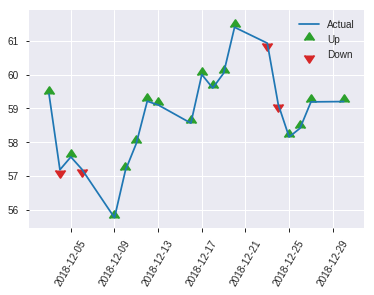


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.23130586387086924
RMSE: 0.48094268252138866
LogLoss: 0.6531962357215206
Mean Per-Class Error: 0.350213104095933
AUC: 0.6726143177056996
pr_auc: 0.5985902759509675
Gini: 0.34522863541139914
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.35355108671377866: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      51   76   0.5984   (76.0/127.0)
1      14   95   0.1284   (14.0/109.0)
Total  65   171  0.3814   (90.0/236.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.353551     0.678571  160
max f2                       0.264292     0.825688  207
max f0point5                 0.406965     0.616225  122
max accuracy                 0.406965     0.644068  122
max precision                0.539654     1         0
max recall                   0.214431     1         221
max specificity              0.539654     1         0
max absolute_mcc             0.353551     0.304815  160
max min_per_class_accuracy   0.432765     0.623853  104
max mean_per_class_accuracy  0.406965     0.649787  122

Gains/Lift Table: Avg response rate: 46.19 %, avg score: 41.12 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0508475                   0.537078           1.44343   1.44343            0.666667         0.537292  0.666667                    0.537292            0.0733945       0.0733945                  44.3425   44.3425
    2        0.0508475                   0.536551           0         1.44343            0                0         0.666667                    0.537292            0               0.0733945                  -100      44.3425
    3        0.101695                    0.522596           1.263     1.35321            0.583333         0.529694  0.625                       0.533493            0.0642202       0.137615                   26.2997   35.3211
    4        0.152542                    0.503312           1.263     1.32314            0.583333         0.515019  0.611111                    0.527335            0.0642202       0.201835                   26.2997   32.314
    5        0.20339                     0.490112           1.263     1.3081             0.583333         0.497076  0.604167                    0.51977             0.0642202       0.266055                   26.2997   30.8104
    6        0.300847                    0.47049            1.22377   1.28079            0.565217         0.480568  0.591549                    0.507071            0.119266        0.385321                   22.3773   28.0786
    7        0.402542                    0.45214            1.35321   1.29908            0.625            0.460984  0.6                         0.495428            0.137615        0.522936                   35.3211   29.9083
    8        0.5                         0.431775           1.22377   1.2844             0.565217         0.44231   0.59322                     0.485074            0.119266        0.642202                   22.3773   28.4404
    9        0.601695                    0.4014             1.08257   1.25029            0.5              0.415369  0.577465                    0.473293            0.110092        0.752294                   8.25688   25.0291
    10       0.699153                    0.363368           0.753091  1.18098            0.347826         0.380818  0.545455                    0.460403            0.0733945       0.825688                   -24.6909  18.0984
    11       0.800847                    0.32958            0.902141  1.14558            0.416667         0.344694  0.529101                    0.44571             0.0917431       0.917431                   -9.78593  14.5575
    12       0.898305                    0.277548           0.564819  1.08257            0.26087          0.305141  0.5                         0.430459            0.0550459       0.972477                   -43.5181  8.25688
    13       1                           0.17465            0.270642  1                  0.125            0.241208  0.461864                    0.411213            0.0275229       1                          -72.9358  0

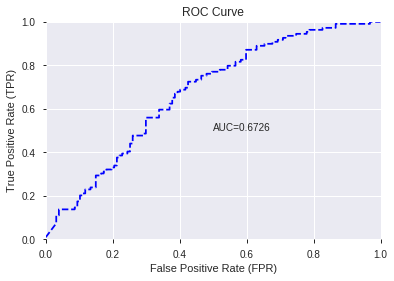

This function is available for GLM models only


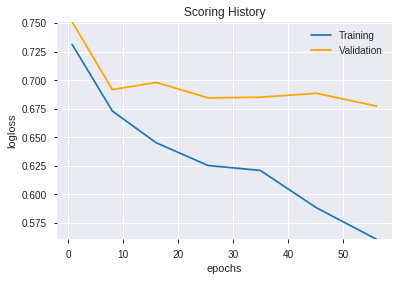

--2019-08-24 00:53:18--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.163.139
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.163.139|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190824_003954_model_8',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190824_003954_model_8',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_98_sid_9850',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['TRANGE',
 'CDLBELTHOLD',
 'BOP',
 'aroonup_8',
 'CDLINVERTEDHAMMER',
 'CORREL_8',
 'MFI_12',
 'STOCHRSI_fastk',
 'CDLENGULFING',
 'STOCHRSI_fastd',
 'STOCHF_fastk',
 'CORREL_20',
 'BETA_8',
 'aroonup_20',
 'CDLLONGLINE',
 'MFI_30',
 'HT_PHASOR_inphase',
 'CDLRICKSHAWMAN',
 'aroonup_24',
 'CDLDOJI',
 'aroonup_14',
 'aroondown_14',
 'BETA_14',
 'aroondown_12',
 'aroonup_12',
 'STOCH_slowd',
 'DX_8',
 'STOCH_slowk',
 'ADOSC',
 'aroondown_24',
 'CDLSHORTLINE',
 'STOCHF_fastd',
 'CDLSPINNINGTOP',
 'aroondown_20',
 'BETA_24',
 'WILLR_8',
 'MOM_12',
 'NATR_8',
 'MFI_8',
 'MFI_20',
 'aroondown_30',
 'ROCP_12',
 'CORREL_24',
 'CORREL_14',
 'ADX_24',
 'AROONOSC_24',
 'MACDEXT_hist',
 'MINUS_DI_8',
 'ADX_20',
 'LINEARREG_SLOPE_14',
 'CORREL_12',
 'CCI_20',
 'CCI_8',
 'DX_12',
 'AROONOSC_20',
 'CCI_30',
 'WILLR_14',
 'ADXR_12',
 'BETA_20',
 'WILLR_12',
 'ROC_8',
 'MACDEXT_signal',
 'DX_30',
 'MACDFIX_signal_24',
 'PLUS_DI_8',
 'ROC_14',
 'ROCP_14',
 'WILLR_30',
 'VAR_8',
 'CMO_8',
 'DX_24',
 'MA

In [51]:
# DeepLearning with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190824_005326_model_1  0.649353  0.661388              0.381167  0.484774  0.235005

variable  relative_importance  scaled_importance  percentage
0                        BOP             0.153066           1.000000    0.052716
1                CDLBELTHOLD             0.122492           0.800253    0.042186
2          CDLINVERTEDHAMMER             0.100690           0.657818    0.034678
3                  aroonup_8             0.072536           0.473885    0.024981
4                     TRANGE             0.070280           0.459145    0.024204
..                       ...                  ...                ...         ...
194                  ADXR_12             0.000483           0.003153    0.000166
195  BBANDS_upperband_20_6_4             0.000245           0.001598    0.000084
196  BBANDS_upperband_20_6_5             0.000163           0.001066    0.000056
197  BBANDS_upperband_24_7_5             0.000124           0.000811    0.000043
198   LINEARREG_INTERCEPT_14             0.000069           0.000449    0.000024

[199 rows x 4 columns]

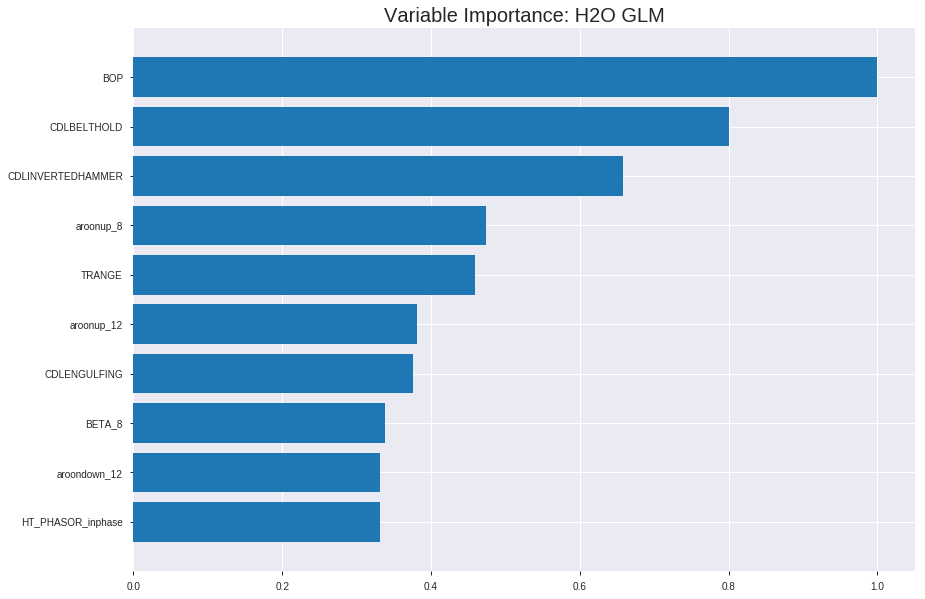

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190824_005326_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.2272555483003282
RMSE: 0.4767132768240551
LogLoss: 0.6458603795612566
Null degrees of freedom: 1650
Residual degrees of freedom: 1451
Null deviance: 2286.517691569208
Residual deviance: 2132.6309733112694
AIC: 2532.6309733112694
AUC: 0.6741021571739259
pr_auc: 0.6742077184697298
Gini: 0.3482043143478517
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.40923004532391294: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      217  578   0.727    (578.0/795.0)
1      64   792   0.0748   (64.0/856.0)
Total  281  1370  0.3889   (642.0/1651.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.40923      0.71159   299
max f2                       0.279759     0.844387  385
max f0point5                 0.466038     0.645756  250
max accuracy                 0.466038     0.638401  250
max precision                0.868374     1         0
max recall                   0.221431     1         396
max specificity              0.868374     1         0
max absolute_mcc             0.466038     0.284456  250
max min_per_class_accuracy   0.526466     0.61761   192
max mean_per_class_accuracy  0.466038     0.63152   250

Gains/Lift Table: Avg response rate: 51.85 %, avg score: 51.85 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102968                   0.765756           1.92874   1.92874            1                0.799439  1                           0.799439            0.0198598       0.0198598                  92.8738   92.8738
    2        0.0205936                   0.739484           1.58837   1.75856            0.823529         0.749993  0.911765                    0.774716            0.0163551       0.036215                   58.8373   75.8556
    3        0.0302847                   0.718599           1.44655   1.65871            0.75             0.729379  0.86                        0.760208            0.0140187       0.0502336                  44.6554   65.8715
    4        0.0405815                   0.70077            1.70183   1.66965            0.882353         0.708427  0.865672                    0.747069            0.0175234       0.067757                   70.1828   66.9654
    5        0.0502726                   0.68812            1.44655   1.62665            0.75             0.694298  0.843373                    0.736897            0.0140187       0.0817757                  44.6554   62.6647
    6        0.100545                    0.652771           1.25484   1.44074            0.650602         0.670511  0.746988                    0.703704            0.0630841       0.14486                    25.4842   44.0744
    7        0.150212                    0.629674           1.24662   1.37656            0.646341         0.639936  0.71371                     0.682619            0.0619159       0.206776                   24.6624   37.6559
    8        0.200485                    0.609885           1.27808   1.35186            0.662651         0.620463  0.700906                    0.667033            0.0642523       0.271028                   27.808    35.1865
    9        0.300424                    0.57809            1.19231   1.29879            0.618182         0.591647  0.673387                    0.641955            0.119159        0.390187                   19.2311   29.8787
    10       0.400363                    0.552531           1.14555   1.26054            0.593939         0.565268  0.653555                    0.622812            0.114486        0.504673                   14.5554   26.0537
    11       0.500303                    0.52749            1.11049   1.23056            0.575758         0.5401    0.638015                    0.60629             0.110981        0.615654                   11.0486   23.0563
    12       0.600242                    0.500689           1.08711   1.20668            0.563636         0.514206  0.625631                    0.590958            0.108645        0.724299                   8.71071   20.6678
    13       0.700182                    0.462752           1.00528   1.17793            0.521212         0.481528  0.610727                    0.575339            0.100467        0.824766                   0.528179  17.7932
    14       0.800121                    0.424618           0.759806  1.12571            0.393939         0.44419   0.583649                    0.558957            0.0759346       0.900701                   -24.0194  12.5706
    15       0.900061                    0.366993           0.572777  1.06431            0.29697          0.395813  0.551817                    0.540842            0.057243        0.957944                   -42.7223  6.43105
    16       1                           0.0665159          0.420816  1                  0.218182         0.317019  0.518474                    0.518474         



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.24158402823574102
RMSE: 0.49151198178248007
LogLoss: 0.676218325771786
Null degrees of freedom: 471
Residual degrees of freedom: 272
Null deviance: 655.7149900197271
Residual deviance: 638.3500995285659
AIC: 1038.3500995285658
AUC: 0.6209606437822206
pr_auc: 0.5850014450205828
Gini: 0.2419212875644412
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.26670905721364807: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      22   219  0.9087   (219.0/241.0)
1      4    227  0.0173   (4.0/231.0)
Total  26   446  0.4725   (223.0/472.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.266709     0.670606  376
max f2                       0.266709     0.828467  376
max f0point5                 0.451715     0.594499  185
max accuracy                 0.471058     0.605932  156
max precision                0.665058     0.857143  6
max recall                   0.194263     1         399
max specificity              0.709369     0.995851  0
max absolute_mcc             0.471058     0.21235   156
max min_per_class_accuracy   0.445145     0.60166   194
max mean_per_class_accuracy  0.469414     0.603869  159

Gains/Lift Table: Avg response rate: 48.94 %, avg score: 44.17 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105932                   0.674586           1.63463   1.63463            0.8              0.696438  0.8                         0.696438            0.017316        0.017316                   63.4632   63.4632
    2        0.0211864                   0.648777           1.22597   1.4303             0.6              0.660628  0.7                         0.678533            0.012987        0.030303                   22.5974   43.0303
    3        0.0317797                   0.638341           0.817316  1.22597            0.4              0.643345  0.6                         0.666804            0.00865801      0.038961                   -18.2684  22.5974
    4        0.0402542                   0.610755           1.02165   1.18296            0.5              0.618985  0.578947                    0.656736            0.00865801      0.047619                   2.1645    18.2957
    5        0.0508475                   0.599003           1.22597   1.19192            0.6              0.606246  0.583333                    0.646218            0.012987        0.0606061                  22.5974   19.1919
    6        0.101695                    0.570678           1.36219   1.27706            0.666667         0.582865  0.625                       0.614541            0.0692641       0.12987                    36.2193   27.7056
    7        0.150424                    0.551029           1.24374   1.26626            0.608696         0.560616  0.619718                    0.597073            0.0606061       0.190476                   24.3742   26.6264
    8        0.201271                    0.531495           1.27706   1.26899            0.625            0.540497  0.621053                    0.58278             0.0649351       0.255411                   27.7056   26.8991
    9        0.300847                    0.499991           1.3477    1.29504            0.659574         0.516201  0.633803                    0.560743            0.134199        0.38961                    34.7702   29.5043
    10       0.400424                    0.469347           1.1738    1.26489            0.574468         0.484599  0.619048                    0.541808            0.116883        0.506494                   17.3805   26.4894
    11       0.5                         0.443092           0.956434  1.20346            0.468085         0.457842  0.588983                    0.525086            0.0952381       0.601732                   -4.35664  20.3463
    12       0.599576                    0.41784            0.826011  1.14078            0.404255         0.430408  0.558304                    0.509362            0.0822511       0.683983                   -17.3989  14.0777
    13       0.699153                    0.388482           0.956434  1.11452            0.468085         0.403504  0.545455                    0.494285            0.0952381       0.779221                   -4.35664  11.4522
    14       0.798729                    0.351008           0.782537  1.07313            0.382979         0.370213  0.525199                    0.478817            0.0779221       0.857143                   -21.7463  7.31338
    15       0.898305                    0.303779           0.739062  1.0361             0.361702         0.330416  0.507075                    0.462367            0.0735931       0.930736                   -26.0938  3.61023
    16       1                           0.194263           0.681097  1                  0.333333         0.259325  0.489407                    0.441719         


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-24 00:53:27  0.000 sec   2            11        200           1.37371           1.37683
    2019-08-24 00:53:27  0.089 sec   4            8         200           1.37063           1.37538
    2019-08-24 00:53:27  0.191 sec   6            5.8       200           1.36685           1.37375
    2019-08-24 00:53:27  0.277 sec   8            4.2       200           1.36225           1.37186
    2019-08-24 00:53:27  0.374 sec   10           3.1       200           1.3568            1.36966
    2019-08-24 00:53:27  0.460 sec   12           2.2       200           1.3505            1.3672
    2019-08-24 00:53:27  0.546 sec   14           1.6       200           1.34344           1.36452
    2019-08-24 00:53:27  0.628 sec   16           1.2       200           1.3358            1.36181
    2019-08-24 00:53:27  0.709 sec   18           0.86      200           1.32783           1.35917
    2019-08-24 00:53:27  0.790 sec   20           0.63      200           1.31982           1.35684
    2019-08-24 00:53:28  0.873 sec   22           0.46      200           1.31205           1.35497
    2019-08-24 00:53:28  0.970 sec   24           0.33      200           1.30471           1.35356
    2019-08-24 00:53:28  1.057 sec   26           0.24      200           1.29792           1.35268
    2019-08-24 00:53:28  1.143 sec   28           0.18      200           1.29172           1.35244
    2019-08-24 00:53:28  1.225 sec   30           0.13      200           1.28608           1.35272
    2019-08-24 00:53:28  1.306 sec   32           0.093     200           1.28094           1.35394
    2019-08-24 00:53:28  1.418 sec   34           0.068     200           1.27623           1.35595
    2019-08-24 00:53:28  1.561 sec   36           0.049     200           1.27187           1.35946
    2019-08-24 00:53:28  1.648 sec   38           0.036     200           1.26782           1.36471

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6271186440677966)

('F1', 0.6735395189003437)

('auc', 0.6493534638445424)

('logloss', 0.6613880449872005)

('mean_per_class_error', 0.3633605432348479)

('rmse', 0.48477365230476516)

('mse', 0.23500549396890136)

glm prediction progress: |████████████████████████████████████████████████| 100%


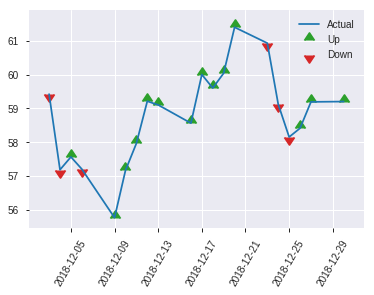


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.23500549396890136
RMSE: 0.48477365230476516
LogLoss: 0.6613880449872005
Null degrees of freedom: 235
Residual degrees of freedom: 36
Null deviance: 328.8185624091997
Residual deviance: 312.17515723395866
AIC: 712.1751572339587
AUC: 0.6493534638445424
pr_auc: 0.5646498277126664
Gini: 0.2987069276890848
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.32533244692618224: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      43   84   0.6614   (84.0/127.0)
1      11   98   0.1009   (11.0/109.0)
Total  54   182  0.4025   (95.0/236.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.325332     0.67354   181
max f2                       0.250653     0.818182  223
max f0point5                 0.377581     0.602322  144
max accuracy                 0.415906     0.627119  118
max precision                0.651862     1         0
max recall                   0.184406     1         233
max specificity              0.651862     1         0
max absolute_mcc             0.325332     0.282064  181
max min_per_class_accuracy   0.41785      0.622047  115
max mean_per_class_accuracy  0.377581     0.636639  144

Gains/Lift Table: Avg response rate: 46.19 %, avg score: 41.18 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0127119                   0.628497           1.44343   1.44343            0.666667         0.642498  0.666667                    0.642498            0.0183486       0.0183486                  44.3425   44.3425
    2        0.0211864                   0.616116           2.16514   1.73211            1                0.621154  0.8                         0.63396             0.0183486       0.0366972                  116.514   73.211
    3        0.0338983                   0.606324           0.721713  1.35321            0.333333         0.610031  0.625                       0.624987            0.00917431      0.0458716                  -27.8287  35.3211
    4        0.0423729                   0.590867           1.08257   1.29908            0.5              0.595679  0.6                         0.619125            0.00917431      0.0550459                  8.25688   29.9083
    5        0.0508475                   0.570428           1.08257   1.263              0.5              0.582817  0.583333                    0.613074            0.00917431      0.0642202                  8.25688   26.2997
    6        0.101695                    0.546673           1.08257   1.17278            0.5              0.552764  0.541667                    0.582919            0.0550459       0.119266                   8.25688   17.2783
    7        0.152542                    0.523379           1.62385   1.32314            0.75             0.533615  0.611111                    0.566484            0.0825688       0.201835                   62.3853   32.314
    8        0.20339                     0.508363           0.902141  1.21789            0.416667         0.516356  0.5625                      0.553952            0.0458716       0.247706                   -9.78593  21.789
    9        0.300847                    0.475395           1.0355    1.15881            0.478261         0.488499  0.535211                    0.532749            0.100917        0.348624                   3.55006   15.8806
    10       0.402542                    0.443684           1.71407   1.29908            0.791667         0.46149   0.6                         0.514747            0.174312        0.522936                   71.4067   29.9083
    11       0.5                         0.416381           1.12964   1.26606            0.521739         0.431165  0.584746                    0.498455            0.110092        0.633028                   12.9637   26.6055
    12       0.601695                    0.380998           1.08257   1.23504            0.5              0.399593  0.570423                    0.481746            0.110092        0.743119                   8.25688   23.5043
    13       0.699153                    0.349445           0.847228  1.18098            0.391304         0.363862  0.545455                    0.465314            0.0825688       0.825688                   -15.2772  18.0984
    14       0.800847                    0.315272           0.811927  1.13412            0.375            0.331061  0.52381                     0.448266            0.0825688       0.908257                   -18.8073  13.412
    15       0.898305                    0.269155           0.470682  1.06214            0.217391         0.293542  0.490566                    0.43148             0.0458716       0.954128                   -52.9318  6.2143
    16       1                           0.172183           0.45107   1                  0.208333         0.23833   0.461864                    0.411838            0.

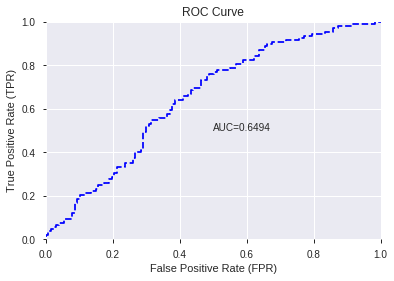

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


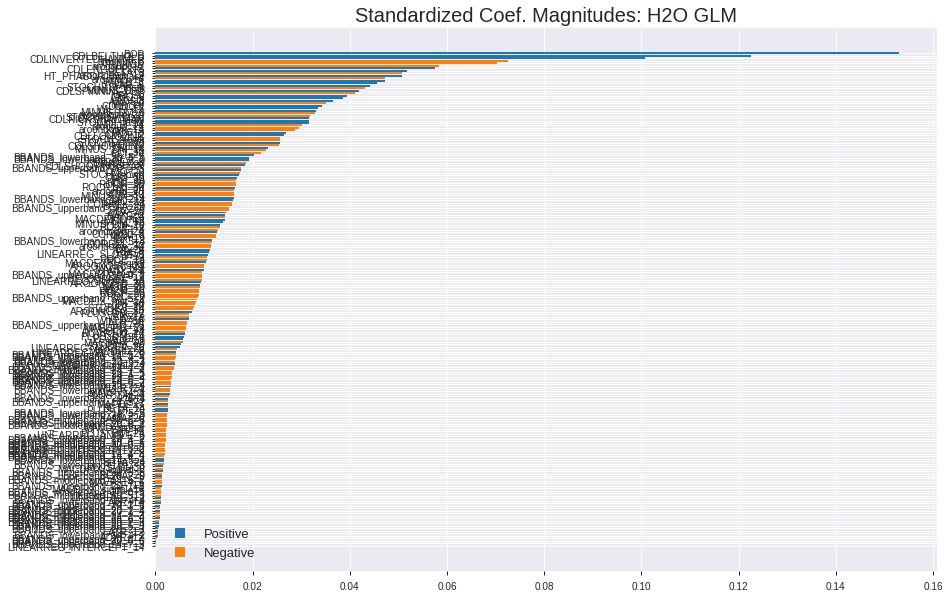

'log_likelihood'
--2019-08-24 00:53:36--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.184.171
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.184.171|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190824_005326_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190824_005326_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_106_sid_9850',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_106

['BOP',
 'CDLBELTHOLD',
 'CDLINVERTEDHAMMER',
 'aroonup_8',
 'TRANGE',
 'aroonup_12',
 'CDLENGULFING',
 'BETA_8',
 'aroondown_12',
 'HT_PHASOR_inphase',
 'aroonup_14',
 'WILLR_8',
 'VAR_8',
 'STOCHRSI_fastk',
 'MINUS_DI_8',
 'CDLSPINNINGTOP',
 'MFI_30',
 'CMO_8',
 'CCI_8',
 'ADOSC',
 'MFI_20',
 'CDLDOJI',
 'WILLR_12',
 'MINUS_DM_8',
 'aroondown_20',
 'STOCHRSI_fastd',
 'CDLRICKSHAWMAN',
 'STOCHF_fastk',
 'WILLR_14',
 'aroonup_24',
 'aroondown_14',
 'ROC_8',
 'CMO_12',
 'CDLLONGLINE',
 'STOCH_slowk',
 'STOCHF_fastd',
 'MFI_12',
 'CDLSHORTLINE',
 'MINUS_DM_14',
 'CCI_30',
 'CCI_24',
 'BBANDS_lowerband_30_5_5',
 'BBANDS_lowerband_30_0_5',
 'STDDEV_8',
 'CORREL_20',
 'CDLSHOOTINGSTAR',
 'BBANDS_upperband_30_5_5',
 'CMO_20',
 'STOCH_slowd',
 'CMO_30',
 'RSI_20',
 'ROC_30',
 'ROCR_30',
 'ROCR100_30',
 'RSI_24',
 'aroonup_20',
 'ATR_30',
 'MINUS_DI_14',
 'BBANDS_lowerband_30_2_4',
 'CMO_24',
 'CORREL_24',
 'BETA_20',
 'BBANDS_upperband_30_2_4',
 'DX_20',
 'ADX_20',
 'NATR_8',
 'MACDEXT_hist',

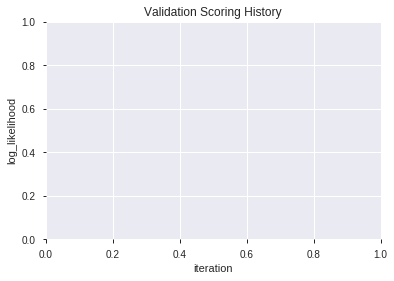

In [52]:
# GLM with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190824_005351_model_6  0.685184  0.646859              0.334501  0.476860  0.227395
1  XGBoost_grid_1_AutoML_20190824_005351_model_2  0.683378  0.647869              0.396952  0.477384  0.227895
2  XGBoost_grid_1_AutoML_20190824_005351_model_1  0.683306  0.661349              0.365419  0.483657  0.233925
3  XGBoost_grid_1_AutoML_20190824_005351_model_3  0.675793  0.644967              0.355523  0.476286  0.226849
4  XGBoost_grid_1_AutoML_20190824_005351_model_4  0.673698  0.645287              0.371993  0.476304  0.226866
5  XGBoost_grid_1_AutoML_20190824_005351_model_7  0.667774  0.652145              0.390342  0.479914  0.230318
6               XGBoost_2_AutoML_20190824_005351  0.660767  0.654881              0.348913  0.481031  0.231391
7               XGBoost_1_AutoML_20190824_005351  0.656577  0.660209              0.431084  0.483699  0.233965
8               XGBoost_3_AutoML_20190824_005351  0.652893  0.660529              0.426497  0.484079  0.234333
9  XGBoost_grid_1_AutoML_20190824_005351_model_5  0.595030  0.698890              0.416564  0.501445  0.251447

variable  relative_importance  scaled_importance  percentage
0                     TRANGE           935.881775           1.000000    0.118473
1                        BOP           820.677795           0.876903    0.103889
2                   STDDEV_8           209.661652           0.224026    0.026541
3                     BETA_8           152.403976           0.162845    0.019293
4             STOCHRSI_fastd           120.817940           0.129095    0.015294
..                       ...                  ...                ...         ...
163                  MACDEXT             6.099828           0.006518    0.000772
164                   CMO_20             5.615771           0.006001    0.000711
165  BBANDS_upperband_24_1_3             5.614035           0.005999    0.000711
166  BBANDS_lowerband_20_1_4             4.587100           0.004901    0.000581
167                  DEMA_20             1.281052           0.001369    0.000162

[168 rows x 4 columns]

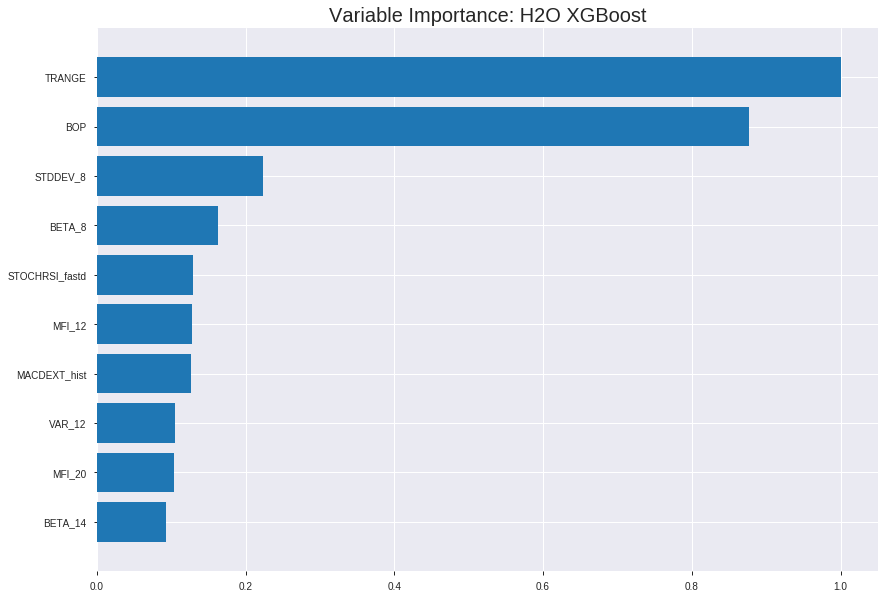

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190824_005351_model_6


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.15815544542790796
RMSE: 0.397687622925215
LogLoss: 0.49724556569170486
Mean Per-Class Error: 0.16390113442661491
AUC: 0.91699729618527
pr_auc: 0.9242210611511156
Gini: 0.8339945923705401
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5183842976888021: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      628  167  0.2101   (167.0/795.0)
1      118  738  0.1379   (118.0/856.0)
Total  746  905  0.1726   (285.0/1651.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.518384     0.83816   193
max f2                       0.36601      0.895016  282
max f0point5                 0.596049     0.871302  138
max accuracy                 0.559851     0.83404   162
max precision                0.83193      1         0
max recall                   0.27928      1         334
max specificity              0.83193      1         0
max absolute_mcc             0.559851     0.674273  162
max min_per_class_accuracy   0.532518     0.821384  182
max mean_per_class_accuracy  0.559851     0.836099  162

Gains/Lift Table: Avg response rate: 51.85 %, avg score: 51.75 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102968                   0.798428           1.92874   1.92874            1                0.813093  1                           0.813093            0.0198598       0.0198598                  92.8738   92.8738
    2        0.0205936                   0.786345           1.92874   1.92874            1                0.791229  1                           0.802161            0.0198598       0.0397196                  92.8738   92.8738
    3        0.0302847                   0.77176            1.92874   1.92874            1                0.77777   1                           0.794356            0.0186916       0.0584112                  92.8738   92.8738
    4        0.0405815                   0.764044           1.92874   1.92874            1                0.767085  1                           0.787437            0.0198598       0.078271                   92.8738   92.8738
    5        0.0502726                   0.754766           1.92874   1.92874            1                0.759261  1                           0.782005            0.0186916       0.0969626                  92.8738   92.8738
    6        0.100545                    0.727312           1.92874   1.92874            1                0.739117  1                           0.760561            0.0969626       0.193925                   92.8738   92.8738
    7        0.150212                    0.699675           1.8817    1.91318            0.97561          0.711523  0.991935                    0.744347            0.0934579       0.287383                   88.1696   91.3184
    8        0.200485                    0.681314           1.88226   1.90543            0.975904         0.690777  0.987915                    0.730914            0.0946262       0.382009                   88.2263   90.543
    9        0.300424                    0.636844           1.71833   1.84319            0.890909         0.659526  0.955645                    0.707166            0.171729        0.553738                   71.8331   84.3189
    10       0.400363                    0.585218           1.54299   1.76825            0.8              0.61193   0.916793                    0.683393            0.154206        0.707944                   54.2991   76.8253
    11       0.500303                    0.535872           1.06373   1.62752            0.551515         0.562242  0.843826                    0.659192            0.106308        0.814252                   6.37284   62.7519
    12       0.600242                    0.48861            0.841631  1.49667            0.436364         0.514559  0.775984                    0.635111            0.0841121       0.898364                   -15.8369  49.667
    13       0.700182                    0.424252           0.52602   1.35813            0.272727         0.458446  0.704152                    0.609895            0.0525701       0.950935                   -47.398   35.8125
    14       0.800121                    0.351239           0.362369  1.23375            0.187879         0.388887  0.639667                    0.58229             0.036215        0.98715                    -63.7631  23.375
    15       0.900061                    0.262654           0.128583  1.11104            0.0666667        0.308704  0.576043                    0.551912            0.0128505       1                          -87.1417  11.1036
    16       1                           0.11931            0         1                  0                0.207637  0.518474                    0.517505            



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.24188250505666614
RMSE: 0.4918155193328756
LogLoss: 0.6779074622541599
Mean Per-Class Error: 0.3777460437211475
AUC: 0.6359954015555676
pr_auc: 0.5913293767225682
Gini: 0.2719908031111351
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.277676522731781: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      71   170  0.7054   (170.0/241.0)
1      28   203  0.1212   (28.0/231.0)
Total  99   373  0.4195   (198.0/472.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.277677     0.672185  315
max f2                       0.145657     0.827957  398
max f0point5                 0.388675     0.613968  225
max accuracy                 0.391426     0.620763  222
max precision                0.743246     1         0
max recall                   0.145657     1         398
max specificity              0.743246     1         0
max absolute_mcc             0.388675     0.246732  225
max min_per_class_accuracy   0.421795     0.593074  195
max mean_per_class_accuracy  0.388675     0.622254  225

Gains/Lift Table: Avg response rate: 48.94 %, avg score: 41.53 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain         cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  -----------  -----------------
    1        0.0105932                   0.675531           1.22597   1.22597            0.6              0.695369  0.6                         0.695369            0.012987        0.012987                   22.5974      22.5974
    2        0.0211864                   0.662549           0.817316  1.02165            0.4              0.668513  0.5                         0.681941            0.00865801      0.021645                   -18.2684     2.1645
    3        0.0317797                   0.646595           2.04329   1.36219            1                0.657555  0.666667                    0.673813            0.021645        0.04329                    104.329      36.2193
    4        0.0402542                   0.63664            1.53247   1.39804            0.75             0.641474  0.684211                    0.667005            0.012987        0.0562771                  53.2468      39.8041
    5        0.0508475                   0.628635           1.63463   1.44733            0.8              0.634022  0.708333                    0.660133            0.017316        0.0735931                  63.4632      44.733
    6        0.101695                    0.598187           1.27706   1.36219            0.625            0.610721  0.666667                    0.635427            0.0649351       0.138528                   27.7056      36.2193
    7        0.150424                    0.57261            1.1549    1.29504            0.565217         0.586846  0.633803                    0.61969             0.0562771       0.194805                   15.4903      29.5043
    8        0.201271                    0.554939           1.10678   1.24748            0.541667         0.565023  0.610526                    0.605879            0.0562771       0.251082                   10.6782      24.7482
    9        0.300847                    0.512216           1.13033   1.20871            0.553191         0.533298  0.591549                    0.581856            0.112554        0.363636                   13.0331      20.8707
    10       0.400424                    0.462373           1.39118   1.25408            0.680851         0.488233  0.613757                    0.558574            0.138528        0.502165                   39.1176      25.4083
    11       0.5                         0.418849           0.912959  1.18615            0.446809         0.437636  0.580508                    0.534489            0.0909091       0.593074                   -8.70406     18.6147
    12       0.599576                    0.375467           1.1738    1.1841             0.574468         0.395755  0.579505                    0.511448            0.116883        0.709957                   17.3805      18.4097
    13       0.699153                    0.320829           0.999908  1.15786            0.489362         0.351387  0.566667                    0.488652            0.0995671       0.809524                   -0.00921065  15.7864
    14       0.798729                    0.273848           0.695588  1.10023            0.340426         0.298261  0.538462                    0.464916            0.0692641       0.878788                   -30.4412     10.0233
    15       0.898305                    0.225385           0.652114  1.05056            0.319149         0.247203  0.514151                    0.440783            0.0649351       0.943723                   -34.7886     5.05595
    16       1                           0.117038           0.553391  1                  0.270833         0.1902


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-24 00:54:03  7.055 sec   0                  0.5              0.693147            0.5             0                  1                0.481526                         0.5                0.693147              0.5               0                    1                  0.510593
    2019-08-24 00:54:03  7.172 sec   5                  0.480076         0.653937            0.811575        0.819337           1.92874          0.271956                         0.495072           0.683309              0.604803          0.576955             1.45949            0.459746
    2019-08-24 00:54:04  7.224 sec   10                 0.464946         0.624718            0.842715        0.860417           1.92874          0.26166                          0.4918             0.676745              0.622173          0.581924             1.63463            0.444915
    2019-08-24 00:54:04  7.278 sec   15                 0.451742         0.599398            0.857088        0.876901           1.92874          0.247123                         0.486804           0.666777              0.650177          0.608216             1.70274            0.381356
    2019-08-24 00:54:04  7.335 sec   20                 0.441551         0.579873            0.866781        0.885379           1.92874          0.244094                         0.483605           0.660128              0.655979          0.610578             1.63463            0.385593
    2019-08-24 00:54:04  7.391 sec   25                 0.433058         0.563534            0.877437        0.892736           1.92874          0.231981                         0.484899           0.662448              0.645884          0.601031             1.63463            0.379237
    2019-08-24 00:54:04  7.447 sec   30                 0.423927         0.546175            0.887399        0.90305            1.92874          0.20109                          0.484105           0.660872              0.649755          0.607245             1.63463            0.381356
    2019-08-24 00:54:04  7.503 sec   35                 0.416656         0.532317            0.893822        0.907114           1.92874          0.205936                         0.486831           0.66654               0.63931           0.59543              1.22597            0.413136
    2019-08-24 00:54:04  7.562 sec   40                 0.408897         0.517809            0.903802        0.915502           1.92874          0.184737                         0.486973           0.666768              0.642049          0.604038             1.63463            0.427966
    2019-08-24 00:54:04  7.618 sec   45                 0.403156         0.507203            0.910099        0.920808           1.92874          0.186554                         0.490576           0.675057              0.637136          0.597027             1.22597            0.411017
    2019-08-24 00:54:04  7.676 sec   50                 0.397688         0.497246            0.916997        0.924221           1.92874          0.172623                         0.491816           0.677907              0.635995          0.591329             1.22597            0.419492

Variable Importances: 


variable                 relative_importance    scaled_importance     percentage
-----------------------  ---------------------  --------------------  ----------------------
TRANGE                   935.8817749023438      1.0                   0.11847259276877094
BOP                      820.6777954101562      0.8769032771215054    0.1038890048480168
STDDEV_8                 209.66165161132812     0.22402578748069504   0.026540915889903607
BETA_8                   152.4039764404297      0.16284532996310624   0.019292708461015218
STOCHRSI_fastd           120.81793975830078     0.12909530134926256   0.01529425506511295
---                      ---                    ---                   ---
MACDEXT                  6.099827766418457      0.006517733254347169  0.0007721727576177483
CMO_20                   5.615771293640137      0.006000513573657447  0.0007108964010154011
BBANDS_upperband_24_1_3  5.614034652709961      0.005998657953667029  0.0007106765609039428
BBANDS_lowerband_20_1_4  4.587100028991699      0.004901366980322219  0.0005806776542700148
DEMA_20                  1.2810522317886353     0.001368818440686388  0.00016216746969782247


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6652542372881356)

('F1', 0.6772908366533864)

('auc', 0.6851838474319151)

('logloss', 0.646858672289474)

('mean_per_class_error', 0.3285776204579932)

('rmse', 0.47685964261985614)

('mse', 0.2273951187595369)

xgboost prediction progress: |████████████████████████████████████████████| 100%


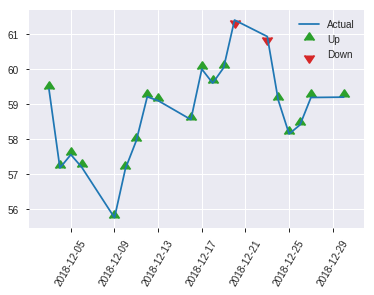


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2273951187595369
RMSE: 0.47685964261985614
LogLoss: 0.646858672289474
Mean Per-Class Error: 0.3285776204579932
AUC: 0.6851838474319151
pr_auc: 0.6429019783337364
Gini: 0.37036769486383014
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3618248999118805: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      70   57   0.4488   (57.0/127.0)
1      24   85   0.2202   (24.0/109.0)
Total  94   142  0.3432   (81.0/236.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.361825     0.677291  141
max f2                       0.143821     0.811012  235
max f0point5                 0.371737     0.635659  133
max accuracy                 0.371737     0.665254  133
max precision                0.686522     1         0
max recall                   0.143821     1         235
max specificity              0.686522     1         0
max absolute_mcc             0.371737     0.345033  133
max min_per_class_accuracy   0.411257     0.637795  115
max mean_per_class_accuracy  0.371737     0.671422  133

Gains/Lift Table: Avg response rate: 46.19 %, avg score: 40.33 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0127119                   0.633286           2.16514   2.16514            1                0.659613  1                           0.659613            0.0275229       0.0275229                  116.514   116.514
    2        0.0211864                   0.61731            2.16514   2.16514            1                0.619774  1                           0.643677            0.0183486       0.0458716                  116.514   116.514
    3        0.0338983                   0.608821           1.44343   1.8945             0.666667         0.611638  0.875                       0.631662            0.0183486       0.0642202                  44.3425   89.4495
    4        0.0423729                   0.607571           1.08257   1.73211            0.5              0.607837  0.8                         0.626897            0.00917431      0.0733945                  8.25688   73.211
    5        0.0508475                   0.602327           2.16514   1.80428            1                0.605675  0.833333                    0.62336             0.0183486       0.0917431                  116.514   80.4281
    6        0.101695                    0.565265           1.62385   1.71407            0.75             0.584002  0.791667                    0.603681            0.0825688       0.174312                   62.3853   71.4067
    7        0.152542                    0.544253           1.08257   1.50357            0.5              0.553775  0.694444                    0.587046            0.0550459       0.229358                   8.25688   50.3568
    8        0.20339                     0.517977           1.44343   1.48853            0.666667         0.526994  0.6875                      0.572033            0.0733945       0.302752                   44.3425   48.8532
    9        0.300847                    0.486152           1.12964   1.37227            0.521739         0.49964   0.633803                    0.548582            0.110092        0.412844                   12.9637   37.227
    10       0.402542                    0.446808           1.263     1.34466            0.583333         0.466046  0.621053                    0.527731            0.12844         0.541284                   26.2997   34.4664
    11       0.5                         0.408061           1.0355    1.2844             0.478261         0.424536  0.59322                     0.507616            0.100917        0.642202                   3.55006   28.4404
    12       0.601695                    0.361825           1.35321   1.29603            0.625            0.382016  0.598592                    0.486388            0.137615        0.779817                   35.3211   29.6033
    13       0.699153                    0.320564           0.282409  1.15474            0.130435         0.3369    0.533333                    0.46555             0.0275229       0.807339                   -71.7591  15.474
    14       0.800847                    0.28884            0.721713  1.09975            0.333333         0.301841  0.507937                    0.444762            0.0733945       0.880734                   -27.8287  9.97524
    15       0.898305                    0.238581           0.658955  1.05193            0.304348         0.264046  0.485849                    0.425156            0.0642202       0.944954                   -34.1045  5.19301
    16       1                           0.143821           0.541284  1                  0.25             0.210428  0.461864                    0.403319            

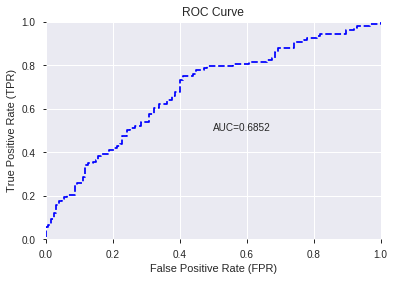

This function is available for GLM models only


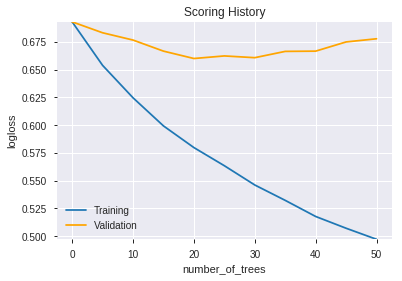

--2019-08-24 00:54:09--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.170.251
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.170.251|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.indexOf(String.java:1578)
	at java.base/java.lang.String.indexOf(String.java:1535)
	at java.base/java.lang.String.split(String.java:2274)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190824_005351_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190824_005351_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_114_sid_9850',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_trainin

['TRANGE',
 'BOP',
 'STDDEV_8',
 'BETA_8',
 'STOCHRSI_fastd',
 'MFI_12',
 'MACDEXT_hist',
 'VAR_12',
 'MFI_20',
 'BETA_14',
 'NATR_8',
 'BETA_20',
 'CCI_8',
 'ROC_14',
 'MACDFIX_hist_8',
 'ADOSC',
 'ROC_30',
 'CORREL_20',
 'CDLBELTHOLD',
 'STDDEV_20',
 'CORREL_8',
 'STOCH_slowk',
 'MINUS_DM_8',
 'ROCP_12',
 'MFI_8',
 'CORREL_14',
 'MFI_30',
 'ATR_14',
 'ADX_24',
 'LINEARREG_ANGLE_8',
 'WILLR_8',
 'DX_30',
 'DX_24',
 'CORREL_12',
 'aroondown_12',
 'WILLR_24',
 'ADX_20',
 'MACDFIX_hist_14',
 'STDDEV_14',
 'LINEARREG_SLOPE_14',
 'BETA_24',
 'MACDEXT_signal',
 'CORREL_24',
 'HT_PHASOR_inphase',
 'MACD_signal',
 'CCI_24',
 'DX_12',
 'MOM_12',
 'MACDFIX_signal_14',
 'LINEARREG_INTERCEPT_14',
 'MACDFIX_signal_24',
 'MOM_20',
 'aroondown_24',
 'WILLR_30',
 'APO',
 'BBANDS_lowerband_30_0_5',
 'NATR_20',
 'ROC_20',
 'BBANDS_lowerband_20_0_2',
 'PLUS_DI_24',
 'DX_20',
 'BBANDS_lowerband_14_4_2',
 'MINUS_DI_14',
 'STOCHF_fastk',
 'BBANDS_upperband_30_5_5',
 'CCI_30',
 'WILLR_12',
 'MOM_8',
 'aroon

In [53]:
# XGBoost with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="XGBoost",features_list=features_list)

In [54]:
# Experiment Summary
pd.set_option('precision', 3) 

for k in models_summary:
  print(k)
  display(models_summary[k].max())
  print('\n'*3)
  display(models_summary[k].groupby(models_summary[k].index).max())
  print('\n'*3)
  
display(models_summary)

pd.set_option('precision', 6) 

accuracy


DeepLearning    0.653
GLM             0.636
XGBoost         0.665
dtype: float64

DeepLearning    GLM  XGBoost
All          0.462  0.462    0.665
DLF          0.640  0.627    0.661
Fwe          0.653  0.636    0.657
RFE          0.644  0.627    0.665
XGBF         0.653  0.627    0.661





F1


DeepLearning    0.698
GLM             0.674
XGBoost         0.677
dtype: float64

DeepLearning    GLM  XGBoost
All          0.632  0.632    0.674
DLF          0.698  0.662    0.674
Fwe          0.673  0.664    0.667
RFE          0.679  0.674    0.677
XGBF         0.688  0.662    0.674





auc


DeepLearning    0.688
GLM             0.654
XGBoost         0.689
dtype: float64

DeepLearning    GLM  XGBoost
All          0.500  0.500    0.687
DLF          0.681  0.648    0.686
Fwe          0.683  0.654    0.689
RFE          0.673  0.649    0.685
XGBF         0.688  0.648    0.686





logloss


DeepLearning     0.697
GLM             15.952
XGBoost          0.647
dtype: float64

DeepLearning     GLM  XGBoost
All          0.697  15.952    0.640
DLF          0.648   0.657    0.639
Fwe          0.638   0.657    0.635
RFE          0.653   0.661    0.647
XGBF         0.654   0.657    0.639





mean_per_class_error


DeepLearning    0.500
GLM             0.500
XGBoost         0.346
dtype: float64

DeepLearning    GLM  XGBoost
All          0.500  0.500    0.332
DLF          0.342  0.365    0.346
Fwe          0.342  0.357    0.341
RFE          0.350  0.363    0.329
XGBF         0.352  0.365    0.346





rmse


DeepLearning    0.502
GLM             0.680
XGBoost         0.477
dtype: float64

DeepLearning    GLM  XGBoost
All          0.502  0.680    0.473
DLF          0.478  0.482    0.473
Fwe          0.474  0.482    0.471
RFE          0.481  0.485    0.477
XGBF         0.479  0.482    0.473





mse


DeepLearning    0.252
GLM             0.462
XGBoost         0.227
dtype: float64

DeepLearning    GLM  XGBoost
All          0.252  0.462    0.224
DLF          0.228  0.232    0.224
Fwe          0.224  0.233    0.222
RFE          0.231  0.235    0.227
XGBF         0.229  0.232    0.224

{'F1':       DeepLearning    GLM  XGBoost
 All          0.632    NaN      NaN
 DLF          0.698    NaN      NaN
 DLF            NaN  0.662      NaN
 DLF            NaN    NaN    0.674
 All            NaN  0.632      NaN
 All            NaN    NaN    0.674
 XGBF         0.688    NaN      NaN
 XGBF           NaN  0.662      NaN
 XGBF           NaN    NaN    0.674
 Fwe          0.673    NaN      NaN
 Fwe            NaN  0.664      NaN
 Fwe            NaN    NaN    0.667
 RFE          0.679    NaN      NaN
 RFE            NaN  0.674      NaN
 RFE            NaN    NaN    0.677,
 'accuracy':       DeepLearning    GLM  XGBoost
 All          0.462    NaN      NaN
 DLF          0.640    NaN      NaN
 DLF            NaN  0.627      NaN
 DLF            NaN    NaN    0.661
 All            NaN  0.462      NaN
 All            NaN    NaN    0.665
 XGBF         0.653    NaN      NaN
 XGBF           NaN  0.627      NaN
 XGBF           NaN    NaN    0.661
 Fwe          0.653    NaN      NaN
 Fwe     